Rossmann is a European drug distributor which operates over 3,000 drug stores across seven European countries. Since a lot of drugs come with a short shelf life, that is, they do not have a long expiry date, it becomes imperative for Rossmann to accurately forecast sales at their individual stores. Currently, the forecasting is taken care of by the store managers who are tasked with forecasting daily sales for the next six weeks. 

 

As expected, store sales are influenced by many factors, including promotional campaigns, competition, state holidays, seasonality, and locality.

 

With thousands of individual managers predicting sales based on their unique circumstances and intuitions, the accuracy of the forecasts is quite varied. To overcome this problem, the company has hired you as a data scientist to work on the forecasting problem. As part of your job role, you are tasked with building a forecasting model to forecast the daily sales for the next six weeks. To help you with the same, you have been provided with historical sales data for 1,115 Rossmann stores.

In [1]:
## importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
from statsmodels.tsa.api import VAR
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller 
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import coint_johansen #Johansen Cointegration test
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler

In [2]:
# importing data from both datasets
store_data = pd.read_csv('store.csv')
train_data = pd.read_csv('train.csv')

In [3]:
store_data


Store StoreType Assortment  CompetitionDistance  \
0         1         c          a               1270.0   
1         2         a          a                570.0   
2         3         a          a              14130.0   
3         4         c          c                620.0   
4         5         a          a              29910.0   
...     ...       ...        ...                  ...   
1110   1111         a          a               1900.0   
1111   1112         c          c               1880.0   
1112   1113         a          c               9260.0   
1113   1114         a          c                870.0   
1114   1115         d          c               5350.0   

      CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                           9.0                    2008.0       0   
1                          11.0                    2007.0       1   
2                          12.0                    2006.0       1   
3                           9.0                    2009.0       0   
4                           4.0                    2015.0       0   
...                         ...                       ...     ...   
1110                        6.0                    2014.0       1   
1111                        4.0                    2006.0       0   
1112                        NaN                       NaN       0   
1113                        NaN                       NaN       0   
1114                        NaN                       NaN       1   

      Promo2SinceWeek  Promo2SinceYear     PromoInterval  
0                 NaN              NaN               NaN  
1                13.0           2010.0   Jan,Apr,Jul,Oct  
2                14.0           2011.0   Jan,Apr,Jul,Oct  
3                 NaN              NaN               NaN  
4                 NaN              NaN               NaN  
...               ...              ...               ...  
1110             31.0           2013.0   Jan,Apr,Jul,Oct  
1111              NaN              NaN               NaN  
1112              NaN              NaN               NaN  
1113              NaN              NaN               NaN  
1114             22.0           2012.0  Mar,Jun,Sept,Dec  

[1115 rows x 10 columns]

In [4]:
train_data

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
0            1          5  2015-07-31   5263        555     1      1   
1            2          5  2015-07-31   6064        625     1      1   
2            3          5  2015-07-31   8314        821     1      1   
3            4          5  2015-07-31  13995       1498     1      1   
4            5          5  2015-07-31   4822        559     1      1   
...        ...        ...         ...    ...        ...   ...    ...   
1017204   1111          2  2013-01-01      0          0     0      0   
1017205   1112          2  2013-01-01      0          0     0      0   
1017206   1113          2  2013-01-01      0          0     0      0   
1017207   1114          2  2013-01-01      0          0     0      0   
1017208   1115          2  2013-01-01      0          0     0      0   

        StateHoliday  SchoolHoliday  
0                  0              1  
1                  0              1  
2                  0              1  
3                  0              1  
4                  0              1  
...              ...            ...  
1017204            a              1  
1017205            a              1  
1017206            a              1  
1017207            a              1  
1017208            a              1  

[1017209 rows x 9 columns]

In [5]:
#converting data to datetime format
train_data['Date'] = pd.to_datetime(train_data['Date'], format='%Y-%m')

In [6]:
#merge the datasets to form a single dataset which we can use as the main file.
data = pd.merge(store_data,train_data, on='Store', how='inner')

In [7]:
data

Store StoreType Assortment  CompetitionDistance  \
0            1         c          a               1270.0   
1            1         c          a               1270.0   
2            1         c          a               1270.0   
3            1         c          a               1270.0   
4            1         c          a               1270.0   
...        ...       ...        ...                  ...   
1017204   1115         d          c               5350.0   
1017205   1115         d          c               5350.0   
1017206   1115         d          c               5350.0   
1017207   1115         d          c               5350.0   
1017208   1115         d          c               5350.0   

         CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                              9.0                    2008.0       0   
1                              9.0                    2008.0       0   
2                              9.0                    2008.0       0   
3                              9.0                    2008.0       0   
4                              9.0                    2008.0       0   
...                            ...                       ...     ...   
1017204                        NaN                       NaN       1   
1017205                        NaN                       NaN       1   
1017206                        NaN                       NaN       1   
1017207                        NaN                       NaN       1   
1017208                        NaN                       NaN       1   

         Promo2SinceWeek  Promo2SinceYear     PromoInterval  DayOfWeek  \
0                    NaN              NaN               NaN          5   
1                    NaN              NaN               NaN          4   
2                    NaN              NaN               NaN          3   
3                    NaN              NaN               NaN          2   
4                    NaN              NaN               NaN          1   
...                  ...              ...               ...        ...   
1017204             22.0           2012.0  Mar,Jun,Sept,Dec          6   
1017205             22.0           2012.0  Mar,Jun,Sept,Dec          5   
1017206             22.0           2012.0  Mar,Jun,Sept,Dec          4   
1017207             22.0           2012.0  Mar,Jun,Sept,Dec          3   
1017208             22.0           2012.0  Mar,Jun,Sept,Dec          2   

              Date  Sales  Customers  Open  Promo StateHoliday  SchoolHoliday  
0       2015-07-31   5263        555     1      1            0              1  
1       2015-07-30   5020        546     1      1            0              1  
2       2015-07-29   4782        523     1      1            0              1  
3       2015-07-28   5011        560     1      1            0              1  
4       2015-07-27   6102        612     1      1            0              1  
...            ...    ...        ...   ...    ...          ...            ...  
1017204 2013-01-05   4771        339     1      0            0              1  
1017205 2013-01-04   4540        326     1      0            0              1  
1017206 2013-01-03   4297        300     1      0            0              1  
1017207 2013-01-02   3697        305     1      0            0              1  
1017208 2013-01-01      0          0     0      0            a              1  

[1017209 rows x 18 columns]

In [8]:
(data.isnull().sum() / 1017209 ) * 100

Store                         0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.259730
CompetitionOpenSinceMonth    31.787764
CompetitionOpenSinceYear     31.787764
Promo2                        0.000000
Promo2SinceWeek              49.943620
Promo2SinceYear              49.943620
PromoInterval                49.943620
DayOfWeek                     0.000000
Date                          0.000000
Sales                         0.000000
Customers                     0.000000
Open                          0.000000
Promo                         0.000000
StateHoliday                  0.000000
SchoolHoliday                 0.000000
dtype: float64

#### There is lot of empty data in some columns and this data is not imputable and these are not so important as 'CompetitionDistance' is enough to explain 'CompetitionOpenSinceMonth' and 'CompetitionOpenSinceYear' .similary Promo2 is enough to explain 'Promo2SinceWeek' and 'Promo2SinceYear' .Hence deletig them

In [9]:
data[data.CompetitionDistance.isnull()]

Store StoreType Assortment  CompetitionDistance  \
263244    291         d          a                  NaN   
263245    291         d          a                  NaN   
263246    291         d          a                  NaN   
263247    291         d          a                  NaN   
263248    291         d          a                  NaN   
...       ...       ...        ...                  ...   
801517    879         d          a                  NaN   
801518    879         d          a                  NaN   
801519    879         d          a                  NaN   
801520    879         d          a                  NaN   
801521    879         d          a                  NaN   

        CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
263244                        NaN                       NaN       0   
263245                        NaN                       NaN       0   
263246                        NaN                       NaN       0   
263247                        NaN                       NaN       0   
263248                        NaN                       NaN       0   
...                           ...                       ...     ...   
801517                        NaN                       NaN       1   
801518                        NaN                       NaN       1   
801519                        NaN                       NaN       1   
801520                        NaN                       NaN       1   
801521                        NaN                       NaN       1   

        Promo2SinceWeek  Promo2SinceYear    PromoInterval  DayOfWeek  \
263244              NaN              NaN              NaN          5   
263245              NaN              NaN              NaN          4   
263246              NaN              NaN              NaN          3   
263247              NaN              NaN              NaN          2   
263248              NaN              NaN              NaN          1   
...                 ...              ...              ...        ...   
801517              5.0           2013.0  Feb,May,Aug,Nov          6   
801518              5.0           2013.0  Feb,May,Aug,Nov          5   
801519              5.0           2013.0  Feb,May,Aug,Nov          4   
801520              5.0           2013.0  Feb,May,Aug,Nov          3   
801521              5.0           2013.0  Feb,May,Aug,Nov          2   

             Date  Sales  Customers  Open  Promo StateHoliday  SchoolHoliday  
263244 2015-07-31  10052        973     1      1            0              1  
263245 2015-07-30   9030        883     1      1            0              1  
263246 2015-07-29   8204        814     1      1            0              1  
263247 2015-07-28  10374        943     1      1            0              1  
263248 2015-07-27  11692       1086     1      1            0              1  
...           ...    ...        ...   ...    ...          ...            ...  
801517 2013-01-05   3175        303     1      0            0              0  
801518 2013-01-04   3160        343     1      0            0              1  
801519 2013-01-03   3344        332     1      0            0              1  
801520 2013-01-02   3077        326     1      0            0              1  
801521 2013-01-01      0          0     0      0            a              1  

[2642 rows x 18 columns]

In [10]:
data.drop([ 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear','DayOfWeek'],axis=1,inplace=True)

In [11]:
(data.isnull().sum() / 1017209 ) * 100

Store                   0.00000
StoreType               0.00000
Assortment              0.00000
CompetitionDistance     0.25973
Promo2                  0.00000
PromoInterval          49.94362
Date                    0.00000
Sales                   0.00000
Customers               0.00000
Open                    0.00000
Promo                   0.00000
StateHoliday            0.00000
SchoolHoliday           0.00000
dtype: float64

In [12]:
promo = data[data.Promo2 == 1]

In [13]:
promo[promo.Promo2.isnull()]

Empty DataFrame
Columns: [Store, StoreType, Assortment, CompetitionDistance, Promo2, PromoInterval, Date, Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday]
Index: []

In [14]:
#### PromoInterval is nul for only those rows where promo2 is 0 hence we can impute it with some thing to use it later 

In [15]:
data[(data.Promo2 == 1) & (data.PromoInterval.isnull() == True) ]

Empty DataFrame
Columns: [Store, StoreType, Assortment, CompetitionDistance, Promo2, PromoInterval, Date, Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday]
Index: []

In [16]:
data[data.PromoInterval == 'Mar,Jun,Sept,Dec']

Store StoreType Assortment  CompetitionDistance  Promo2  \
16772       19         a          c               3240.0       1   
16773       19         a          c               3240.0       1   
16774       19         a          c               3240.0       1   
16775       19         a          c               3240.0       1   
16776       19         a          c               3240.0       1   
...        ...       ...        ...                  ...     ...   
1017204   1115         d          c               5350.0       1   
1017205   1115         d          c               5350.0       1   
1017206   1115         d          c               5350.0       1   
1017207   1115         d          c               5350.0       1   
1017208   1115         d          c               5350.0       1   

            PromoInterval       Date  Sales  Customers  Open  Promo  \
16772    Mar,Jun,Sept,Dec 2015-07-31   8234        718     1      1   
16773    Mar,Jun,Sept,Dec 2015-07-30   8400        687     1      1   
16774    Mar,Jun,Sept,Dec 2015-07-29   7182        610     1      1   
16775    Mar,Jun,Sept,Dec 2015-07-28   7717        633     1      1   
16776    Mar,Jun,Sept,Dec 2015-07-27   8825        732     1      1   
...                   ...        ...    ...        ...   ...    ...   
1017204  Mar,Jun,Sept,Dec 2013-01-05   4771        339     1      0   
1017205  Mar,Jun,Sept,Dec 2013-01-04   4540        326     1      0   
1017206  Mar,Jun,Sept,Dec 2013-01-03   4297        300     1      0   
1017207  Mar,Jun,Sept,Dec 2013-01-02   3697        305     1      0   
1017208  Mar,Jun,Sept,Dec 2013-01-01      0          0     0      0   

        StateHoliday  SchoolHoliday  
16772              0              1  
16773              0              1  
16774              0              1  
16775              0              1  
16776              0              1  
...              ...            ...  
1017204            0              1  
1017205            0              1  
1017206            0              1  
1017207            0              1  
1017208            a              1  

[97460 rows x 13 columns]

In [17]:
data.PromoInterval.unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [18]:
# converting categoric to numeric variables
data['PromoInterval'] = data['PromoInterval'].map({'Jan,Apr,Jul,Oct': 1, 'Feb,May,Aug,Nov': 2 ,'Mar,Jun,Sept,Dec' :3 })

In [19]:
data['PromoInterval'] = data['PromoInterval'].fillna(0)

In [20]:
data.PromoInterval.unique()

array([0., 1., 2., 3.])

In [21]:
data.dtypes

Store                           int64
StoreType                      object
Assortment                     object
CompetitionDistance           float64
Promo2                          int64
PromoInterval                 float64
Date                   datetime64[ns]
Sales                           int64
Customers                       int64
Open                            int64
Promo                           int64
StateHoliday                   object
SchoolHoliday                   int64
dtype: object

## converting StoreType and Assortment to int types from categoric.

In [22]:
data.StoreType.unique()

array(['c', 'a', 'd', 'b'], dtype=object)

In [23]:
data.Assortment.unique()

array(['a', 'c', 'b'], dtype=object)

In [24]:
data['Assortment'] = data['Assortment'].map({'a': 0, 'b': 1 ,'c' :2 })

In [25]:
data.dtypes

Store                           int64
StoreType                      object
Assortment                      int64
CompetitionDistance           float64
Promo2                          int64
PromoInterval                 float64
Date                   datetime64[ns]
Sales                           int64
Customers                       int64
Open                            int64
Promo                           int64
StateHoliday                   object
SchoolHoliday                   int64
dtype: object

In [26]:
data.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [27]:
data['StateHoliday'] = data['StateHoliday'].map({'a': 1, 'b': 2 ,'c' :3 ,'0':0,0:0})

In [28]:
data.StateHoliday.unique()

array([0, 1, 2, 3], dtype=int64)

In [29]:
data[data.StateHoliday.isnull()]

Empty DataFrame
Columns: [Store, StoreType, Assortment, CompetitionDistance, Promo2, PromoInterval, Date, Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday]
Index: []

## checking the correlation between variables

In [30]:
#filtering out key stores
data = data[data.Store.isin([1,3,8,9,13,25,29,31,46])]

In [31]:
data.corr()

Store  Assortment  CompetitionDistance    Promo2  \
Store                1.000000    0.270457            -0.247016  0.071541   
Assortment           0.270457    1.000000             0.029042 -0.482275   
CompetitionDistance -0.247016    0.029042             1.000000  0.196020   
Promo2               0.071541   -0.482275             0.196020  1.000000   
PromoInterval        0.000966   -0.444201             0.011382  0.921053   
Sales                0.083952    0.015114            -0.043313 -0.108269   
Customers            0.114768   -0.152291            -0.071498 -0.138941   
Open                -0.007374    0.009474             0.012695 -0.002039   
Promo               -0.001560    0.001367             0.001477 -0.002835   
StateHoliday         0.003723   -0.003550            -0.006294  0.009255   
SchoolHoliday       -0.016671   -0.001647            -0.004826 -0.012736   

                     PromoInterval     Sales  Customers      Open     Promo  \
Store                     0.000966  0.083952   0.114768 -0.007374 -0.001560   
Assortment               -0.444201  0.015114  -0.152291  0.009474  0.001367   
CompetitionDistance       0.011382 -0.043313  -0.071498  0.012695  0.001477   
Promo2                    0.921053 -0.108269  -0.138941 -0.002039 -0.002835   
PromoInterval             1.000000 -0.128799  -0.191843 -0.003140 -0.003159   
Sales                    -0.128799  1.000000   0.928872  0.721880  0.504876   
Customers                -0.191843  0.928872   1.000000  0.648122  0.352058   
Open                     -0.003140  0.721880   0.648122  1.000000  0.296402   
Promo                    -0.003159  0.504876   0.352058  0.296402  1.000000   
StateHoliday              0.009649 -0.249424  -0.223939 -0.345520 -0.022342   
SchoolHoliday            -0.014155  0.096528   0.077816  0.089420  0.066698   

                     StateHoliday  SchoolHoliday  
Store                    0.003723      -0.016671  
Assortment              -0.003550      -0.001647  
CompetitionDistance     -0.006294      -0.004826  
Promo2                   0.009255      -0.012736  
PromoInterval            0.009649      -0.014155  
Sales                   -0.249424       0.096528  
Customers               -0.223939       0.077816  
Open                    -0.345520       0.089420  
Promo                   -0.022342       0.066698  
StateHoliday             1.000000       0.205014  
SchoolHoliday            0.205014       1.000000

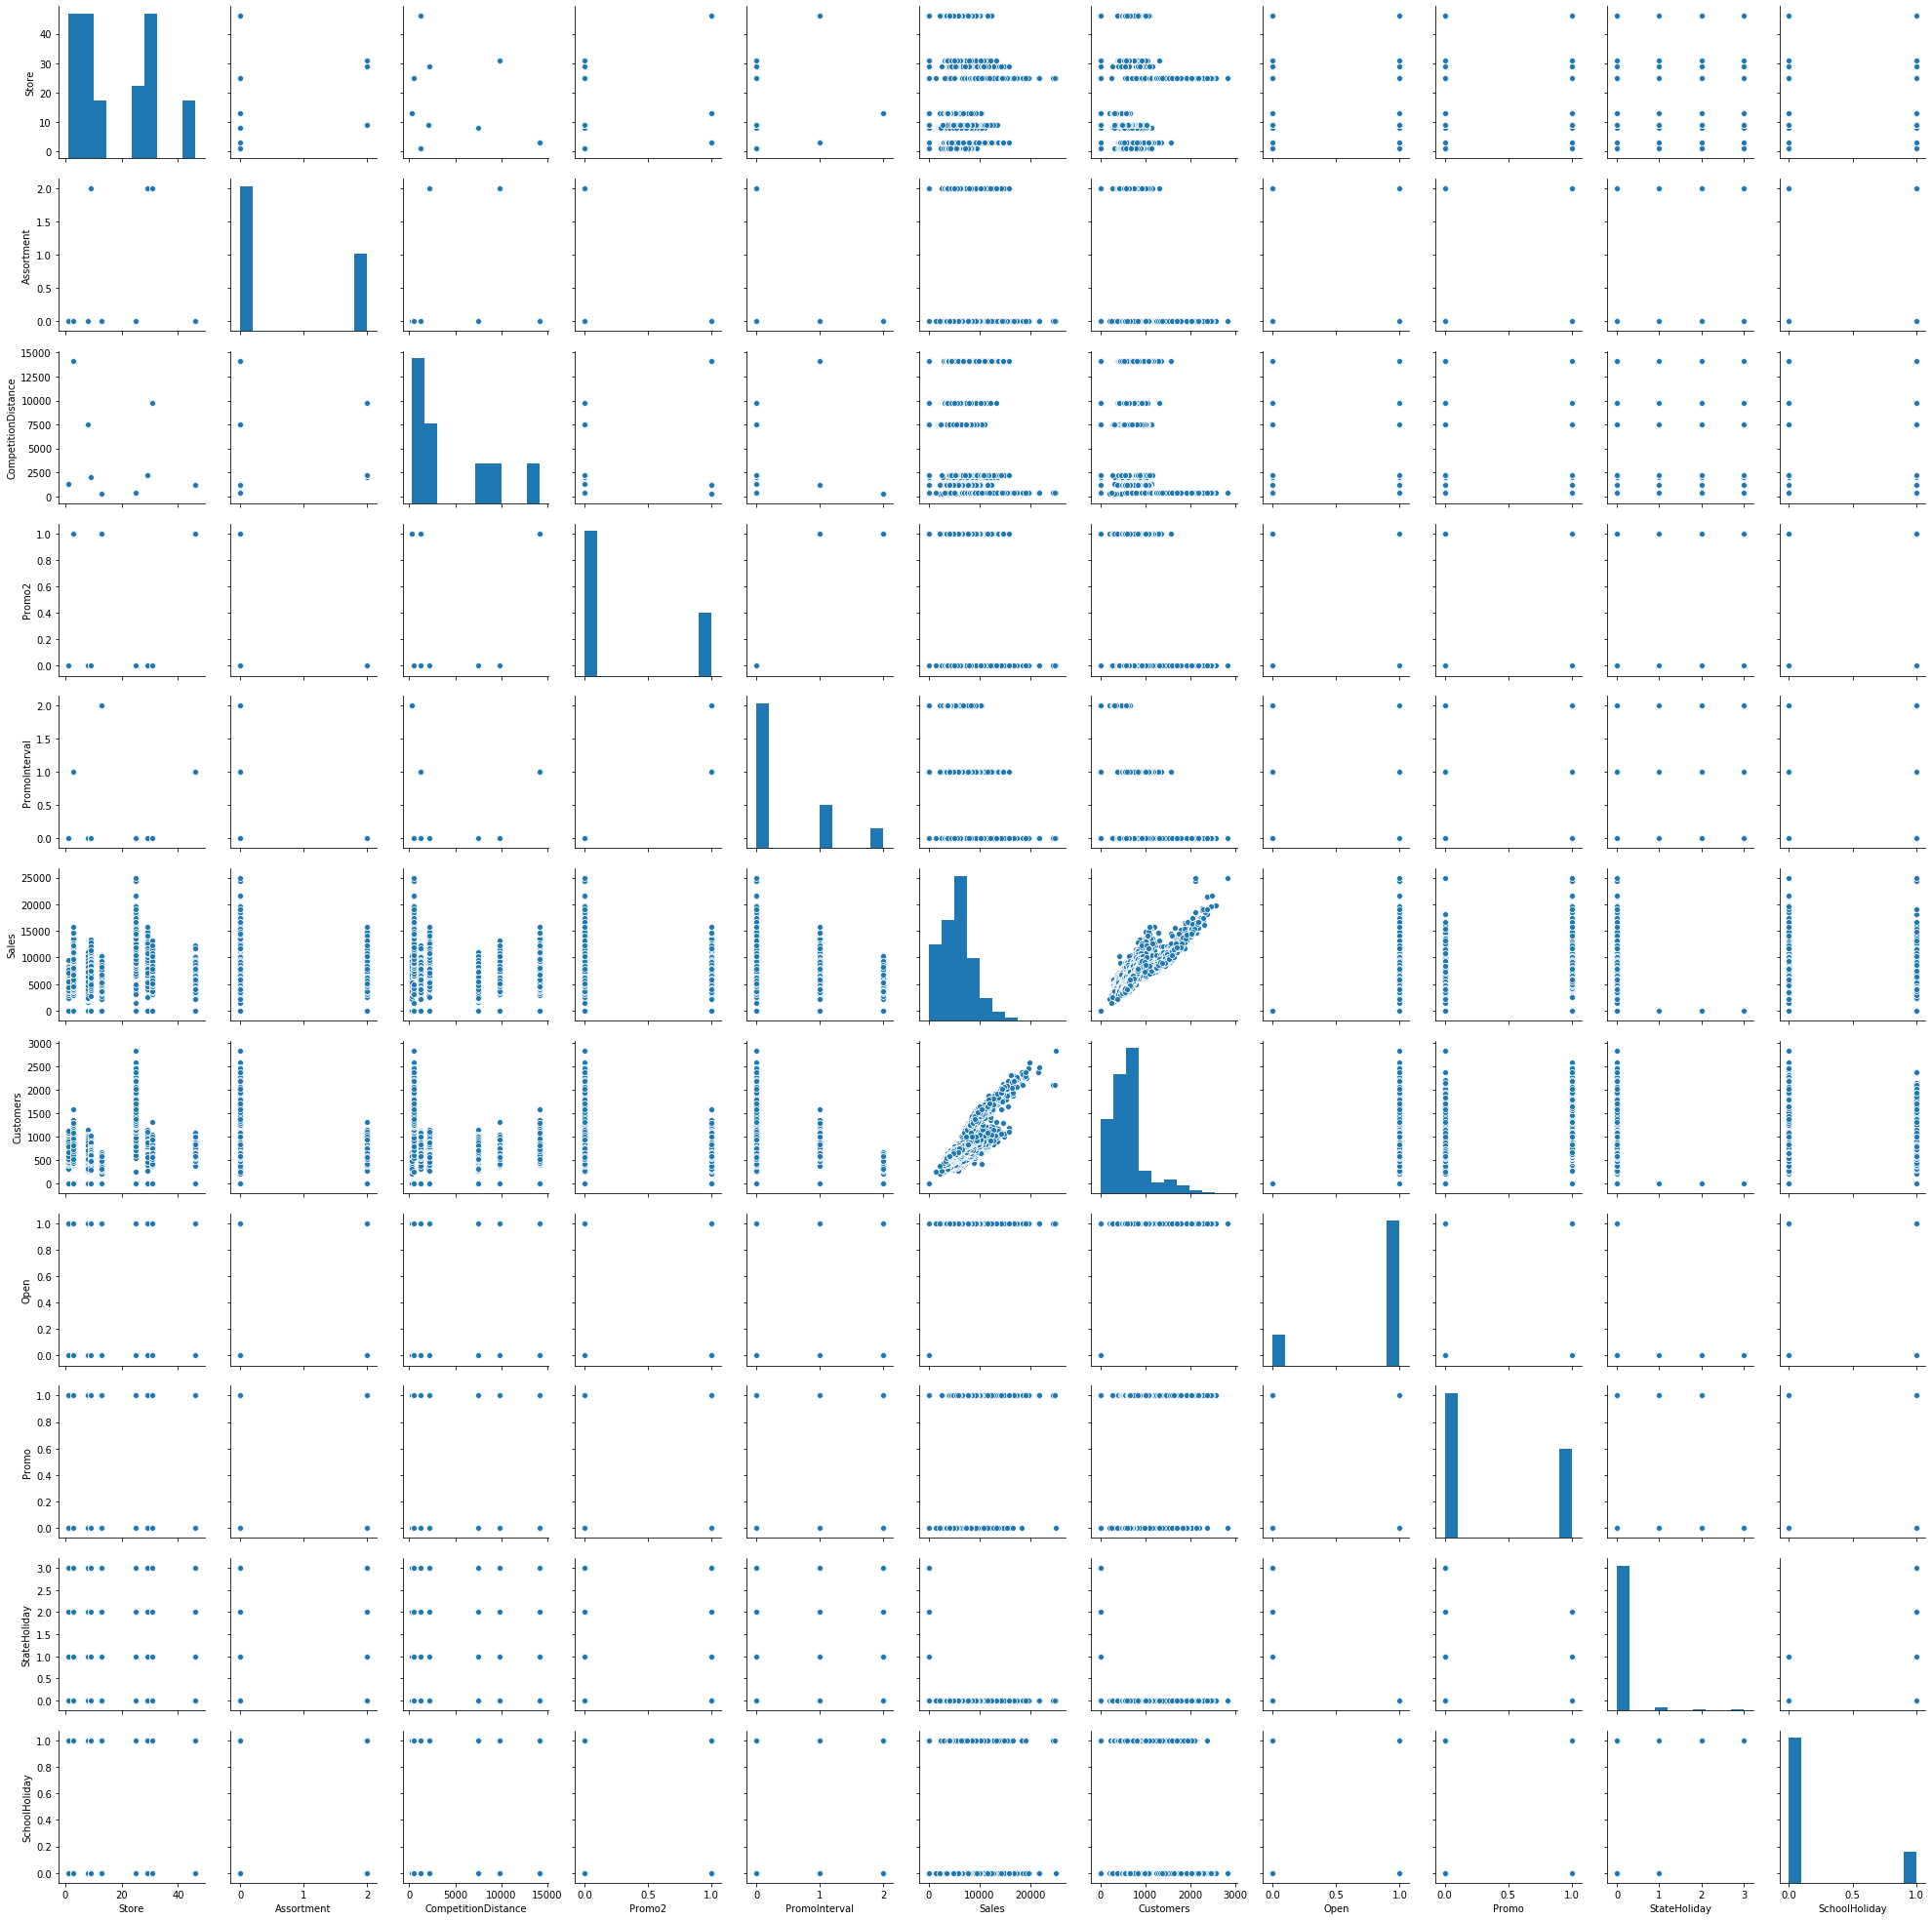

In [32]:
#visualization to show non-categorical variables
sns.pairplot(data)
plt.show()

#### As we can see Customers is linearly related to sales and it is understandable that number of customers is directly #### proportional to sales.
#### 'Open' and 'Promo' are the most important variables by ooking at the correlation.

plt.figure(figsize = (12, 12))
sns.heatmap(data_key.corr(), annot = True, cmap="YlGnBu")
plt.show()

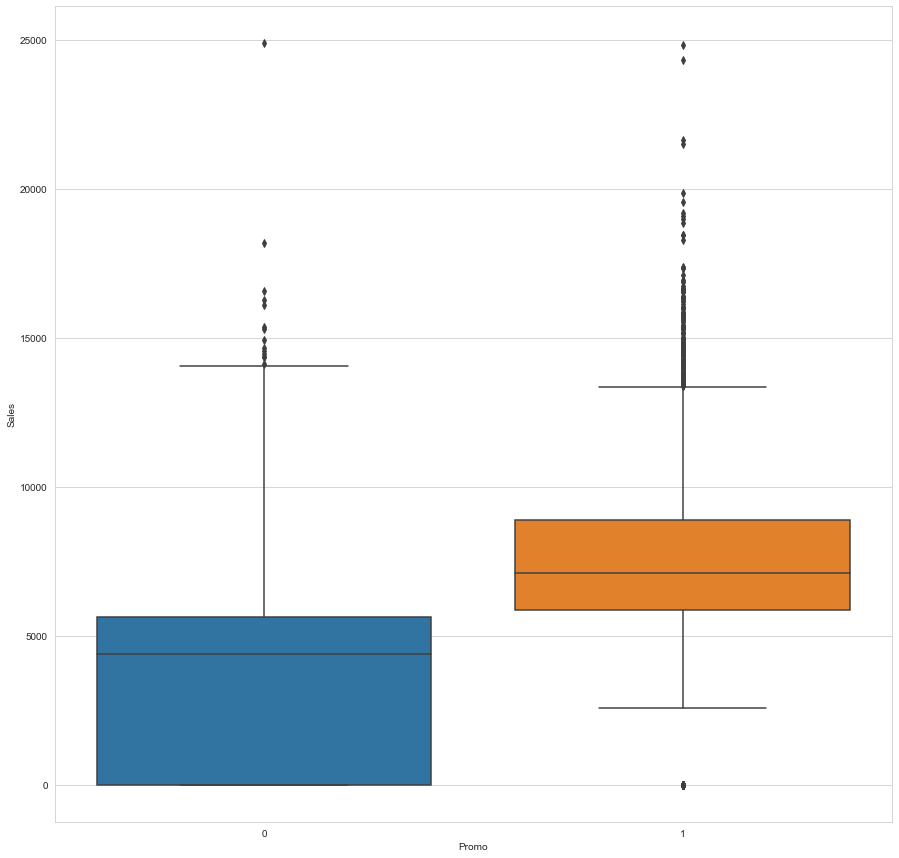

In [33]:

sns.set_style("whitegrid")

plt.figure(figsize=(15, 15))

sns.boxplot(x='Promo', y='Sales', data=data)

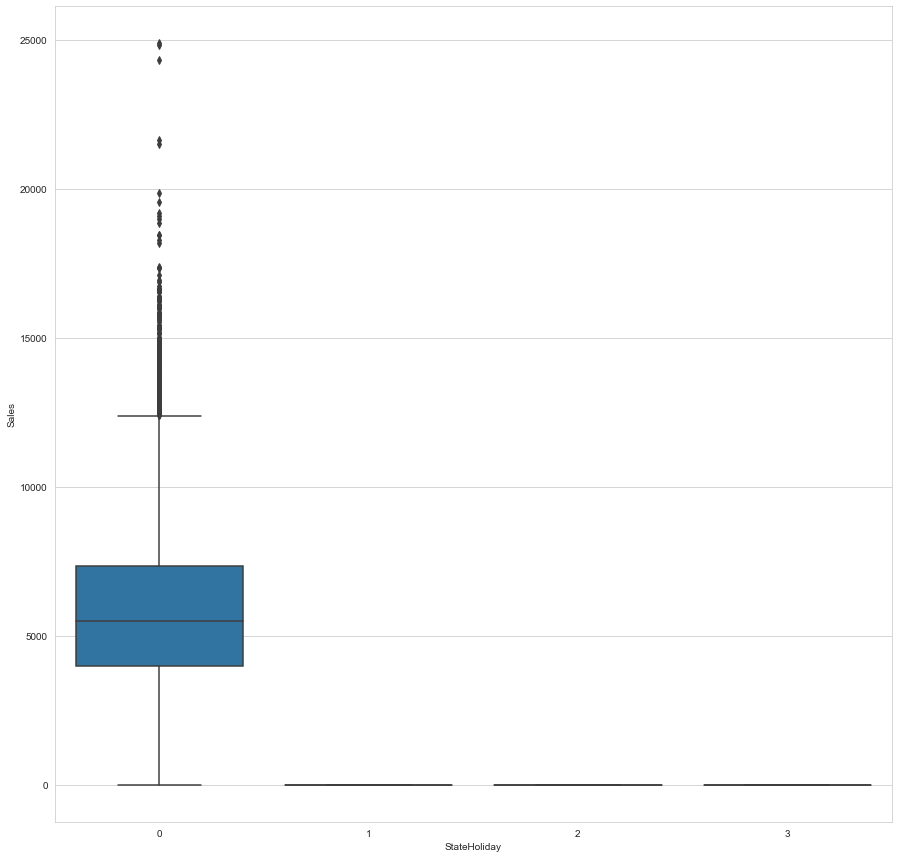

In [34]:
sns.set_style("whitegrid")

plt.figure(figsize=(15, 15))

sns.boxplot(x='StateHoliday', y='Sales', data=data)

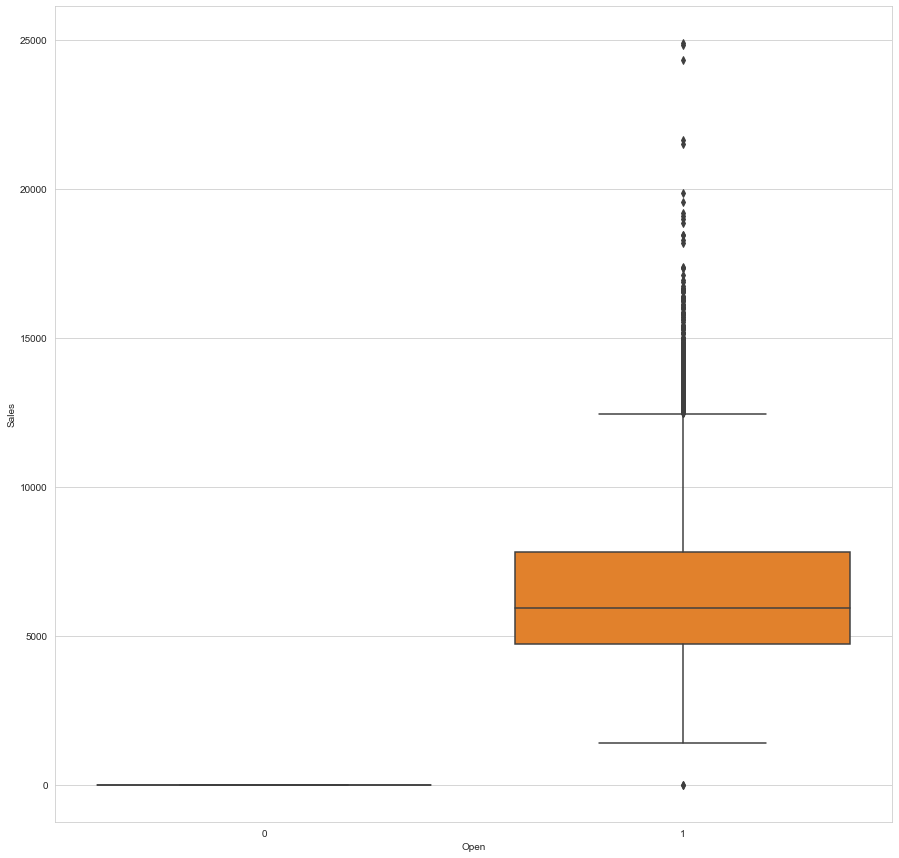

In [35]:

sns.set_style("whitegrid")

plt.figure(figsize=(15, 15))

sns.boxplot(x='Open', y='Sales', data=data)


#### As we can see Promo and State holiday and open clearly impact the Sales.

In [36]:
train = data.loc['2013-01-01': '2015-05-31']
test = data.loc[ '2015-06-01':]

## store 1


In [37]:
# getting data for store 1
store_1 = data[data.Store.isin([1])]

In [38]:
# Setting index as Date and sorting index to set freq as 'D' to model the data
store_1.index = store_1.Date
store_1=store_1.sort_index()
store_1.index.freq = store_1.index.inferred_freq
store_1.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2015-07-22', '2015-07-23', '2015-07-24', '2015-07-25',
               '2015-07-26', '2015-07-27', '2015-07-28', '2015-07-29',
               '2015-07-30', '2015-07-31'],
              dtype='datetime64[ns]', name='Date', length=942, freq='D')

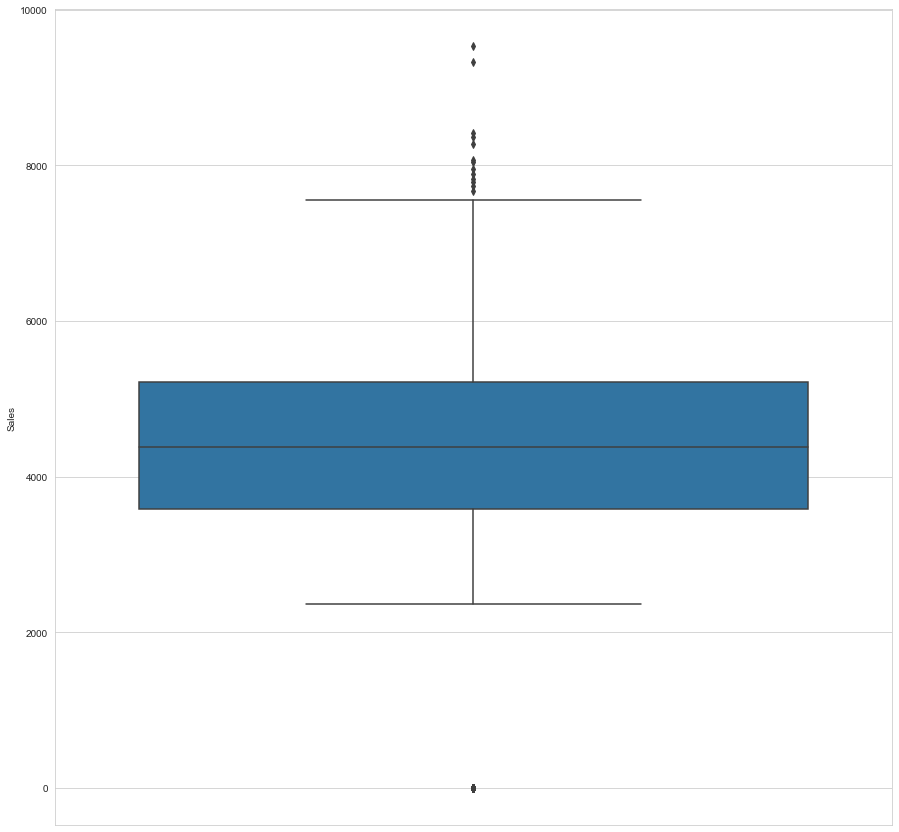

In [39]:
sns.set_style("whitegrid")

plt.figure(figsize=(15, 15))

sns.boxplot(y='Sales', data=store_1)

In [40]:
store_1.Sales.describe(percentiles = [0.01,0.10,0.25,0.50,0.75,0.90,0.95,0.99,0.995])

count     942.000000
mean     3945.704883
std      2015.417840
min         0.000000
1%          0.000000
10%         0.000000
25%      3588.250000
50%      4373.500000
75%      5220.000000
90%      5860.600000
95%      6380.800000
99%      7806.240000
99.5%    8130.360000
max      9528.000000
Name: Sales, dtype: float64

In [41]:
store_1[store_1.Sales>8500]

Store StoreType  Assortment  CompetitionDistance  Promo2  \
Date                                                                   
2013-12-23      1         c           0               1270.0       0   
2014-12-22      1         c           0               1270.0       0   

            PromoInterval       Date  Sales  Customers  Open  Promo  \
Date                                                                  
2013-12-23            0.0 2013-12-23   9528       1130     1      0   
2014-12-22            0.0 2014-12-22   9331       1080     1      0   

            StateHoliday  SchoolHoliday  
Date                                     
2013-12-23             0              1  
2014-12-22             0              1

In [42]:
store_1=store_1[store_1.Sales<8500]

In [43]:
store_1=store_1.append({'Store': 1,'StoreType' : 'c','Assortment':0,
                  'CompetitionDistance' : 1270,'Date' : '2014-12-22',
                   'Sales':1,'Customers':1,
                  'Open':1,'Promo':0,
                  'StateHoliday':0,'SchoolHoliday':1,
                  'Promo2':0,'PromoInterval':0},
                  ignore_index=True)

In [44]:
store_1=store_1.append({'Store': 1,'StoreType' : 'c','Assortment':0,
                  'CompetitionDistance' : 1270,'Date' : '2013-12-23',
                   'Sales':1,'Customers':1,
                  'Open':1,'Promo':0,
                  'StateHoliday':0,'SchoolHoliday':1,
                  'Promo2':0,'PromoInterval':0},
                  ignore_index=True)

In [45]:
store_1['Date'] = pd.to_datetime(store_1['Date'], format='%Y-%m')

In [46]:
store_1.index = store_1.Date
store_1=store_1.sort_index()
store_1.index.freq = store_1.index.inferred_freq
store_1.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2015-07-22', '2015-07-23', '2015-07-24', '2015-07-25',
               '2015-07-26', '2015-07-27', '2015-07-28', '2015-07-29',
               '2015-07-30', '2015-07-31'],
              dtype='datetime64[ns]', name='Date', length=942, freq='D')

In [47]:
# dividing data as train and test
train_1 = store_1.loc['2013-01-01': '2015-05-31']
test_1 = store_1.loc[ '2015-06-01':]

In [48]:
train_1.index


DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2015-05-22', '2015-05-23', '2015-05-24', '2015-05-25',
               '2015-05-26', '2015-05-27', '2015-05-28', '2015-05-29',
               '2015-05-30', '2015-05-31'],
              dtype='datetime64[ns]', name='Date', length=881, freq='D')

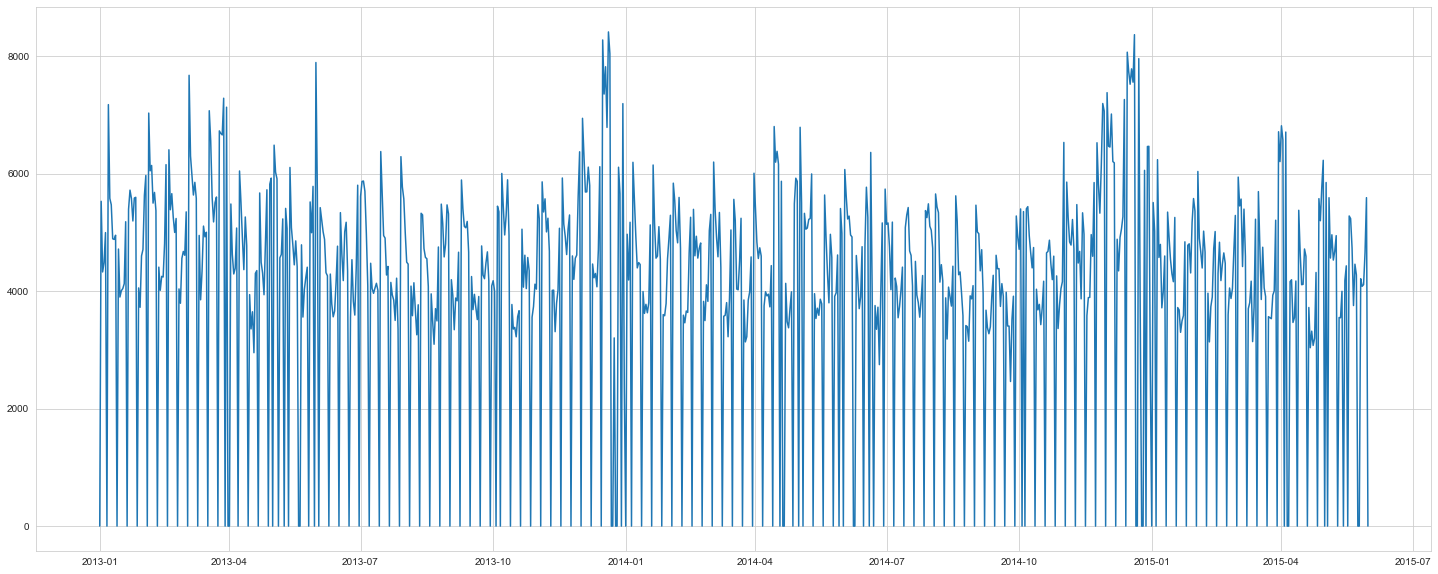

In [49]:
# plotting sales to identify any patterns
plt.figure(figsize=(25,10))
plt.plot(train_1['Sales'], label='Sales')

plt.show()

In [50]:
# A Dickey Fuller Test to identify stationarity
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train_1['Sales'].dropna())

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -4.345597
Critical Values @ 0.05: -2.86
p-value: 0.000370


##### p-value is < 0.05 the data is stationary

In [51]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train_1['Customers'].dropna())

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.703672
Critical Values @ 0.05: -2.86
p-value: 0.004062


##### p-value is < 0.05 the data is stationary - for customers

In [52]:
scaler = MinMaxScaler()
train_1[['Sales','Customers']] = scaler.fit_transform(train_1[['Sales','Customers']])

#### Using VAR to find better lag order

In [53]:
model = VAR(train_1[['Sales','Customers']])
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -9.558473355894293
BIC :  -9.525882979252437
FPE :  7.060050199588172e-05
HQIC:  -9.546010188842283 

Lag Order = 2
AIC :  -9.591197164319265
BIC :  -9.536831010761983
FPE :  6.832759006125803e-05
HQIC:  -9.570405403972048 

Lag Order = 3
AIC :  -9.60363647903129
BIC :  -9.52745532605761
FPE :  6.748293523962961e-05
HQIC:  -9.574500216975315 

Lag Order = 4
AIC :  -9.618368240746333
BIC :  -9.520332749454772
FPE :  6.649613052139387e-05
HQIC:  -9.580871520167248 

Lag Order = 5
AIC :  -9.669529011573932
BIC :  -9.549599726185118
FPE :  6.317977200081976e-05
HQIC:  -9.623655827055424 

Lag Order = 6
AIC :  -9.793664459148046
BIC :  -9.651801806524848
FPE :  5.580427459200039e-05
HQIC:  -9.739398756469646 

Lag Order = 7
AIC :  -10.537869333128143
BIC :  -10.374033622293284
FPE :  2.651333903901578e-05
HQIC:  -10.475195009061945 

Lag Order = 8
AIC :  -10.550149864536372
BIC :  -10.364301286187521
FPE :  2.6189813600204358e-05
HQIC:  -10.479050766642692 

Lag Order =

In [54]:
# Using 15 as lag order as even higher lag oder giving less AIC value
#exog = train['Promo2']
mod = sm.tsa.VARMAX(train_1[['Sales','Customers']], order=(15,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  881
Model:                            VAR(15)   Log Likelihood                2249.622
Date:                    Mon, 12 Apr 2021   AIC                          -4373.245
Time:                            12:02:42   BIC                          -4072.038
Sample:                        01-01-2013   HQIC                         -4258.064
                             - 05-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):               108.39, 46.51   Jarque-Bera (JB):       1851.99, 39.22
Prob(Q):                        0.00, 0.22   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.29, 1.02   Skew:                     -1.39, -0.15
Prob(H) (two-sided):            0.03, 0.86   Kurtosis:                   9.53, 3.99


In [55]:
#scaler = MinMaxScaler()
test_1[['Sales','Customers']] = scaler.fit_transform(test_1[['Sales','Customers']])

In [56]:
#Prdeicting the test values
#data_key_1.index = data_key_1.Date
start_index = test_1.index.min()
end_index = test_1.index.max()
print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index)




2015-06-01 00:00:00 2015-07-31 00:00:00


In [57]:
# inverse scaling the scaled values to normal values
train_1[['Sales','Customers']]=scaler.inverse_transform(train_1[['Sales','Customers']])
test_1[['Sales','Customers']] = scaler.inverse_transform(test_1[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])
#X.reshape(len(X),1)

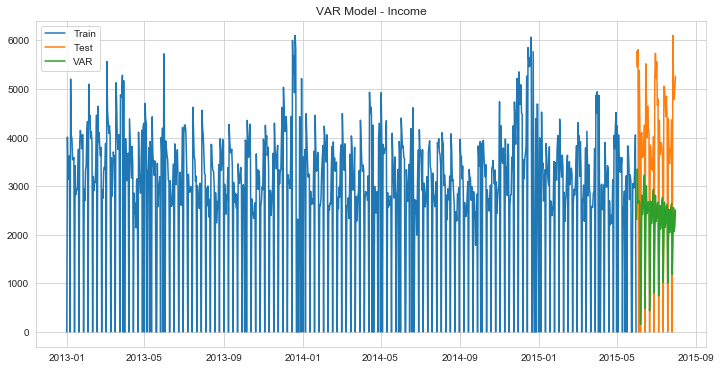

In [58]:
## plotting the final values
plt.figure(figsize=(12,6)) 
plt.plot( train_1['Sales'], label='Train')
plt.plot(test_1['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Income')
plt.show()

#### MAPE is giving inf values as sme of the sales values are zero hence using SMAPE

In [59]:
rmse = np.sqrt(mean_squared_error(test_1['Sales'], predictions['Sales'][test_1.index.min():])).round(2)
mape = np.round(np.mean(np.abs( test_1['Sales']-predictions['Sales'][test_1.index.min():])/((np.abs(test_1['Sales'])+ np.abs(predictions['Sales']))/2))*100,2)

#tempResults = pd.DataFrame({'Method':['VAR method'], 'RMSE': [rmse],'SMAPE': [mape] })
results = pd.DataFrame({'Method':['Naive method'], 'SMAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'SMAPE']]
results

Method     RMSE  SMAPE
0  Naive method  2085.18  79.18

## Future sales prediction VAR

In [60]:
# scaling the values using minmax scaler
scaler = MinMaxScaler()
store_1[['Sales','Customers']] = scaler.fit_transform(store_1[['Sales','Customers']])

In [61]:
store_1.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2015-07-22', '2015-07-23', '2015-07-24', '2015-07-25',
               '2015-07-26', '2015-07-27', '2015-07-28', '2015-07-29',
               '2015-07-30', '2015-07-31'],
              dtype='datetime64[ns]', name='Date', length=942, freq='D')

In [62]:
#Building a model for predicting furtire sales for next 6 weeks
#exog = train['Promo2']
mod = sm.tsa.VARMAX(store_1[['Sales','Customers']], order=(15,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  942
Model:                            VAR(15)   Log Likelihood                2427.609
Date:                    Mon, 12 Apr 2021   AIC                          -4729.218
Time:                            12:03:43   BIC                          -4423.794
Sample:                        01-01-2013   HQIC                         -4612.799
                             - 07-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):               122.62, 53.27   Jarque-Bera (JB):       2180.57, 41.62
Prob(Q):                        0.00, 0.08   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.38, 0.98   Skew:                     -1.46, -0.15
Prob(H) (two-sided):            0.00, 0.87   Kurtosis:                   9.86, 3.99


In [63]:
# Predicting the values
start_index = pd.to_datetime('2015-08-01', format='%Y-%m')
end_index = pd.to_datetime('2015-09-11', format='%Y-%m')
print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index)

2015-08-01 00:00:00 2015-09-11 00:00:00


In [64]:
#inverse transformation of the values
store_1[['Sales','Customers']]=scaler.inverse_transform(store_1[['Sales','Customers']])
#sorted_test[['Sales','Customers']] = scaler1.inverse_transform(sorted_test[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

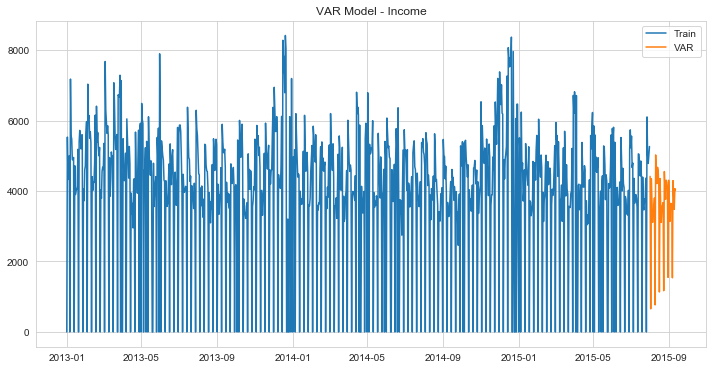

In [65]:
# Plotting the values
plt.figure(figsize=(12,6)) 
plt.plot( store_1['Sales'], label='Train')
#plt.plot(sorted_test['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Income')
plt.show()

In [66]:
"""
    Johansen cointegration test of the cointegration rank of a VECM

    Parameters
    ----------
    endog : array_like (nobs_tot x neqs)
        Data to test
    det_order : int
        * -1 - no deterministic terms - model1
        * 0 - constant term - model3
        * 1 - linear trend
    k_ar_diff : int, nonnegative
        Number of lagged differences in the model.
"""

def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

In [67]:
joh_model1 = coint_johansen(train_1[['Sales','Customers']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model1)

   max_eig_stat  trace_stat
0    143.411352  175.680817
1     32.269465   32.269465 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



#### trace_stat is grater than critical values even for 99% confidence interval .Hence the data is sationary and not coinegrated.Rank is 2

## Store 1 -VARMAX

In [68]:
scaler = MinMaxScaler()
train_1[['Sales','Customers']] = scaler.fit_transform(train_1[['Sales','Customers']])

In [69]:
# dividing data as train and test
train_1 = store_1.loc['2013-01-01': '2015-05-31']
test_1 = store_1.loc[ '2015-06-01':]

In [70]:
## using Promo and Open as exog variables as they have highest corelation
exog = train_1[['Promo','Open']]
mod = sm.tsa.VARMAX(train_1[['Sales','Customers']], order=(15,0), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  881
Model:                           VARX(15)   Log Likelihood              -11741.583
Date:                    Mon, 12 Apr 2021   AIC                          23617.166
Time:                            12:08:41   BIC                          23937.496
Sample:                        01-01-2013   HQIC                         23739.659
                             - 05-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):               107.42, 67.23   Jarque-Bera (JB):       1559.02, 37.01
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.34, 1.05   Skew:                     -1.28, -0.12
Prob(H) (two-sided):            0.01, 0.70   Kurtosis:                   8.99, 3.97


In [71]:
#data_key_1.index = data_key_1.Date
start_index = test_1.index.min()
end_index = test_1.index.max()
print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index,exog=test_1[['Promo','Open']])

2015-06-01 00:00:00 2015-07-31 00:00:00


In [72]:
train_1[['Sales','Customers']]=scaler.inverse_transform(train_1[['Sales','Customers']])
#test_1[['Sales','Customers']] = scaler.inverse_transform(test_1[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

In [73]:
test_1[['Sales','Customers']] = scaler.inverse_transform(test_1[['Sales','Customers']])

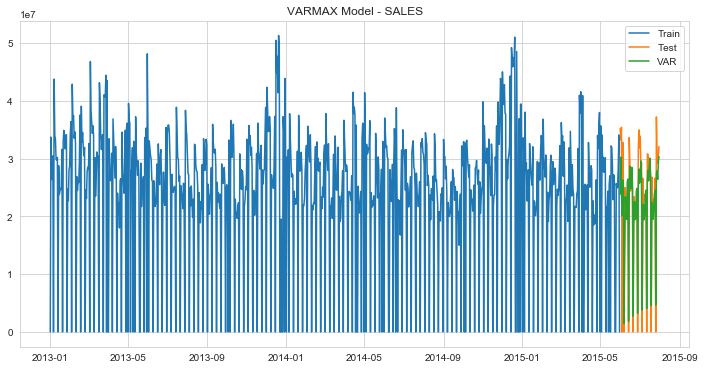

In [74]:
plt.figure(figsize=(12,6)) 
plt.plot( train_1['Sales'], label='Train')
plt.plot(test_1['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VARMAX Model - SALES')
plt.show()

In [75]:
rmse = np.sqrt(mean_squared_error(test_1['Sales'], predictions['Sales'][test_1.index.min():])).round(2)
mape = np.round(np.mean(np.abs( test_1['Sales']-predictions['Sales'][test_1.index.min():])/((np.abs(test_1['Sales'])+ np.abs(predictions['Sales']))/2))*100,2)

#tempResults = pd.DataFrame({'Method':['VAR method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.DataFrame({'Method':['Naive method'], 'SMAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'SMAPE']]
results

Method       RMSE  SMAPE
0  Naive method  5087619.9  40.52

## Predicting Future Values using VARMAX

In [76]:
store_1= train_1.append(test_1)
store_1

Store StoreType  Assortment  CompetitionDistance  Promo2  \
Date                                                                   
2013-01-01      1         c           0               1270.0       0   
2013-01-02      1         c           0               1270.0       0   
2013-01-03      1         c           0               1270.0       0   
2013-01-04      1         c           0               1270.0       0   
2013-01-05      1         c           0               1270.0       0   
...           ...       ...         ...                  ...     ...   
2015-07-27      1         c           0               1270.0       0   
2015-07-28      1         c           0               1270.0       0   
2015-07-29      1         c           0               1270.0       0   
2015-07-30      1         c           0               1270.0       0   
2015-07-31      1         c           0               1270.0       0   

            PromoInterval       Date       Sales  Customers  Open  Promo  \
Date                                                                       
2013-01-01            0.0 2013-01-01         0.0        0.0     0      0   
2013-01-02            0.0 2013-01-02  33744060.0   411488.0     1      0   
2013-01-03            0.0 2013-01-03  26403354.0   356048.0     1      0   
2013-01-04            0.0 2013-01-04  27373572.0   381304.0     1      0   
2013-01-05            0.0 2013-01-05  30491694.0   391160.0     1      0   
...                   ...        ...         ...        ...   ...    ...   
2015-07-27            0.0 2015-07-27  37234404.0   376992.0     1      1   
2015-07-28            0.0 2015-07-28  30577122.0   344960.0     1      1   
2015-07-29            0.0 2015-07-29  29179764.0   322168.0     1      1   
2015-07-30            0.0 2015-07-30  30632040.0   336336.0     1      1   
2015-07-31            0.0 2015-07-31  32114826.0   341880.0     1      1   

            StateHoliday  SchoolHoliday  
Date                                     
2013-01-01             1              1  
2013-01-02             0              1  
2013-01-03             0              1  
2013-01-04             0              1  
2013-01-05             0              1  
...                  ...            ...  
2015-07-27             0              1  
2015-07-28             0              1  
2015-07-29             0              1  
2015-07-30             0              1  
2015-07-31             0              1  

[942 rows x 13 columns]

#### For finding future sales using VARMAX we need to provide exog variables.If we look at the dataset given the Open column is 0 for day 7 and 1 for rest of the days Promo column is following a pattern of nine 0s and five 1s .So we can create these variables for next six weeks for all the stores .Using these we can find the future sales using VARMAX if not we cannot find them .StateHoliday and School Holiday need lot of researching depnding on stores country and holidays for that year .hence it is difficult to provide them .Using only Open and Promo for this project.


In [77]:


import datetime
future_date = pd.to_datetime('2015-07-31', format='%Y-%m')
open_counter = 6
promo_counter = 0
ex_variables = pd.DataFrame(columns = ['Date', 'Open', 'Promo'])
for i in range(42):
    
    future_date += datetime.timedelta(days=1)
    if (open_counter % 7) ==0 :
        #print(open_counter) 
        #open_counter =1 
        Open = 0
    else :
        Open =1
    if (promo_counter % 14) < 9:
        #print(promo_counter % 14 ) 
        Promo =0
    else:
        Promo =1
    open_counter = open_counter+1
    promo_counter = promo_counter +1
    ex_variables=ex_variables.append({'Date':future_date,'Open':Open,'Promo':Promo},ignore_index = True)

In [78]:
# USing the below exog_variables for all the stores
ex_variables

Date Open Promo
0  2015-08-01    1     0
1  2015-08-02    0     0
2  2015-08-03    1     0
3  2015-08-04    1     0
4  2015-08-05    1     0
5  2015-08-06    1     0
6  2015-08-07    1     0
7  2015-08-08    1     0
8  2015-08-09    0     0
9  2015-08-10    1     1
10 2015-08-11    1     1
11 2015-08-12    1     1
12 2015-08-13    1     1
13 2015-08-14    1     1
14 2015-08-15    1     0
15 2015-08-16    0     0
16 2015-08-17    1     0
17 2015-08-18    1     0
18 2015-08-19    1     0
19 2015-08-20    1     0
20 2015-08-21    1     0
21 2015-08-22    1     0
22 2015-08-23    0     0
23 2015-08-24    1     1
24 2015-08-25    1     1
25 2015-08-26    1     1
26 2015-08-27    1     1
27 2015-08-28    1     1
28 2015-08-29    1     0
29 2015-08-30    0     0
30 2015-08-31    1     0
31 2015-09-01    1     0
32 2015-09-02    1     0
33 2015-09-03    1     0
34 2015-09-04    1     0
35 2015-09-05    1     0
36 2015-09-06    0     0
37 2015-09-07    1     1
38 2015-09-08    1     1
39 2015-09-09    1     1
40 2015-09-10    1     1
41 2015-09-11    1     1

In [79]:
# Scaling the values of stores
scaler = MinMaxScaler()
store_1[['Sales','Customers']] = scaler.fit_transform(store_1[['Sales','Customers']])

In [80]:
store_1

Store StoreType  Assortment  CompetitionDistance  Promo2  \
Date                                                                   
2013-01-01      1         c           0               1270.0       0   
2013-01-02      1         c           0               1270.0       0   
2013-01-03      1         c           0               1270.0       0   
2013-01-04      1         c           0               1270.0       0   
2013-01-05      1         c           0               1270.0       0   
...           ...       ...         ...                  ...     ...   
2015-07-27      1         c           0               1270.0       0   
2015-07-28      1         c           0               1270.0       0   
2015-07-29      1         c           0               1270.0       0   
2015-07-30      1         c           0               1270.0       0   
2015-07-31      1         c           0               1270.0       0   

            PromoInterval       Date     Sales  Customers  Open  Promo  \
Date                                                                     
2013-01-01            0.0 2013-01-01  0.000000   0.000000     0      0   
2013-01-02            0.0 2013-01-02  0.657238   0.694387     1      0   
2013-01-03            0.0 2013-01-03  0.514262   0.600832     1      0   
2013-01-04            0.0 2013-01-04  0.533159   0.643451     1      0   
2013-01-05            0.0 2013-01-05  0.593891   0.660083     1      0   
...                   ...        ...       ...        ...   ...    ...   
2015-07-27            0.0 2015-07-27  0.725220   0.636175     1      1   
2015-07-28            0.0 2015-07-28  0.595555   0.582121     1      1   
2015-07-29            0.0 2015-07-29  0.568338   0.543659     1      1   
2015-07-30            0.0 2015-07-30  0.596625   0.567568     1      1   
2015-07-31            0.0 2015-07-31  0.625505   0.576923     1      1   

            StateHoliday  SchoolHoliday  
Date                                     
2013-01-01             1              1  
2013-01-02             0              1  
2013-01-03             0              1  
2013-01-04             0              1  
2013-01-05             0              1  
...                  ...            ...  
2015-07-27             0              1  
2015-07-28             0              1  
2015-07-29             0              1  
2015-07-30             0              1  
2015-07-31             0              1  

[942 rows x 13 columns]

In [81]:
#setting the index as Date and sorting the Date
ex_variables['Date'] = pd.to_datetime(ex_variables['Date'], format='%Y-%m')
ex_variables.index = ex_variables.Date
ex_variables.index.freq = ex_variables.index.inferred_freq
ex_variables.sort_index()
ex_variables['Open']=ex_variables['Open'].astype('int64')
ex_variables['Promo']=ex_variables['Promo'].astype('int64')
#ex_variables.Promo.astype('int')
ex_variables.dtypes

Date     datetime64[ns]
Open              int64
Promo             int64
dtype: object

In [82]:
exog = store_1[['Promo','Open']]
mod = sm.tsa.VARMAX(store_1[['Sales','Customers']], order=(15,0), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  942
Model:                           VARX(15)   Log Likelihood                3071.922
Date:                    Mon, 12 Apr 2021   AIC                          -6009.844
Time:                            12:15:23   BIC                          -5685.027
Sample:                        01-01-2013   HQIC                         -5886.033
                             - 07-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):              534.18, 189.22   Jarque-Bera (JB):      1159.96, 196.47
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.52, 1.00   Skew:                      0.11, -0.09
Prob(H) (two-sided):            0.00, 0.97   Kurtosis:                   8.43, 5.23


In [83]:
#predicting future sales using exog variables
start_index = ex_variables.index.min()
end_index = ex_variables.index.max()
print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index,exog=ex_variables[['Promo','Open']])

2015-08-01 00:00:00 2015-09-11 00:00:00


In [84]:
store_1[['Sales','Customers']]=scaler.inverse_transform(store_1[['Sales','Customers']])
#sorted_test[['Sales','Customers']] = scaler1.inverse_transform(sorted_test[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

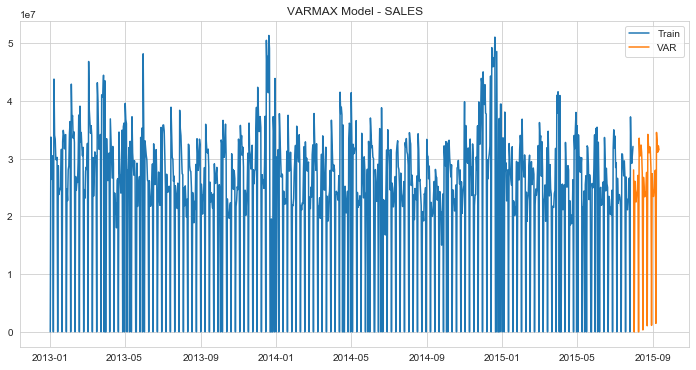

In [85]:
plt.figure(figsize=(12,6)) 
plt.plot( store_1['Sales'], label='Train')
#plt.plot(sorted_test['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VARMAX Model - SALES')
plt.show()

In [86]:
# Final Predicted Values
predictions['Sales']

2015-08-01    2.804785e+07
2015-08-02   -2.874805e+04
2015-08-03    2.609477e+07
2015-08-04    2.330526e+07
2015-08-05    2.249679e+07
2015-08-06    2.409519e+07
2015-08-07    2.465100e+07
2015-08-08    2.710191e+07
2015-08-09   -1.005049e+04
2015-08-10    3.354704e+07
2015-08-11    3.041692e+07
2015-08-12    3.153842e+07
2015-08-13    3.235968e+07
2015-08-14    3.103943e+07
2015-08-15    2.741587e+07
2015-08-16    3.261731e+05
2015-08-17    2.675631e+07
2015-08-18    2.473521e+07
2015-08-19    2.338630e+07
2015-08-20    2.422425e+07
2015-08-21    2.435945e+07
2015-08-22    2.761765e+07
2015-08-23    1.045188e+06
2015-08-24    3.420327e+07
2015-08-25    3.232981e+07
2015-08-26    3.101348e+07
2015-08-27    3.207215e+07
2015-08-28    3.135322e+07
2015-08-29    2.837335e+07
2015-08-30    1.113611e+06
2015-08-31    2.740105e+07
2015-09-01    2.542867e+07
2015-09-02    2.344149e+07
2015-09-03    2.435610e+07
2015-09-04    2.465026e+07
2015-09-05    2.799494e+07
2015-09-06    1.463092e+06
2

## store 3


In [87]:
# Getting values for store 3
store_3 = data[data.Store.isin([3])]


In [88]:
store_3.Sales.describe(percentiles = [0.01,0.10,0.25,0.50,0.75,0.90,0.95,0.99,0.995])

count      942.000000
mean      5741.253715
std       3298.782559
min          0.000000
1%           0.000000
10%          0.000000
25%       4247.500000
50%       5892.000000
75%       8152.750000
90%       9587.300000
95%      10481.050000
99%      12314.280000
99.5%    13506.220000
max      15689.000000
Name: Sales, dtype: float64

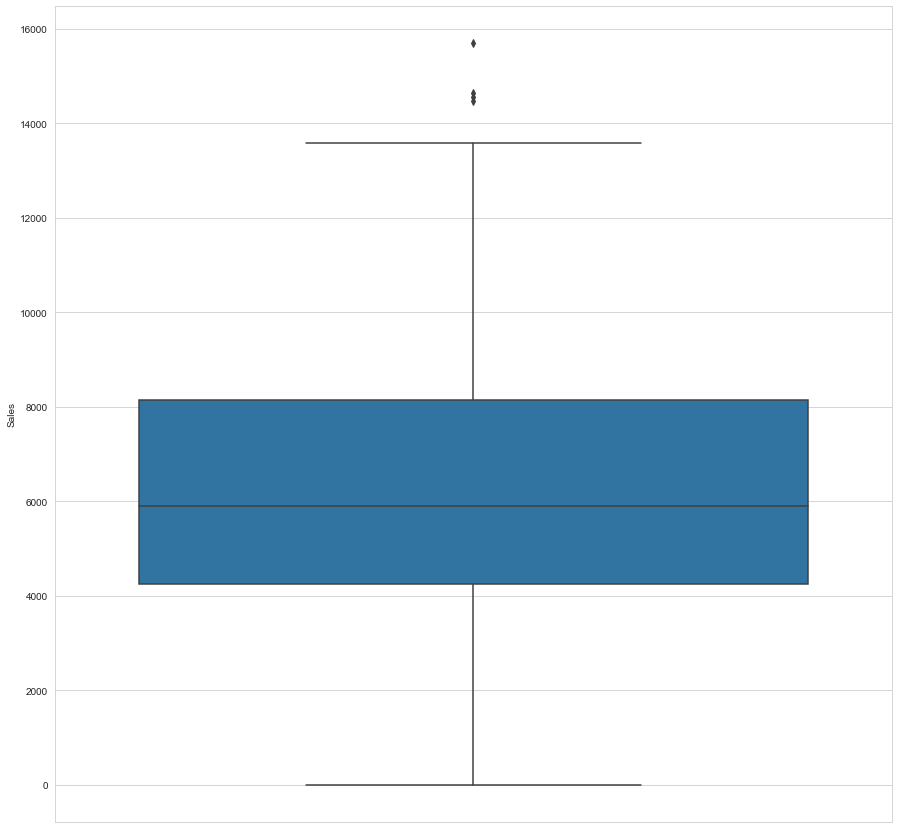

In [89]:
sns.set_style("whitegrid")

plt.figure(figsize=(15, 15))

sns.boxplot(y='Sales', data=store_3)

In [90]:
# As we can see there is an outlier so getting values less than 15000

In [91]:
store_3=store_3[store_3.Sales<15000]

#### There is one value which is very high than others and this value falls in more than 99% of complete data of all the stores.Hence deleting it and keeping other values

In [92]:
#Scaling the values 
scaler = MinMaxScaler()
store_3[['Sales','Customers']] = scaler.fit_transform(store_3[['Sales','Customers']])

In [93]:
store_3

Store StoreType  Assortment  CompetitionDistance  Promo2  PromoInterval  \
1884      3         a           0              14130.0       1            1.0   
1885      3         a           0              14130.0       1            1.0   
1886      3         a           0              14130.0       1            1.0   
1887      3         a           0              14130.0       1            1.0   
1888      3         a           0              14130.0       1            1.0   
...     ...       ...         ...                  ...     ...            ...   
2821      3         a           0              14130.0       1            1.0   
2822      3         a           0              14130.0       1            1.0   
2823      3         a           0              14130.0       1            1.0   
2824      3         a           0              14130.0       1            1.0   
2825      3         a           0              14130.0       1            1.0   

           Date     Sales  Customers  Open  Promo  StateHoliday  SchoolHoliday  
1884 2015-07-31  0.567625   0.519949     1      1             0              1  
1885 2015-07-30  0.612890   0.521216     1      1             0              1  
1886 2015-07-29  0.519560   0.453452     1      1             0              1  
1887 2015-07-28  0.605175   0.518049     1      1             0              1  
1888 2015-07-27  0.553492   0.486384     1      1             0              1  
...         ...       ...        ...   ...    ...           ...            ...  
2821 2013-01-05  0.308800   0.332489     1      0             0              0  
2822 2013-01-04  0.414351   0.436985     1      0             0              1  
2823 2013-01-03  0.402949   0.456618     1      0             0              1  
2824 2013-01-02  0.465829   0.509816     1      0             0              1  
2825 2013-01-01  0.000000   0.000000     0      0             1              1  

[941 rows x 13 columns]

#### We have deleted the outlier but it would break the continuity of the time series hence imputing it with Sales value of 1 as 
#### it would have highest value in a min max scaler

In [94]:
store_3=store_3.append({'Store': 3,'StoreType' : 'a','Assortment':0,
                  'CompetitionDistance' : 14130,'Date' : '2014-06-30',
                   'Sales':1,'Customers':1,
                  'Open':1,'Promo':0,
                  'StateHoliday':0,'SchoolHoliday':0,
                  'Promo2':1,'PromoInterval':0},
                  ignore_index=True)

In [95]:
store_3['Date'] = pd.to_datetime(store_3['Date'], format='%Y-%m')

In [96]:
store_3[store_3.Date=='2014-06-30']

Store StoreType  Assortment  CompetitionDistance  Promo2  PromoInterval  \
941      3         a           0              14130.0       1            0.0   

          Date  Sales  Customers  Open  Promo  StateHoliday  SchoolHoliday  
941 2014-06-30    1.0        1.0     1      0             0              0

In [97]:
store_3.index = store_3.Date
store_3=store_3.sort_index()

In [98]:
store_3

Store StoreType  Assortment  CompetitionDistance  Promo2  \
Date                                                                   
2013-01-01      3         a           0              14130.0       1   
2013-01-02      3         a           0              14130.0       1   
2013-01-03      3         a           0              14130.0       1   
2013-01-04      3         a           0              14130.0       1   
2013-01-05      3         a           0              14130.0       1   
...           ...       ...         ...                  ...     ...   
2015-07-27      3         a           0              14130.0       1   
2015-07-28      3         a           0              14130.0       1   
2015-07-29      3         a           0              14130.0       1   
2015-07-30      3         a           0              14130.0       1   
2015-07-31      3         a           0              14130.0       1   

            PromoInterval       Date     Sales  Customers  Open  Promo  \
Date                                                                     
2013-01-01            1.0 2013-01-01  0.000000   0.000000     0      0   
2013-01-02            1.0 2013-01-02  0.465829   0.509816     1      0   
2013-01-03            1.0 2013-01-03  0.402949   0.456618     1      0   
2013-01-04            1.0 2013-01-04  0.414351   0.436985     1      0   
2013-01-05            1.0 2013-01-05  0.308800   0.332489     1      0   
...                   ...        ...       ...        ...   ...    ...   
2015-07-27            1.0 2015-07-27  0.553492   0.486384     1      1   
2015-07-28            1.0 2015-07-28  0.605175   0.518049     1      1   
2015-07-29            1.0 2015-07-29  0.519560   0.453452     1      1   
2015-07-30            1.0 2015-07-30  0.612890   0.521216     1      1   
2015-07-31            1.0 2015-07-31  0.567625   0.519949     1      1   

            StateHoliday  SchoolHoliday  
Date                                     
2013-01-01             1              1  
2013-01-02             0              1  
2013-01-03             0              1  
2013-01-04             0              1  
2013-01-05             0              0  
...                  ...            ...  
2015-07-27             0              1  
2015-07-28             0              1  
2015-07-29             0              1  
2015-07-30             0              1  
2015-07-31             0              1  

[942 rows x 13 columns]

In [99]:
# Setting freq of the index
store_3.index.freq = store_3.index.inferred_freq

In [100]:
store_3.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2015-07-22', '2015-07-23', '2015-07-24', '2015-07-25',
               '2015-07-26', '2015-07-27', '2015-07-28', '2015-07-29',
               '2015-07-30', '2015-07-31'],
              dtype='datetime64[ns]', name='Date', length=942, freq='D')

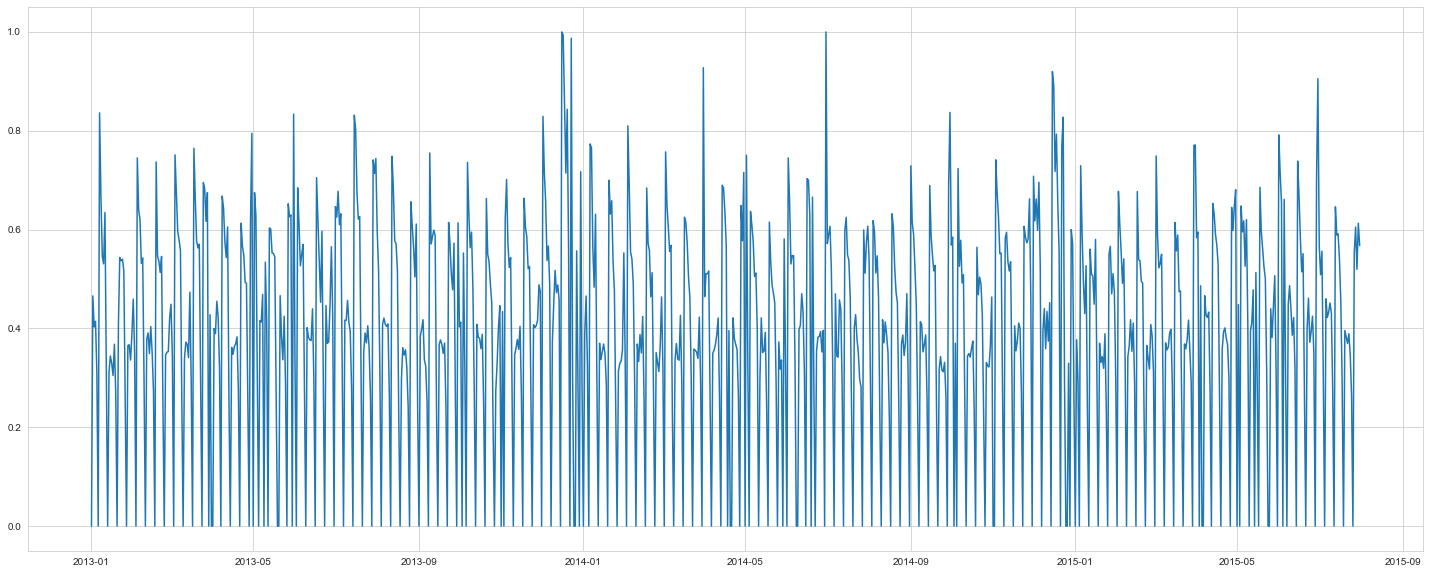

In [101]:
#Plotting Sales values and we clearly don't see a pattern
plt.figure(figsize=(25,10))
plt.plot(store_3['Sales'], label='Sales')

plt.show()

In [102]:
train_3 = store_3.loc['2013-01-01': '2015-05-31']
test_3 = store_3.loc[ '2015-06-01':]

In [103]:
train_3

Store StoreType  Assortment  CompetitionDistance  Promo2  \
Date                                                                   
2013-01-01      3         a           0              14130.0       1   
2013-01-02      3         a           0              14130.0       1   
2013-01-03      3         a           0              14130.0       1   
2013-01-04      3         a           0              14130.0       1   
2013-01-05      3         a           0              14130.0       1   
...           ...       ...         ...                  ...     ...   
2015-05-27      3         a           0              14130.0       1   
2015-05-28      3         a           0              14130.0       1   
2015-05-29      3         a           0              14130.0       1   
2015-05-30      3         a           0              14130.0       1   
2015-05-31      3         a           0              14130.0       1   

            PromoInterval       Date     Sales  Customers  Open  Promo  \
Date                                                                     
2013-01-01            1.0 2013-01-01  0.000000   0.000000     0      0   
2013-01-02            1.0 2013-01-02  0.465829   0.509816     1      0   
2013-01-03            1.0 2013-01-03  0.402949   0.456618     1      0   
2013-01-04            1.0 2013-01-04  0.414351   0.436985     1      0   
2013-01-05            1.0 2013-01-05  0.308800   0.332489     1      0   
...                   ...        ...       ...        ...   ...    ...   
2015-05-27            1.0 2015-05-27  0.381580   0.407853     1      0   
2015-05-28            1.0 2015-05-28  0.442070   0.428752     1      0   
2015-05-29            1.0 2015-05-29  0.506657   0.502217     1      0   
2015-05-30            1.0 2015-05-30  0.310098   0.290057     1      0   
2015-05-31            1.0 2015-05-31  0.000000   0.000000     0      0   

            StateHoliday  SchoolHoliday  
Date                                     
2013-01-01             1              1  
2013-01-02             0              1  
2013-01-03             0              1  
2013-01-04             0              1  
2013-01-05             0              0  
...                  ...            ...  
2015-05-27             0              0  
2015-05-28             0              0  
2015-05-29             0              0  
2015-05-30             0              0  
2015-05-31             0              0  

[881 rows x 13 columns]

In [104]:
test_3 

Store StoreType  Assortment  CompetitionDistance  Promo2  \
Date                                                                   
2015-06-01      3         a           0              14130.0       1   
2015-06-02      3         a           0              14130.0       1   
2015-06-03      3         a           0              14130.0       1   
2015-06-04      3         a           0              14130.0       1   
2015-06-05      3         a           0              14130.0       1   
...           ...       ...         ...                  ...     ...   
2015-07-27      3         a           0              14130.0       1   
2015-07-28      3         a           0              14130.0       1   
2015-07-29      3         a           0              14130.0       1   
2015-07-30      3         a           0              14130.0       1   
2015-07-31      3         a           0              14130.0       1   

            PromoInterval       Date     Sales  Customers  Open  Promo  \
Date                                                                     
2015-06-01            1.0 2015-06-01  0.791561   0.640912     1      1   
2015-06-02            1.0 2015-06-02  0.713798   0.619379     1      1   
2015-06-03            1.0 2015-06-03  0.654742   0.581381     1      1   
2015-06-04            1.0 2015-06-04  0.000000   0.000000     0      1   
2015-06-05            1.0 2015-06-05  0.661228   0.592147     1      1   
...                   ...        ...       ...        ...   ...    ...   
2015-07-27            1.0 2015-07-27  0.553492   0.486384     1      1   
2015-07-28            1.0 2015-07-28  0.605175   0.518049     1      1   
2015-07-29            1.0 2015-07-29  0.519560   0.453452     1      1   
2015-07-30            1.0 2015-07-30  0.612890   0.521216     1      1   
2015-07-31            1.0 2015-07-31  0.567625   0.519949     1      1   

            StateHoliday  SchoolHoliday  
Date                                     
2015-06-01             0              0  
2015-06-02             0              0  
2015-06-03             0              0  
2015-06-04             1              0  
2015-06-05             0              0  
...                  ...            ...  
2015-07-27             0              1  
2015-07-28             0              1  
2015-07-29             0              1  
2015-07-30             0              1  
2015-07-31             0              1  

[61 rows x 13 columns]

In [105]:
#finding p-values
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train_3['Sales'].dropna())

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -5.631001
Critical Values @ 0.05: -2.86
p-value: 0.000001


In [106]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train_3['Customers'].dropna())

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -5.287263
Critical Values @ 0.05: -2.86
p-value: 0.000006


#### The p-vales are less than 0.05 and the values are stationary w can reject null hypothesis

In [107]:
# finding lag order
model = VAR(train_3[['Sales','Customers']])
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -9.623440072158205
BIC :  -9.590849695516349
FPE :  6.615963532164825e-05
HQIC:  -9.610976905106195 

Lag Order = 2
AIC :  -9.676889962205305
BIC :  -9.622523808648022
FPE :  6.271626608384391e-05
HQIC:  -9.656098201858088 

Lag Order = 3
AIC :  -9.725615590537076
BIC :  -9.649434437563396
FPE :  5.9733657762259385e-05
HQIC:  -9.696479328481102 

Lag Order = 4
AIC :  -9.815194495119568
BIC :  -9.717159003828007
FPE :  5.461548791357727e-05
HQIC:  -9.777697774540483 

Lag Order = 5
AIC :  -10.022308892067914
BIC :  -9.9023796066791
FPE :  4.4398438777430734e-05
HQIC:  -9.976435707549406 

Lag Order = 6
AIC :  -10.07798050973908
BIC :  -9.936117857115882
FPE :  4.199432211697333e-05
HQIC:  -10.02371480706068 

Lag Order = 7
AIC :  -10.784002479878858
BIC :  -10.620166769044
FPE :  2.072860892091893e-05
HQIC:  -10.72132815581266 

Lag Order = 8
AIC :  -10.84365283221384
BIC :  -10.657804253864988
FPE :  1.952835620399935e-05
HQIC:  -10.772553734320159 

Lag Order = 9


In [108]:
#Building a model VAR
mod = sm.tsa.VARMAX(train_3[['Sales','Customers']], order=(15,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  881
Model:                            VAR(15)   Log Likelihood                2352.593
Date:                    Mon, 12 Apr 2021   AIC                          -4579.186
Time:                            12:17:18   BIC                          -4277.979
Sample:                        01-01-2013   HQIC                         -4464.005
                             - 05-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):               102.80, 32.09   Jarque-Bera (JB):       975.78, 208.70
Prob(Q):                        0.00, 0.81   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.00, 1.28   Skew:                     -0.74, -0.32
Prob(H) (two-sided):            0.98, 0.03   Kurtosis:                   7.94, 5.30


In [109]:
#predicting future sales
start_index = test_3.index.min()
end_index = test_3.index.max()
#print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index)

In [110]:
train_3[['Sales','Customers']]=scaler.inverse_transform(train_3[['Sales','Customers']])
test_3[['Sales','Customers']] = scaler.inverse_transform(test_3[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

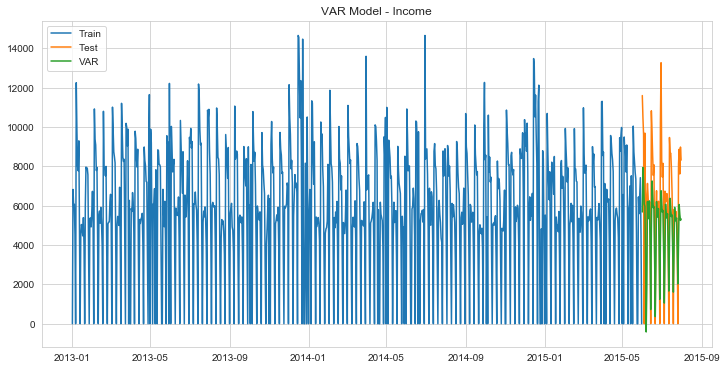

In [111]:
plt.figure(figsize=(12,6)) 
plt.plot( train_3['Sales'], label='Train')
plt.plot(test_3['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Income')
plt.show()

In [112]:
#Cointegration test
joh_model1 = coint_johansen(train_3[['Sales','Customers']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model1)

   max_eig_stat  trace_stat
0    137.359157  181.206544
1     43.847388   43.847388 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



#### the critical values are greater than trace_values at 99% confidence interval hence the series is stationary and not cointegrated

In [113]:
rmse = np.sqrt(mean_squared_error(test_3['Sales'], predictions['Sales'][test_3.index.min():])).round(2)
mape = np.round(np.mean(np.abs( test_3['Sales']-predictions['Sales'][test_3.index.min():])/((np.abs(test_3['Sales'])+ np.abs(predictions['Sales']))/2))*100,2)

#tempResults = pd.DataFrame({'Method':['VAR method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.DataFrame({'Method':['Naive method'], 'SMAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'SMAPE']]
results

Method     RMSE  SMAPE
0  Naive method  2610.05  55.23

#### predicting values for future 6 weeks

In [114]:
scaler = MinMaxScaler()
store_3[['Sales','Customers']] = scaler.fit_transform(store_3[['Sales','Customers']])

In [115]:
#exog = train['Promo2']
mod = sm.tsa.VARMAX(store_3[['Sales','Customers']], order=(15,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  942
Model:                            VAR(15)   Log Likelihood                2510.900
Date:                    Mon, 12 Apr 2021   AIC                          -4895.799
Time:                            12:17:58   BIC                          -4590.375
Sample:                        01-01-2013   HQIC                         -4779.381
                             - 07-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):               117.26, 36.13   Jarque-Bera (JB):      1066.51, 220.63
Prob(Q):                        0.00, 0.65   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.09, 1.40   Skew:                     -0.79, -0.28
Prob(H) (two-sided):            0.45, 0.00   Kurtosis:                   7.97, 5.30


In [116]:
#predicting future sales
start_index = ex_variables.index.min()
end_index = ex_variables.index.max()
#print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index)

In [117]:
# inverse transforming to actual scale
store_3[['Sales','Customers']]=scaler.inverse_transform(store_3[['Sales','Customers']])
#sorted_test[['Sales','Customers']] = scaler1.inverse_transform(sorted_test[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

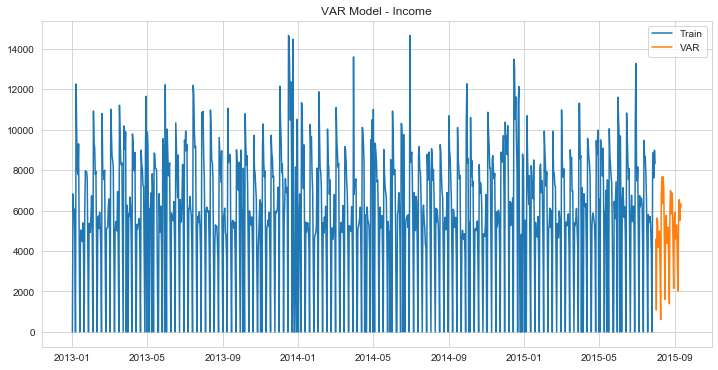

In [118]:
plt.figure(figsize=(12,6)) 
plt.plot( store_3['Sales'], label='Train')
#plt.plot(sorted_test['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Income')
plt.show()

In [119]:
#Final Sales
predictions['Sales']

2015-08-01    4585.860072
2015-08-02    1089.041441
2015-08-03    5637.370447
2015-08-04    5467.744449
2015-08-05    4183.412530
2015-08-06    4777.911913
2015-08-07    4984.751815
2015-08-08    3193.274115
2015-08-09     609.791137
2015-08-10    6724.784170
2015-08-11    7658.614297
2015-08-12    6333.649143
2015-08-13    7664.157571
2015-08-14    7104.391371
2015-08-15    4272.937588
2015-08-16    1609.768065
2015-08-17    5613.497362
2015-08-18    5767.429225
2015-08-19    4387.282643
2015-08-20    5086.181903
2015-08-21    5180.786741
2015-08-22    3211.428885
2015-08-23    1390.806026
2015-08-24    6132.267649
2015-08-25    6983.497313
2015-08-26    5836.745637
2015-08-27    6876.958076
2015-08-28    6566.894812
2015-08-29    4114.052881
2015-08-30    2149.392442
2015-08-31    5588.788031
2015-09-01    5902.878807
2015-09-02    4592.806152
2015-09-03    5278.302981
2015-09-04    5281.508888
2015-09-05    3337.334460
2015-09-06    2021.541945
2015-09-07    5780.742484
2015-09-08  

## VARMAX Model store 3

In [120]:
#Scaling the values 
scaler = MinMaxScaler()
store_3[['Sales','Customers']] = scaler.fit_transform(store_3[['Sales','Customers']])

In [121]:
train_3 = store_3.loc['2013-01-01': '2015-05-31']
test_3 = store_3.loc[ '2015-06-01':]

In [122]:
# Building a VARMAX model
exog = train_3[['Promo','Open']]
mod = sm.tsa.VARMAX(train_3[['Sales','Customers']], order=(15,1), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  881
Model:                       VARMAX(15,1)   Log Likelihood                3130.610
Date:                    Mon, 12 Apr 2021   AIC                          -6119.220
Time:                            12:26:07   BIC                          -5779.764
Sample:                        01-01-2013   HQIC                         -5989.413
                             - 05-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):               172.87, 80.39   Jarque-Bera (JB):      3535.31, 378.36
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.24, 1.08   Skew:                      1.45, -0.10
Prob(H) (two-sided):            0.07, 0.53   Kurtosis:                  12.38, 6.20


In [123]:
# predicting  sales for test
start_index = test_3.index.min()
end_index = test_3.index.max()
#print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index,exog=test_3[['Promo','Open']])

In [124]:
train_3[['Sales','Customers']]=scaler.inverse_transform(train_3[['Sales','Customers']])
test_3[['Sales','Customers']] = scaler.inverse_transform(test_3[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

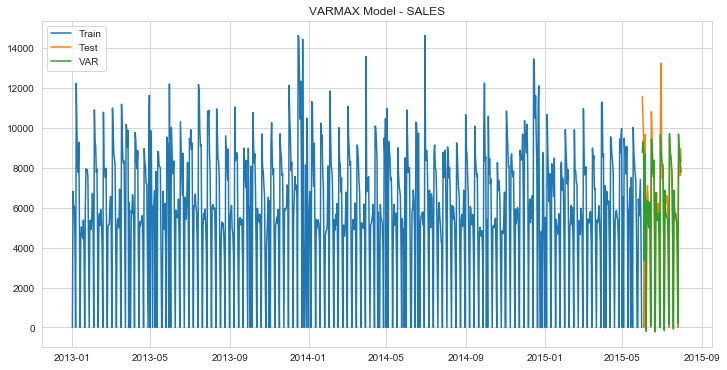

In [125]:
plt.figure(figsize=(12,6)) 
plt.plot( train_3['Sales'], label='Train')
plt.plot(test_3['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VARMAX Model - SALES')
plt.show()

In [126]:
rmse = np.sqrt(mean_squared_error(test_3['Sales'], predictions['Sales'][test_3.index.min():])).round(2)
mape = np.round(np.mean(np.abs( test_3['Sales']-predictions['Sales'][test_3.index.min():])/((np.abs(test_3['Sales'])+ np.abs(predictions['Sales']))/2))*100,2)

tempResults = pd.DataFrame({'Method':['VAR method'], 'RMSE': [rmse],'sMAPE': [mape] })
results = pd.DataFrame({'Method':['Naive method'], 'sMAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'sMAPE']]
results

Method     RMSE  sMAPE
0  Naive method  1003.42  37.39

#### Predicting Furture 6 weeks for Store 3 using VARMAX

In [127]:
scaler = MinMaxScaler()
store_3[['Sales','Customers']] = scaler.fit_transform(store_3[['Sales','Customers']])

In [128]:
exog = store_3[['Promo','Open']]
mod = sm.tsa.VARMAX(store_3[['Sales','Customers']], order=(15,1), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  942
Model:                       VARMAX(15,1)   Log Likelihood                3322.394
Date:                    Mon, 12 Apr 2021   AIC                          -6502.788
Time:                            12:37:03   BIC                          -6158.580
Sample:                        01-01-2013   HQIC                         -6371.586
                             - 07-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):              195.25, 116.87   Jarque-Bera (JB):      3684.61, 345.63
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.31, 1.29   Skew:                      1.44, -0.17
Prob(H) (two-sided):            0.02, 0.03   Kurtosis:                  12.25, 5.95


In [129]:
#prediction using ex_variables create by us for future six weeks
start_index = ex_variables.index.min()
end_index = ex_variables.index.max()

predictions = mod.fit().predict(start_index, end_index,exog=ex_variables[['Promo','Open']])

In [130]:
#inverse transforming to actual scale
store_3[['Sales','Customers']]=scaler.inverse_transform(store_3[['Sales','Customers']])

predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

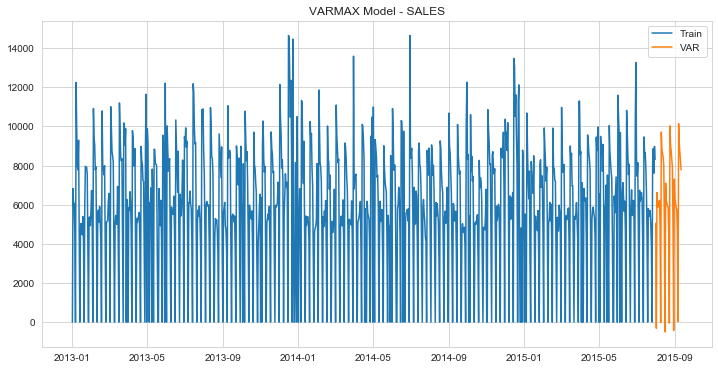

In [131]:
#plotting the final values
plt.figure(figsize=(12,6)) 
plt.plot( store_3['Sales'], label='Train')
#plt.plot(test_3['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VARMAX Model - SALES')
plt.show()

In [132]:
# Sales for next 6 weeks
predictions['Sales']

2015-08-01     5051.417601
2015-08-02     -313.199437
2015-08-03     6619.901219
2015-08-04     5866.043356
2015-08-05     5905.907216
2015-08-06     5945.613104
2015-08-07     6223.162271
2015-08-08     4962.219876
2015-08-09      -21.340886
2015-08-10     9710.331825
2015-08-11     8833.038774
2015-08-12     8604.358745
2015-08-13     8435.337376
2015-08-14     8013.867174
2015-08-15     4708.302965
2015-08-16     -504.138118
2015-08-17     7100.921398
2015-08-18     6205.463283
2015-08-19     6089.516370
2015-08-20     5915.201084
2015-08-21     5896.756742
2015-08-22     4675.255423
2015-08-23      -50.879672
2015-08-24    10027.158893
2015-08-25     9032.601340
2015-08-26     8715.881050
2015-08-27     8295.180413
2015-08-28     7845.025946
2015-08-29     4609.468319
2015-08-30     -431.275202
2015-08-31     7307.068762
2015-09-01     6320.767428
2015-09-02     6067.115601
2015-09-03     5861.124318
2015-09-04     5735.376094
2015-09-05     4637.101645
2015-09-06       29.319527
2

## Store 8


In [133]:
store_8 = data[data.Store.isin([8])]

In [134]:
store_8.Sales.describe(percentiles = [0.01,0.10,0.25,0.50,0.75,0.90,0.95,0.99,0.995])

count      942.000000
mean      4610.251592
std       2696.883772
min          0.000000
1%           0.000000
10%          0.000000
25%       2916.750000
50%       4919.000000
75%       6558.000000
90%       7963.800000
95%       8629.050000
99%       9914.040000
99.5%    10451.080000
max      10971.000000
Name: Sales, dtype: float64

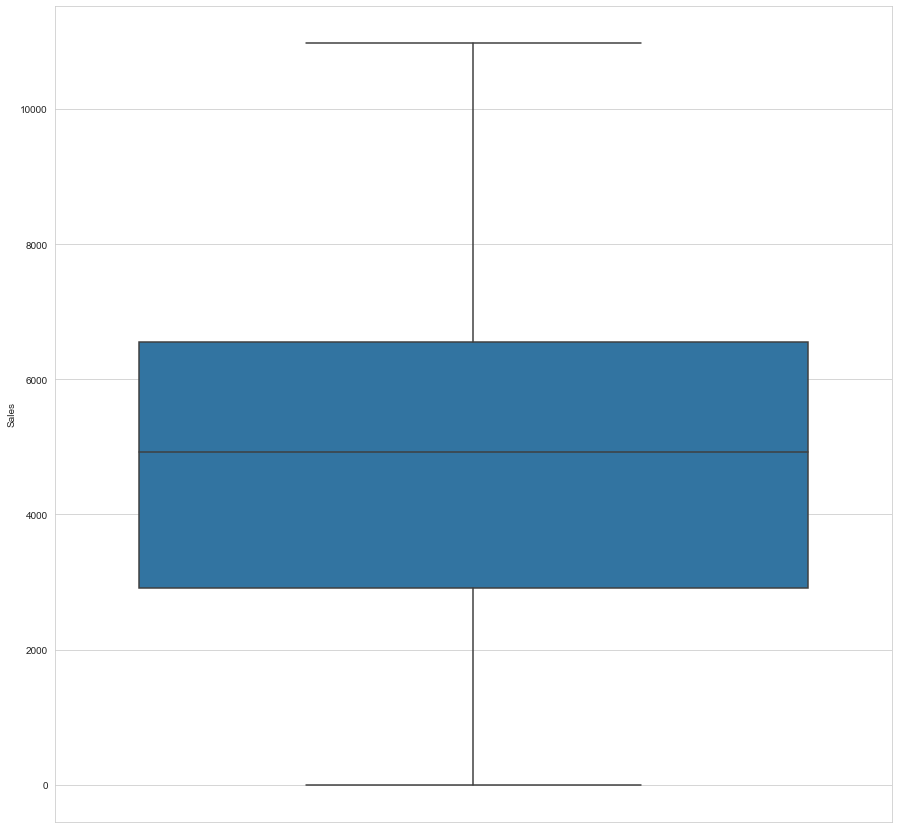

In [135]:
sns.set_style("whitegrid")

plt.figure(figsize=(15, 15))

sns.boxplot(y='Sales', data=store_8)

#### There are no out liers

In [136]:
scaler = MinMaxScaler()
store_8[['Sales','Customers']] = scaler.fit_transform(store_8[['Sales','Customers']])

In [137]:
store_8.index = store_8.Date
store_8=store_8.sort_index()
store_8.index.freq = store_8.index.inferred_freq
store_8.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2015-07-22', '2015-07-23', '2015-07-24', '2015-07-25',
               '2015-07-26', '2015-07-27', '2015-07-28', '2015-07-29',
               '2015-07-30', '2015-07-31'],
              dtype='datetime64[ns]', name='Date', length=942, freq='D')

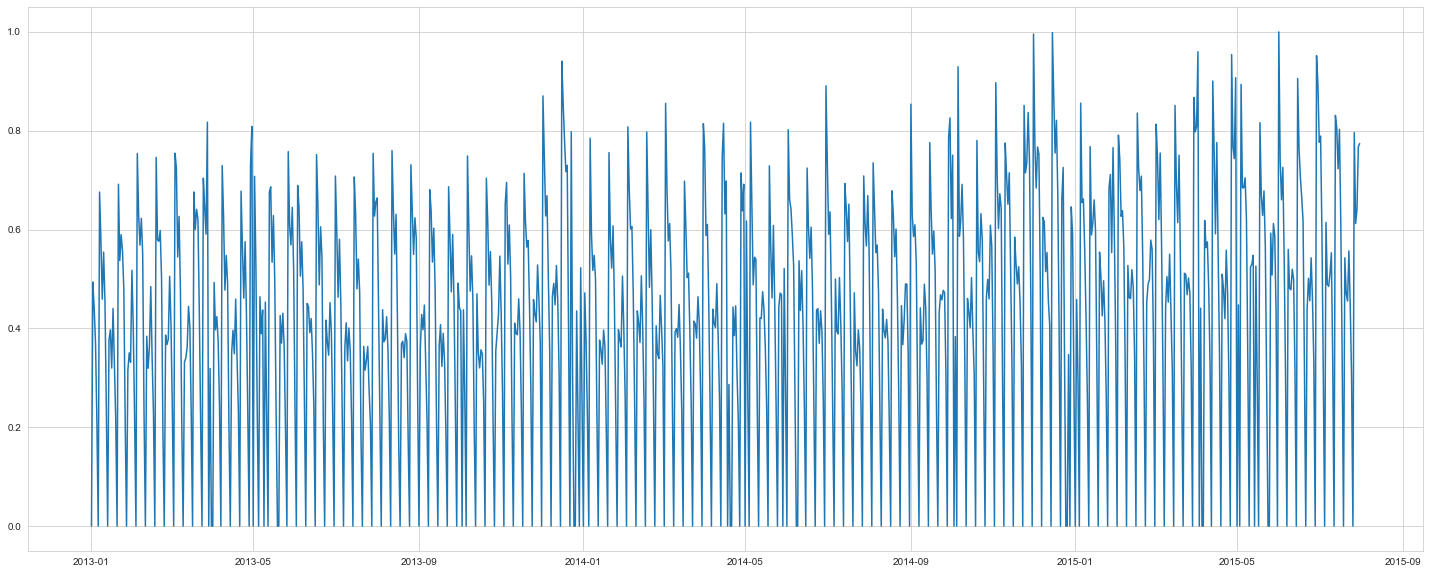

In [138]:
plt.figure(figsize=(25,10))
plt.plot(store_8['Sales'], label='Sales')

plt.show()

In [139]:
train_8 = store_8.loc['2013-01-01': '2015-05-31']
test_8 = store_8.loc[ '2015-06-01':]

In [140]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train_8['Sales'].dropna())

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.805817
Critical Values @ 0.05: -2.86
p-value: 0.002848


#### p-values are <0.05 Hence data is stationary for sales and customers

In [141]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train_8['Customers'].dropna())

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.958261
Critical Values @ 0.05: -2.86
p-value: 0.001646


In [142]:
model = VAR(train_8[['Sales','Customers']])
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -8.966784649256779
BIC :  -8.934194272614922
FPE :  0.0001275777473042177
HQIC:  -8.954321482204769 

Lag Order = 2
AIC :  -9.024765920194131
BIC :  -8.970399766636849
FPE :  0.00012039101251211796
HQIC:  -9.003974159846914 

Lag Order = 3
AIC :  -9.145865666605944
BIC :  -9.069684513632264
FPE :  0.00010665993194075265
HQIC:  -9.11672940454997 

Lag Order = 4
AIC :  -9.341915582748374
BIC :  -9.243880091456813
FPE :  8.767145978060848e-05
HQIC:  -9.304418862169289 

Lag Order = 5
AIC :  -9.496243327417115
BIC :  -9.376314042028302
FPE :  7.513375091524543e-05
HQIC:  -9.450370142898608 

Lag Order = 6
AIC :  -9.534276927897137
BIC :  -9.39241427527394
FPE :  7.23299292927097e-05
HQIC:  -9.480011225218737 

Lag Order = 7
AIC :  -10.30692094318398
BIC :  -10.143085232349122
FPE :  3.3401351266865436e-05
HQIC:  -10.244246619117783 

Lag Order = 8
AIC :  -10.338031710303719
BIC :  -10.152183131954867
FPE :  3.237830810064257e-05
HQIC:  -10.266932612410038 

Lag Order =

In [143]:
#Building a model
mod = sm.tsa.VARMAX(train_8[['Sales','Customers']], order=(15,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  881
Model:                            VAR(15)   Log Likelihood                2213.403
Date:                    Mon, 12 Apr 2021   AIC                          -4300.806
Time:                            12:40:29   BIC                          -3999.600
Sample:                        01-01-2013   HQIC                         -4185.626
                             - 05-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):                78.08, 48.06   Jarque-Bera (JB):      1741.12, 196.92
Prob(Q):                        0.00, 0.18   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.55, 1.49   Skew:                     -0.83, -0.46
Prob(H) (two-sided):            0.00, 0.00   Kurtosis:                   9.68, 5.13


In [144]:
# Predicting sales for test dates
start_index = test_8.index.min()
end_index = test_8.index.max()
#print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index)

In [145]:
# retrnsformation to original values
train_8[['Sales','Customers']]=scaler.inverse_transform(train_8[['Sales','Customers']])
test_8[['Sales','Customers']] = scaler.inverse_transform(test_8[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

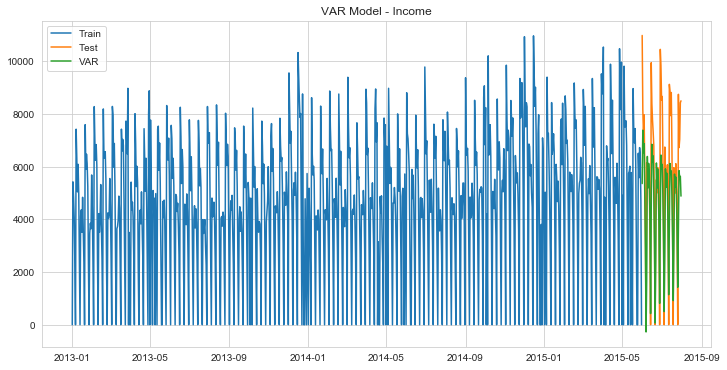

In [146]:
plt.figure(figsize=(12,6)) 
plt.plot( train_8['Sales'], label='Train')
plt.plot(test_8['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Income')
plt.show()

In [147]:
# Johansen test for cointegration
joh_model1 = coint_johansen(train_8[['Sales','Customers']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model1)

   max_eig_stat  trace_stat
0    152.612988  201.546704
1     48.933716   48.933716 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



In [148]:
rmse = np.sqrt(mean_squared_error(test_8['Sales'], predictions['Sales'][test_8.index.min():])).round(2)
smape = np.round(np.mean(np.abs( test_8['Sales']-predictions['Sales'][test_8.index.min():])/((np.abs(test_8['Sales'])+ np.abs(predictions['Sales']))/2))*100,2)

tempResults = pd.DataFrame({'Method':['VAR method'], 'RMSE': [rmse],'sMAPE': [smape] })
results = pd.DataFrame({'Method':['Naive method'], 'sMAPE': [smape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'sMAPE']]
results

Method     RMSE  sMAPE
0  Naive method  2243.77   50.4

## VAR model for Store 8 to predict future 6 weeks sale

In [149]:
scaler = MinMaxScaler()
store_8[['Sales','Customers']] = scaler.fit_transform(store_8[['Sales','Customers']])

In [150]:
#exog = train['Promo2']
mod = sm.tsa.VARMAX(store_8[['Sales','Customers']], order=(15,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  942
Model:                            VAR(15)   Log Likelihood                2378.832
Date:                    Mon, 12 Apr 2021   AIC                          -4631.665
Time:                            12:42:09   BIC                          -4326.241
Sample:                        01-01-2013   HQIC                         -4515.246
                             - 07-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):                95.35, 50.60   Jarque-Bera (JB):      1987.19, 206.39
Prob(Q):                        0.00, 0.12   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.64, 1.53   Skew:                     -0.83, -0.45
Prob(H) (two-sided):            0.00, 0.00   Kurtosis:                   9.92, 5.11


In [151]:
#prediction using ex_ variables we have created for future 6 weeks
start_index = ex_variables.index.min()
end_index = ex_variables.index.max()
#print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index)

In [152]:
# inverse transformation to original values
store_8[['Sales','Customers']]=scaler.inverse_transform(store_8[['Sales','Customers']])
#sorted_test[['Sales','Customers']] = scaler1.inverse_transform(sorted_test[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

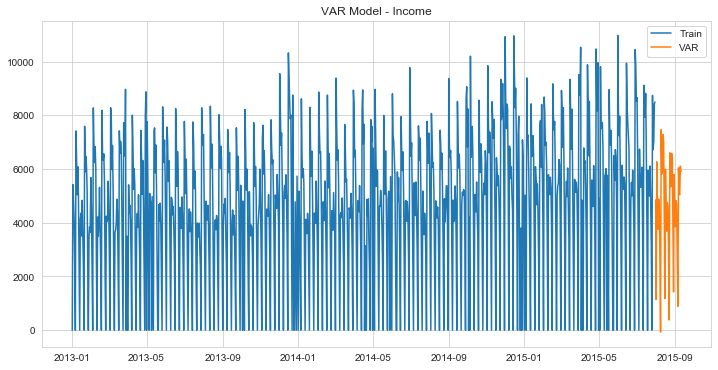

In [153]:
plt.figure(figsize=(12,6)) 
plt.plot( store_8['Sales'], label='Train')
#plt.plot(sorted_test['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Income')
plt.show()

## VARMAX model Store 8

In [154]:
# Scaling store 8 data 
scaler = MinMaxScaler()
store_8[['Sales','Customers']] = scaler.fit_transform(store_8[['Sales','Customers']])

In [155]:
train_8 = store_8.loc['2013-01-01': '2015-05-31']
test_8 = store_8.loc[ '2015-06-01':]

In [156]:
# Building a model
exog = train_8[['Promo','Open']]
mod = sm.tsa.VARMAX(train_8[['Sales','Customers']], order=(15,0), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  881
Model:                           VARX(15)   Log Likelihood                2933.991
Date:                    Mon, 12 Apr 2021   AIC                          -5733.982
Time:                            12:47:15   BIC                          -5413.651
Sample:                        01-01-2013   HQIC                         -5611.488
                             - 05-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):               430.73, 93.73   Jarque-Bera (JB):        69.78, 179.18
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.71, 1.34   Skew:                      0.24, -0.29
Prob(H) (two-sided):            0.00, 0.01   Kurtosis:                   4.29, 5.13


In [157]:
## Predicting values for test data dates
start_index = test_8.index.min()
end_index = test_8.index.max()
#print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index,exog=test_8[['Promo','Open']])

In [158]:
# inverse transformation of values
train_8[['Sales','Customers']]=scaler.inverse_transform(train_8[['Sales','Customers']])
test_8[['Sales','Customers']] = scaler.inverse_transform(test_8[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

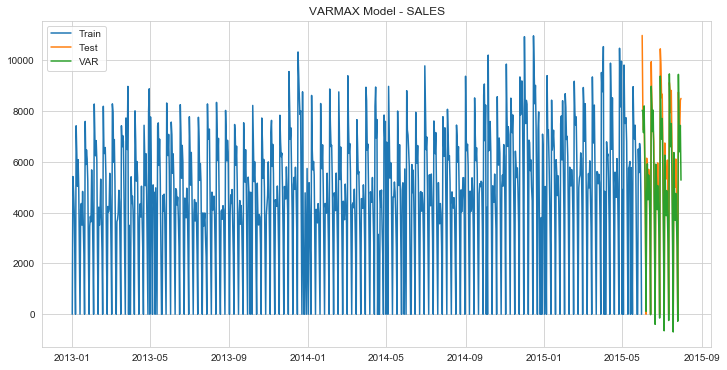

In [159]:
plt.figure(figsize=(12,6)) 
plt.plot( train_8['Sales'], label='Train')
plt.plot(test_8['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VARMAX Model - SALES')
plt.show()

In [160]:
rmse = np.sqrt(mean_squared_error(test_8['Sales'], predictions['Sales'][test_8.index.min():])).round(2)
smape = np.round(np.mean(np.abs( test_8['Sales']-predictions['Sales'][test_8.index.min():])/((np.abs(test_8['Sales'])+ np.abs(predictions['Sales']))/2))*100,2)

tempResults = pd.DataFrame({'Method':['VAR method'], 'RMSE': [rmse],'sMAPE': [smape] })
results = pd.DataFrame({'Method':['Naive method'], 'sMAPE': [smape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'sMAPE']]
results

Method     RMSE  sMAPE
0  Naive method  1030.37  39.67

## VARMAX for future sales prediction

In [161]:
# Scaling store 8 data 
scaler = MinMaxScaler()
store_8[['Sales','Customers']] = scaler.fit_transform(store_8[['Sales','Customers']])

In [162]:
exog = store_8[['Promo','Open']]
mod = sm.tsa.VARMAX(store_8[['Sales','Customers']], order=(15,0), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  942
Model:                           VARX(15)   Log Likelihood                3124.589
Date:                    Mon, 12 Apr 2021   AIC                          -6115.178
Time:                            12:53:17   BIC                          -5790.361
Sample:                        01-01-2013   HQIC                         -5991.367
                             - 07-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):               387.37, 87.48   Jarque-Bera (JB):        60.20, 153.15
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.61, 1.37   Skew:                      0.16, -0.23
Prob(H) (two-sided):            0.00, 0.01   Kurtosis:                   4.19, 4.92


In [163]:
# predicting future sales using exog variables create by us
start_index = ex_variables.index.min()
end_index = ex_variables.index.max()
#print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index,exog=ex_variables[['Promo','Open']])

In [164]:
# Inverse transforming to original values fo sales
store_8[['Sales','Customers']]=scaler.inverse_transform(store_8[['Sales','Customers']])
#test_8[['Sales','Customers']] = scaler.inverse_transform(test_8[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

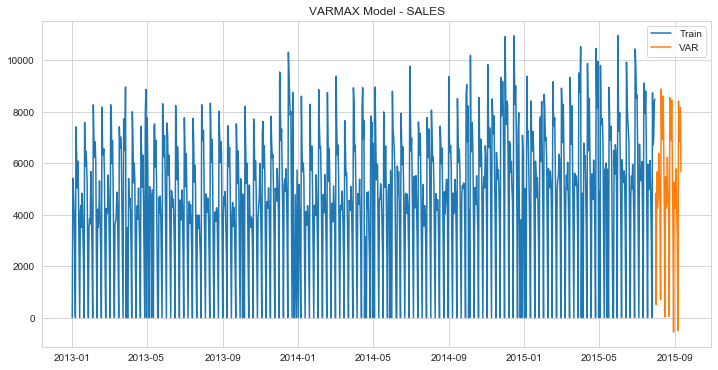

In [165]:
# plot the sales
plt.figure(figsize=(12,6)) 
plt.plot( store_8['Sales'], label='Train')
#plt.plot(test_8['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VARMAX Model - SALES')
plt.show()

In [166]:
predictions['Sales']

2015-08-01    4831.696436
2015-08-02     502.852079
2015-08-03    5661.151574
2015-08-04    4254.948582
2015-08-05    4609.057241
2015-08-06    6387.369404
2015-08-07    5449.922664
2015-08-08    4453.846115
2015-08-09     695.336857
2015-08-10    8885.599974
2015-08-11    6996.538042
2015-08-12    6922.361112
2015-08-13    8616.991087
2015-08-14    6950.529453
2015-08-15    4269.882126
2015-08-16      24.090049
2015-08-17    5472.459407
2015-08-18    4260.397576
2015-08-19    4588.247817
2015-08-20    6229.927565
2015-08-21    4863.693987
2015-08-22    3931.026535
2015-08-23      46.146729
2015-08-24    8552.112004
2015-08-25    7087.424916
2015-08-26    6909.579565
2015-08-27    8452.691159
2015-08-28    6175.287006
2015-08-29    3545.444842
2015-08-30    -561.954029
2015-08-31    5270.534413
2015-09-01    4249.451207
2015-09-02    4389.941853
2015-09-03    5780.720797
2015-09-04    4256.022476
2015-09-05    3254.722469
2015-09-06    -502.276234
2015-09-07    8414.636298
2015-09-08  

## Store 9

In [167]:
#Getting details for store 9
store_9 = data[data.Store.isin([9])]

In [168]:
store_9.Sales.describe(percentiles = [0.01,0.10,0.25,0.50,0.75,0.90,0.95,0.99,0.995])

count      942.000000
mean      5426.816348
std       2891.687966
min          0.000000
1%           0.000000
10%          0.000000
25%       4765.500000
50%       5904.500000
75%       7086.750000
90%       8483.400000
95%       9513.950000
99%      11548.880000
99.5%    11868.595000
max      13457.000000
Name: Sales, dtype: float64

In [169]:
store_9[store_9.Sales>12500]

Store StoreType  Assortment  CompetitionDistance  Promo2  PromoInterval  \
7568      9         a           2               2030.0       0            0.0   
7764      9         a           2               2030.0       0            0.0   

           Date  Sales  Customers  Open  Promo  StateHoliday  SchoolHoliday  
7568 2015-06-29  13457        882     1      1             0              1  
7764 2014-12-15  12767        834     1      1             0              0

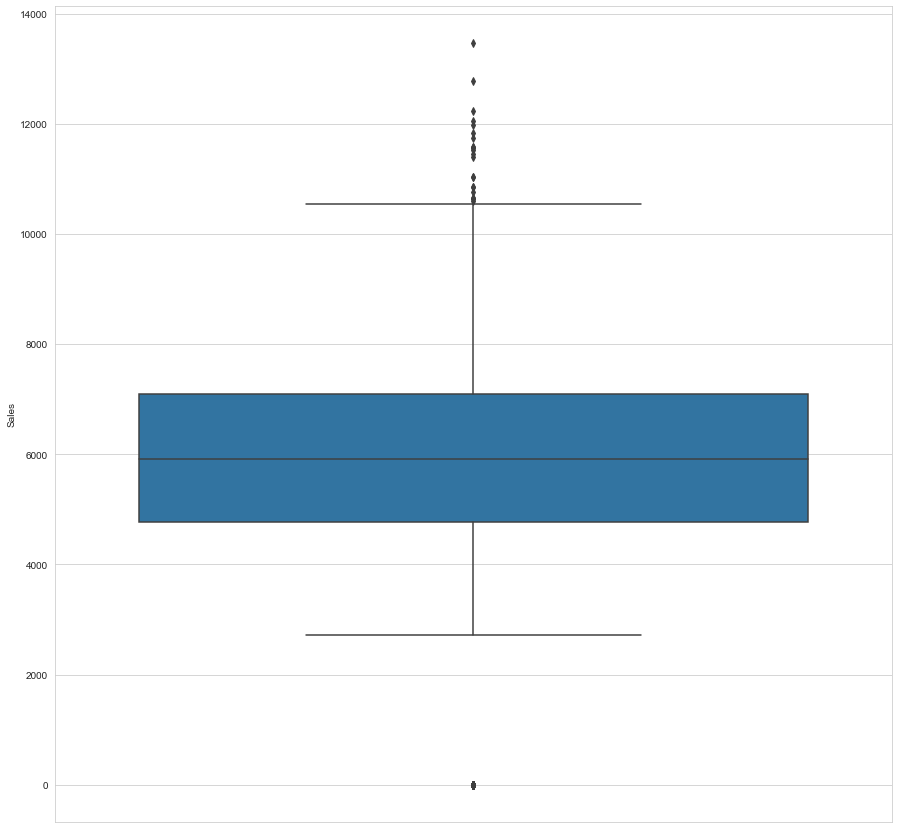

In [170]:
# checking for outliers
sns.set_style("whitegrid")

plt.figure(figsize=(15, 15))

sns.boxplot(y='Sales', data=store_9)

In [171]:
# Scaling values
scaler = MinMaxScaler()
store_9[['Sales','Customers']] = scaler.fit_transform(store_9[['Sales','Customers']])

In [172]:
store_9['Date'] = pd.to_datetime(store_9['Date'], format='%Y-%m')

In [173]:
store_9.index = store_9.Date
store_9=store_9.sort_index()
store_9.index.freq = store_9.index.inferred_freq
store_9.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2015-07-22', '2015-07-23', '2015-07-24', '2015-07-25',
               '2015-07-26', '2015-07-27', '2015-07-28', '2015-07-29',
               '2015-07-30', '2015-07-31'],
              dtype='datetime64[ns]', name='Date', length=942, freq='D')

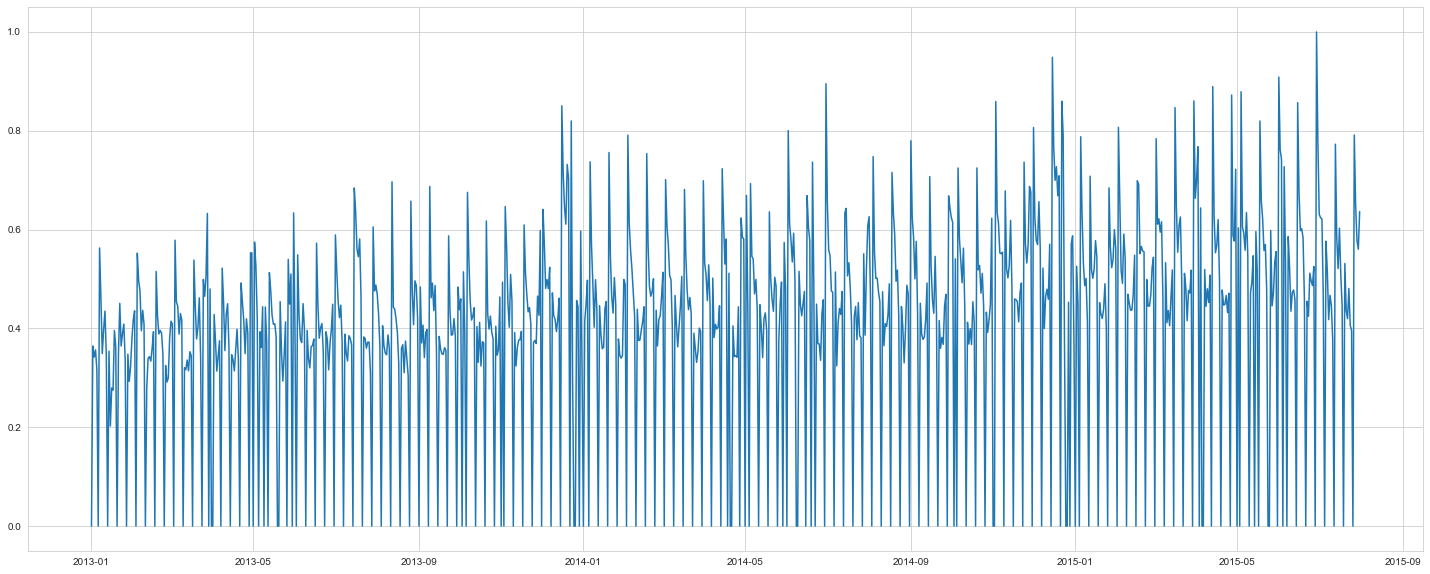

In [174]:
plt.figure(figsize=(25,10))
plt.plot(store_9['Sales'], label='Sales')

plt.show()

In [175]:
# dividing data into train and test
train_9 = store_9.loc['2013-01-01': '2015-05-31']
test_9 = store_9.loc[ '2015-06-01':]

In [176]:
# checking for stationarity using dickeyfuller 
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train_9['Sales'].dropna())

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.224527
Critical Values @ 0.05: -2.86
p-value: 0.018608


In [177]:
# Checking for stationarlity for customers
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train_9['Customers'].dropna())

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.308162
Critical Values @ 0.05: -2.86
p-value: 0.014518


#### p-value is <0.05

In [178]:
# checking lag order
model = VAR(train_9[['Sales','Customers']])
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -9.854023652864042
BIC :  -9.821433276222185
FPE :  5.2535385807250084e-05
HQIC:  -9.841560485812032 

Lag Order = 2
AIC :  -9.916544686380554
BIC :  -9.862178532823272
FPE :  4.9351399147273395e-05
HQIC:  -9.895752926033337 

Lag Order = 3
AIC :  -9.94822993327825
BIC :  -9.87204878030457
FPE :  4.7812222153661565e-05
HQIC:  -9.919093671222276 

Lag Order = 4
AIC :  -9.960514253749984
BIC :  -9.862478762458423
FPE :  4.7228510455834004e-05
HQIC:  -9.9230175331709 

Lag Order = 5
AIC :  -10.023100967127768
BIC :  -9.903171681738954
FPE :  4.436328580511287e-05
HQIC:  -9.97722778260926 

Lag Order = 6
AIC :  -10.191610461724235
BIC :  -10.049747809101037
FPE :  3.7483636189814927e-05
HQIC:  -10.137344759045835 

Lag Order = 7
AIC :  -10.828504350082342
BIC :  -10.664668639247484
FPE :  1.9826371577358027e-05
HQIC:  -10.765830026016145 

Lag Order = 8
AIC :  -10.84655344431178
BIC :  -10.660704865962929
FPE :  1.9471794089774883e-05
HQIC:  -10.7754543464181 

Lag Ord

In [179]:
#Building VAR model
mod = sm.tsa.VARMAX(train_9[['Sales','Customers']], order=(15,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  881
Model:                            VAR(15)   Log Likelihood                2419.779
Date:                    Mon, 12 Apr 2021   AIC                          -4713.558
Time:                            12:54:56   BIC                          -4412.351
Sample:                        01-01-2013   HQIC                         -4598.377
                             - 05-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):               116.45, 48.43   Jarque-Bera (JB):      1474.11, 257.66
Prob(Q):                        0.00, 0.17   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.84, 1.75   Skew:                     -1.05, -0.47
Prob(H) (two-sided):            0.00, 0.00   Kurtosis:                   8.98, 5.47


In [180]:
# predicting future sales
start_index = test_9.index.min()
end_index = test_9.index.max()
#print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index)

In [181]:
# inverse transformation to original values
train_9[['Sales','Customers']]=scaler.inverse_transform(train_9[['Sales','Customers']])
test_9[['Sales','Customers']] = scaler.inverse_transform(test_9[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

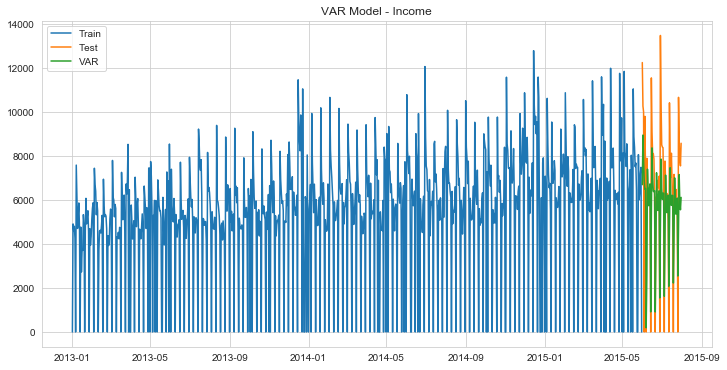

In [182]:
#plotting sales for test and predictions
plt.figure(figsize=(12,6)) 
plt.plot( train_9['Sales'], label='Train')
plt.plot(test_9['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Income')
plt.show()

In [183]:
rmse = np.sqrt(mean_squared_error(test_9['Sales'], predictions['Sales'][test_9.index.min():])).round(2)
mape = np.round(np.mean(np.abs( test_9['Sales']-predictions['Sales'][test_9.index.min():])/((np.abs(test_9['Sales'])+ np.abs(predictions['Sales']))/2))*100,2)

#tempResults = pd.DataFrame({'Method':['VAR method'], 'RMSE': [rmse],'SMAPE': [mape] })
results = pd.DataFrame({'Method':['Naive method'], 'SMAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'SMAPE']]
results

Method    RMSE  SMAPE
0  Naive method  2615.7   50.8

In [184]:
## johansen test for coningration
joh_model1 = coint_johansen(train_9[['Sales','Customers']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model1)

   max_eig_stat  trace_stat
0    159.245683  193.561069
1     34.315386   34.315386 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



## trace_stat is grater than critical values even for 99 and 95 confidence interval

In [185]:
rmse = np.sqrt(mean_squared_error(test_9['Sales'], predictions['Sales'][test_9.index.min():])).round(2)
smape = np.round(np.mean(np.abs( test_9['Sales']-predictions['Sales'][test_9.index.min():])/((np.abs(test_9['Sales'])+ np.abs(predictions['Sales']))/2))*100,2)

tempResults = pd.DataFrame({'Method':['VAR method'], 'RMSE': [rmse],'sMAPE': [smape] })
results = pd.DataFrame({'Method':['Naive method'], 'sMAPE': [smape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'sMAPE']]
results

Method    RMSE  sMAPE
0  Naive method  2615.7   50.8

#### VAR for future weeks Store 9

In [186]:
# Scaling values
scaler = MinMaxScaler()
store_9[['Sales','Customers']] = scaler.fit_transform(store_9[['Sales','Customers']])

In [187]:
#Building model for future
mod = sm.tsa.VARMAX(store_9[['Sales','Customers']], order=(15,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  942
Model:                            VAR(15)   Log Likelihood                2560.298
Date:                    Mon, 12 Apr 2021   AIC                          -4994.595
Time:                            12:55:51   BIC                          -4689.171
Sample:                        01-01-2013   HQIC                         -4878.177
                             - 07-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):               144.15, 62.27   Jarque-Bera (JB):      1638.76, 326.02
Prob(Q):                        0.00, 0.01   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         2.04, 1.77   Skew:                     -1.09, -0.49
Prob(H) (two-sided):            0.00, 0.00   Kurtosis:                   9.09, 5.71


In [188]:
#predicting future sales
start_index = ex_variables.index.min()
end_index = ex_variables.index.max()
#print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index)

In [189]:
#inverse transforming to original values
store_9[['Sales','Customers']]=scaler.inverse_transform(store_9[['Sales','Customers']])
#sorted_test[['Sales','Customers']] = scaler1.inverse_transform(sorted_test[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

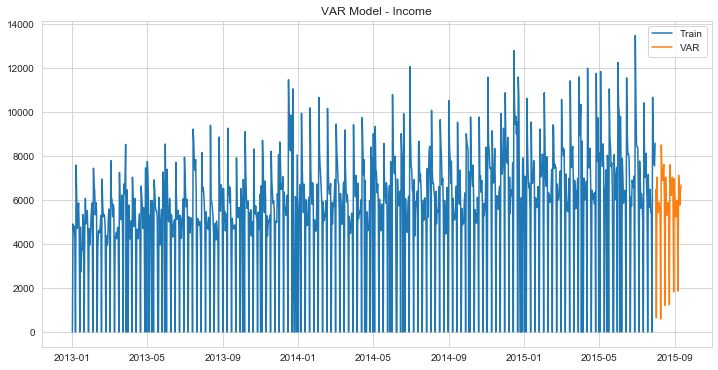

In [190]:
# plotting sales
plt.figure(figsize=(12,6)) 
plt.plot( store_9['Sales'], label='Train')
#plt.plot(sorted_test['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Income')
plt.show()

In [191]:
predictions['Sales']

2015-08-01    6468.886804
2015-08-02     640.302399
2015-08-03    7032.002854
2015-08-04    5630.139840
2015-08-05    5410.199692
2015-08-06    5879.031385
2015-08-07    5716.695141
2015-08-08    5485.820920
2015-08-09     587.901951
2015-08-10    8490.264337
2015-08-11    7373.417842
2015-08-12    6867.349689
2015-08-13    7186.697513
2015-08-14    7607.759111
2015-08-15    6099.379051
2015-08-16    1209.938250
2015-08-17    7020.492651
2015-08-18    5834.530755
2015-08-19    5292.841528
2015-08-20    5725.347709
2015-08-21    5872.706775
2015-08-22    5378.975311
2015-08-23    1240.504836
2015-08-24    7587.079688
2015-08-25    6759.046148
2015-08-26    6203.568016
2015-08-27    6770.935228
2015-08-28    7025.674761
2015-08-29    5888.069421
2015-08-30    1818.961531
2015-08-31    6958.394519
2015-09-01    5975.723898
2015-09-02    5219.581916
2015-09-03    5754.440525
2015-09-04    5965.275067
2015-09-05    5321.747231
2015-09-06    1854.442184
2015-09-07    7109.250169
2015-09-08  

## VARMAX STORE 9

In [192]:
# Scaling values
scaler = MinMaxScaler()
store_9[['Sales','Customers']] = scaler.fit_transform(store_9[['Sales','Customers']])

In [193]:
# dividing data into train and test
train_9 = store_9.loc['2013-01-01': '2015-05-31']
test_9 = store_9.loc[ '2015-06-01':]

In [194]:
exog = train_9[['Promo','Open']]
mod = sm.tsa.VARMAX(train_9[['Sales','Customers']], order=(15,0), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  881
Model:                           VARX(15)   Log Likelihood                3188.702
Date:                    Mon, 12 Apr 2021   AIC                          -6243.403
Time:                            13:00:59   BIC                          -5923.072
Sample:                        01-01-2013   HQIC                         -6120.909
                             - 05-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):              203.54, 156.65   Jarque-Bera (JB):      102.90, 1086.72
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.47, 1.28   Skew:                      0.38, -0.30
Prob(H) (two-sided):            0.00, 0.04   Kurtosis:                   4.50, 8.41


In [195]:
#prediction future sales
start_index = test_9.index.min()
end_index = test_9.index.max()
#print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index,exog=test_9[['Promo','Open']])

In [196]:
# inverse transformation of values
train_9[['Sales','Customers']]=scaler.inverse_transform(train_9[['Sales','Customers']])
test_9[['Sales','Customers']] = scaler.inverse_transform(test_9[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

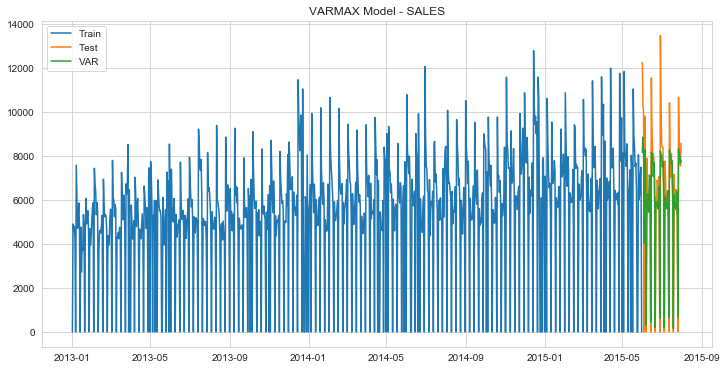

In [197]:
# plotting test and predicted values
plt.figure(figsize=(12,6)) 
plt.plot( train_9['Sales'], label='Train')
plt.plot(test_9['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VARMAX Model - SALES')
plt.show()

In [198]:
rmse = np.sqrt(mean_squared_error(test_9['Sales'], predictions['Sales'][test_9.index.min():])).round(2)
smape = np.round(np.mean(np.abs( test_9['Sales']-predictions['Sales'][test_9.index.min():])/((np.abs(test_9['Sales'])+ np.abs(predictions['Sales']))/2))*100,2)

tempResults = pd.DataFrame({'Method':['VAR method'], 'RMSE': [rmse],'sMAPE': [smape] })
results = pd.DataFrame({'Method':['Naive method'], 'sMAPE': [smape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'sMAPE']]
results

Method     RMSE  sMAPE
0  Naive method  1452.23  40.81

### VARMAX for future sales

In [199]:
# Scaling values
scaler = MinMaxScaler()
store_9[['Sales','Customers']] = scaler.fit_transform(store_9[['Sales','Customers']])

In [200]:
exog = store_9[['Promo','Open']]
mod = sm.tsa.VARMAX(store_9[['Sales','Customers']], order=(15,0), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  942
Model:                           VARX(15)   Log Likelihood                3379.623
Date:                    Mon, 12 Apr 2021   AIC                          -6625.246
Time:                            13:07:23   BIC                          -6300.430
Sample:                        01-01-2013   HQIC                         -6501.436
                             - 07-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):              252.05, 204.48   Jarque-Bera (JB):      103.27, 1294.48
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.54, 1.36   Skew:                      0.34, -0.25
Prob(H) (two-sided):            0.00, 0.01   Kurtosis:                   4.47, 8.72


In [201]:
#data_key_1.index = data_key_1.Date
start_index = ex_variables.index.min()
end_index = ex_variables.index.max()
print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index,exog=ex_variables[['Promo','Open']])

2015-08-01 00:00:00 2015-09-11 00:00:00


In [202]:
store_9[['Sales','Customers']]=scaler.inverse_transform(store_9[['Sales','Customers']])
#sorted_test[['Sales','Customers']] = scaler1.inverse_transform(sorted_test[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

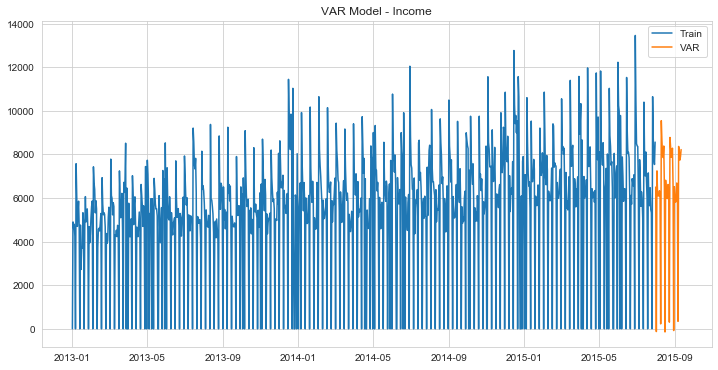

In [203]:
plt.figure(figsize=(12,6)) 
plt.plot( store_9['Sales'], label='Train')
#plt.plot(sorted_test['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Income')
plt.show()

In [204]:
predictions['Sales']

2015-08-01    6502.522149
2015-08-02    -125.358815
2015-08-03    7245.176911
2015-08-04    6140.987281
2015-08-05    6095.355597
2015-08-06    6099.888720
2015-08-07    6336.235021
2015-08-08    6031.380123
2015-08-09     226.311968
2015-08-10    9549.483605
2015-08-11    8640.924300
2015-08-12    7980.830097
2015-08-13    7858.608025
2015-08-14    8387.124939
2015-08-15    6477.230300
2015-08-16    -144.069154
2015-08-17    6816.298762
2015-08-18    6143.181714
2015-08-19    5984.512730
2015-08-20    5979.006937
2015-08-21    6622.648641
2015-08-22    6226.662040
2015-08-23     306.511445
2015-08-24    8778.499836
2015-08-25    8348.017342
2015-08-26    7871.277031
2015-08-27    7924.134156
2015-08-28    8285.395112
2015-08-29    6543.008366
2015-08-30     -78.512842
2015-08-31    6516.838984
2015-09-01    6081.781557
2015-09-02    5808.302022
2015-09-03    5929.749787
2015-09-04    6690.312406
2015-09-05    6324.560151
2015-09-06     345.234919
2015-09-07    8366.368670
2015-09-08  

## store 13

In [205]:
#getting data for store13
store_13 = data[data.Store.isin([13])]

In [206]:
store_13.Sales.describe(percentiles = [0.01,0.10,0.25,0.50,0.75,0.90,0.95,0.99,0.995])

count      758.000000
mean      4124.773087
std       2429.243956
min          0.000000
1%           0.000000
10%          0.000000
25%       3135.250000
50%       4261.500000
75%       5784.250000
90%       7032.700000
95%       7851.250000
99%       9145.260000
99.5%     9681.340000
max      10460.000000
Name: Sales, dtype: float64

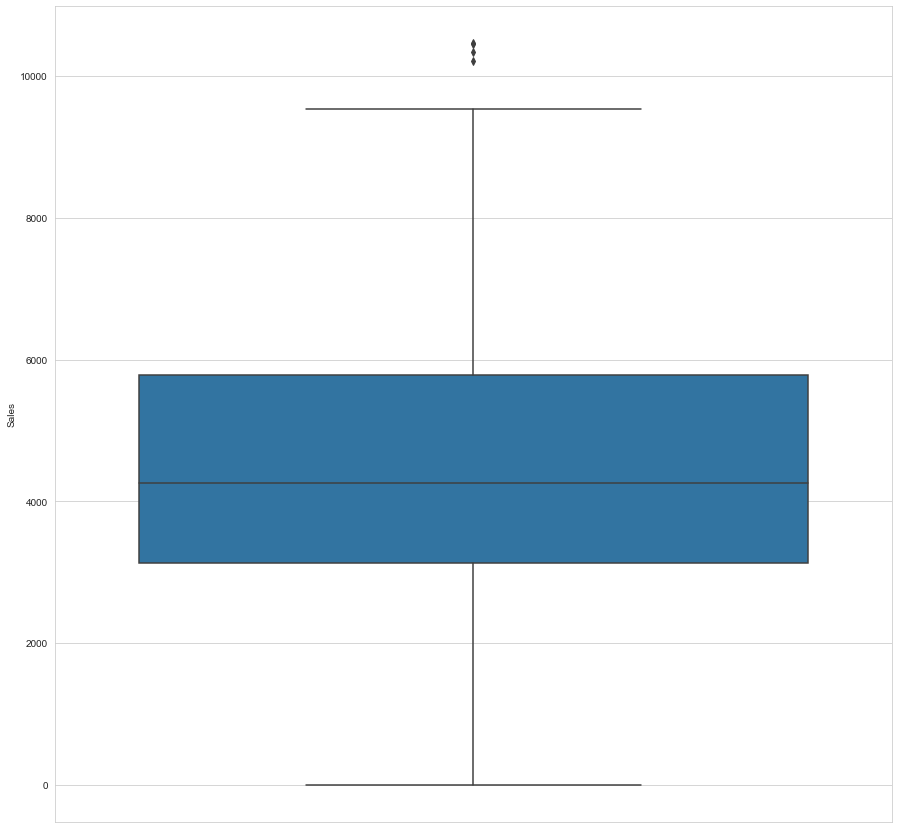

In [207]:
sns.set_style("whitegrid")

plt.figure(figsize=(15, 15))

sns.boxplot(y='Sales', data=store_13)

In [208]:
store_13[store_13.Sales >10000]

Store StoreType  Assortment  CompetitionDistance  Promo2  \
11320     13         d           0                310.0       1   
11511     13         d           0                310.0       1   
11712     13         d           0                310.0       1   
11850     13         d           0                310.0       1   

       PromoInterval       Date  Sales  Customers  Open  Promo  StateHoliday  \
11320            2.0 2015-07-15  10334        415     1      1             0   
11511            2.0 2015-01-05  10460        672     1      1             0   
11712            2.0 2013-12-16  10455        649     1      1             0   
11850            2.0 2013-07-31  10212        641     1      1             0   

       SchoolHoliday  
11320              0  
11511              1  
11712              0  
11850              1

In [209]:
# Removing outliers
store_13 =store_13[store_13.Sales <10000]

In [210]:
#scaling the values
scaler = MinMaxScaler()
store_13[['Sales','Customers']] = scaler.fit_transform(store_13[['Sales','Customers']])

In [211]:
store_13

Store StoreType  Assortment  CompetitionDistance  Promo2  \
11304     13         d           0                310.0       1   
11305     13         d           0                310.0       1   
11306     13         d           0                310.0       1   
11307     13         d           0                310.0       1   
11308     13         d           0                310.0       1   
...      ...       ...         ...                  ...     ...   
12057     13         d           0                310.0       1   
12058     13         d           0                310.0       1   
12059     13         d           0                310.0       1   
12060     13         d           0                310.0       1   
12061     13         d           0                310.0       1   

       PromoInterval       Date     Sales  Customers  Open  Promo  \
11304            2.0 2015-07-31  0.925021   0.855422     1      1   
11305            2.0 2015-07-30  0.802013   0.713855     1      1   
11306            2.0 2015-07-29  0.697148   0.611446     1      1   
11307            2.0 2015-07-28  0.715080   0.671687     1      1   
11308            2.0 2015-07-27  0.831166   0.793675     1      1   
...              ...        ...       ...        ...   ...    ...   
12057            2.0 2013-01-05  0.449350   0.518072     1      0   
12058            2.0 2013-01-04  0.403523   0.512048     1      0   
12059            2.0 2013-01-03  0.385277   0.439759     1      0   
12060            2.0 2013-01-02  0.391883   0.477410     1      0   
12061            2.0 2013-01-01  0.000000   0.000000     0      0   

       StateHoliday  SchoolHoliday  
11304             0              0  
11305             0              0  
11306             0              0  
11307             0              0  
11308             0              0  
...             ...            ...  
12057             0              0  
12058             0              1  
12059             0              1  
12060             0              1  
12061             1              1  

[754 rows x 13 columns]

In [212]:
# mputing the removed outlier values

In [213]:
store_13=store_13.append({'Store': 13,'StoreType' : 'd','Assortment':0,
                  'CompetitionDistance' : 310,'Date' : '2015-07-15',
                   'Sales':1,'Customers':1,
                  'Open':1,'Promo':1,
                  'StateHoliday':0,'SchoolHoliday':0,
                  'Promo2':1,'PromoInterval':2.0},
                  ignore_index=True)

In [214]:
store_13=store_13.append({'Store': 13,'StoreType' : 'd','Assortment':0,
                  'CompetitionDistance' : 310,'Date' : '2015-01-05',
                   'Sales':1,'Customers':1,
                  'Open':1,'Promo':1,
                  'StateHoliday':0,'SchoolHoliday':0,
                  'Promo2':1,'PromoInterval':2.0},
                  ignore_index=True)

In [215]:
store_13=store_13.append({'Store': 13,'StoreType' : 'd','Assortment':0,
                  'CompetitionDistance' : 310,'Date' : '2013-12-16',
                   'Sales':1,'Customers':1,
                  'Open':1,'Promo':1,
                  'StateHoliday':0,'SchoolHoliday':0,
                  'Promo2':1,'PromoInterval':2.0},
                  ignore_index=True)

In [216]:
store_13=store_13.append({'Store': 13,'StoreType' : 'd','Assortment':0,
                  'CompetitionDistance' : 310,'Date' : '2013-07-31',
                   'Sales':1,'Customers':1,
                  'Open':1,'Promo':0,
                  'StateHoliday':0,'SchoolHoliday':0,
                  'Promo2':1,'PromoInterval':2.0},
                  ignore_index=True)

In [217]:
#chaginf date to datetime
store_13['Date'] = pd.to_datetime(store_13['Date'], format='%Y-%m')

In [218]:
store_13.index = store_13.Date
store_13=store_13.sort_index()
store_13.index.freq = store_13.index.inferred_freq
store_13.index
#test_3 = store_3.

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2015-07-22', '2015-07-23', '2015-07-24', '2015-07-25',
               '2015-07-26', '2015-07-27', '2015-07-28', '2015-07-29',
               '2015-07-30', '2015-07-31'],
              dtype='datetime64[ns]', name='Date', length=758, freq=None)

In [219]:
#dividing to train and test
train_13 = store_13.loc['2013-01-01': '2014-06-30']

train_13.index = train_13.Date
train_13=train_13.sort_index()
train_13.index.freq = train_13.index.inferred_freq
train_13.index
#test_3 = store_3.loc[ '2015-06-01':]

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2014-06-21', '2014-06-22', '2014-06-23', '2014-06-24',
               '2014-06-25', '2014-06-26', '2014-06-27', '2014-06-28',
               '2014-06-29', '2014-06-30'],
              dtype='datetime64[ns]', name='Date', length=546, freq='D')

In [220]:
test_13 = store_13.loc[ '2015-01-01':]

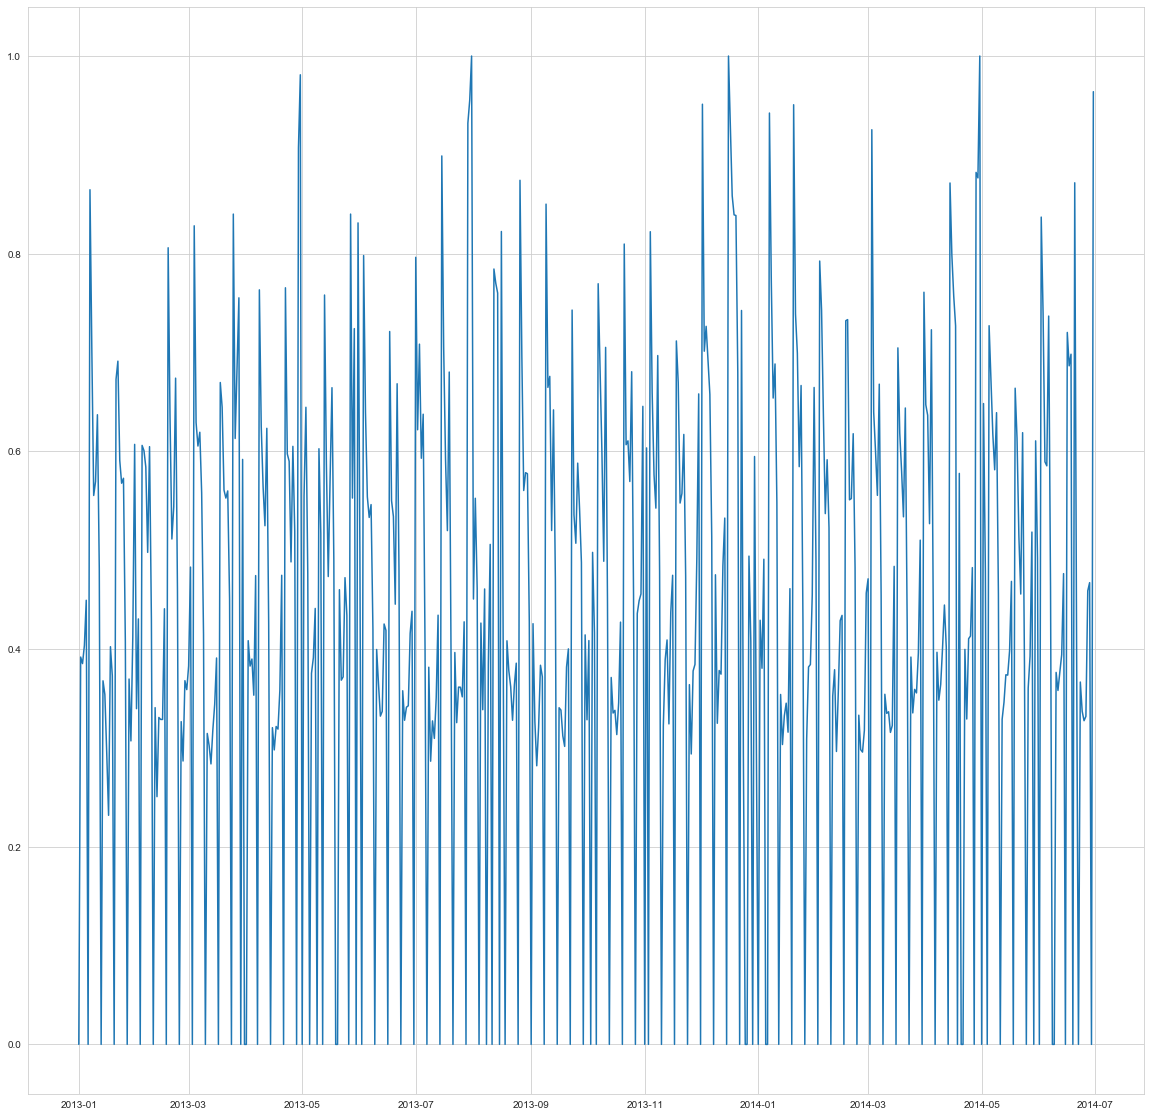

In [221]:
plt.figure(figsize=(20,20)) 
plt.plot(train_13['Sales'])

In [222]:
#Adickey Fuller Test for checking stationarity
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train_13['Sales'].dropna())

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -7.128220
Critical Values @ 0.05: -2.87
p-value: 0.000000


In [223]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train_13['Customers'].dropna())

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -7.124728
Critical Values @ 0.05: -2.87
p-value: 0.000000


In [224]:
#p -value is <0.05 hence the data is stationary

In [225]:
#finding lag order
model = VAR(train_13[['Sales','Customers']])
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -9.242898934113967
BIC :  -9.19555083362226
FPE :  9.679659772958401e-05
HQIC:  -9.224388673087962 

Lag Order = 2
AIC :  -9.317834560805993
BIC :  -9.238809758474083
FPE :  8.980826711427965e-05
HQIC:  -9.286938133112105 

Lag Order = 3
AIC :  -9.351352005856281
BIC :  -9.240560973666454
FPE :  8.684816889128043e-05
HQIC:  -9.308032412265463 

Lag Order = 4
AIC :  -9.365032084180928
BIC :  -9.222384873801014
FPE :  8.566844712323498e-05
HQIC:  -9.30925214836309 

Lag Order = 5
AIC :  -9.515680875881179
BIC :  -9.341087115928087
FPE :  7.36880684633657e-05
HQIC:  -9.447403243244757 

Lag Order = 6
AIC :  -9.759428600016472
BIC :  -9.552797493296998
FPE :  5.7748684366703176e-05
HQIC:  -9.678615736538374 

Lag Order = 7
AIC :  -10.173366819195076
BIC :  -9.934607139923703
FPE :  3.817468079506286e-05
HQIC:  -10.079981010240875 

Lag Order = 8
AIC :  -10.217665461535002
BIC :  -9.946685552528496
FPE :  3.652099089760272e-05
HQIC:  -10.111668810669304 

Lag Order = 9


In [226]:
#Building model
mod = sm.tsa.VARMAX(train_13[['Sales','Customers']], order=(15,1), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  546
Model:                        VARMA(15,1)   Log Likelihood                1322.116
Date:                    Mon, 12 Apr 2021   AIC                          -2510.233
Time:                            13:10:07   BIC                          -2221.958
Sample:                        01-01-2013   HQIC                         -2397.544
                             - 06-30-2014                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):                61.71, 50.66   Jarque-Bera (JB):        226.10, 19.76
Prob(Q):                        0.02, 0.12   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.17, 1.17   Skew:                     -0.31, -0.30
Prob(H) (two-sided):            0.29, 0.28   Kurtosis:                   6.09, 3.71


In [227]:
# predicting sales test values
start_index = pd.to_datetime('2014-07-01', format='%Y-%m')
end_index = pd.to_datetime('2014-12-31', format='%Y-%m')
#print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index)

In [228]:
#inverse transformation of values
train_13[['Sales','Customers']]=scaler.inverse_transform(train_13[['Sales','Customers']])
#sorted_test[['Sales','Customers']] = scaler.inverse_transform(sorted_test[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

In [229]:
test_13[['Sales','Customers']]=scaler.inverse_transform(test_13[['Sales','Customers']])

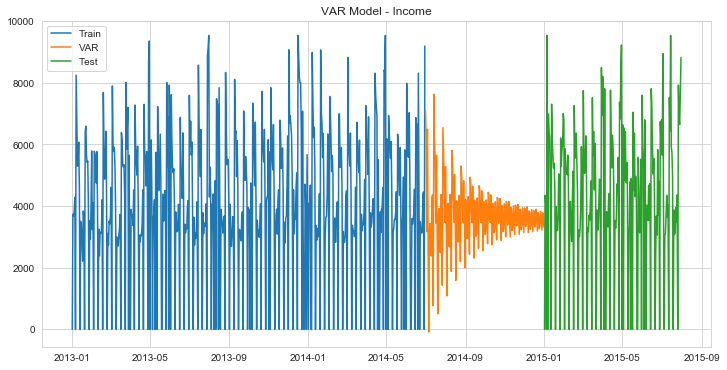

In [230]:
plt.figure(figsize=(12,6)) 
plt.plot( train_13['Sales'], label='Train')
plt.plot(predictions['Sales'], label='VAR')
plt.plot(test_13['Sales'], label='Test')
plt.legend(loc='best')
plt.title('VAR Model - Income')
plt.show()

In [231]:
intermediate = train_13[['Sales','Customers']].append(predictions)

In [232]:
intermediate

Sales   Customers
2013-01-01     0.000000    0.000000
2013-01-02  3737.000000  317.000000
2013-01-03  3674.000000  292.000000
2013-01-04  3848.000000  340.000000
2013-01-05  4285.000000  344.000000
...                 ...         ...
2014-12-27  3499.405735  275.060514
2014-12-28  3220.009705  250.587710
2014-12-29  3792.919284  293.823388
2014-12-30  3763.148666  294.115012
2014-12-31  3322.798807  259.979182

[730 rows x 2 columns]

In [233]:
store_13 = intermediate.append(test_13[['Sales','Customers']])

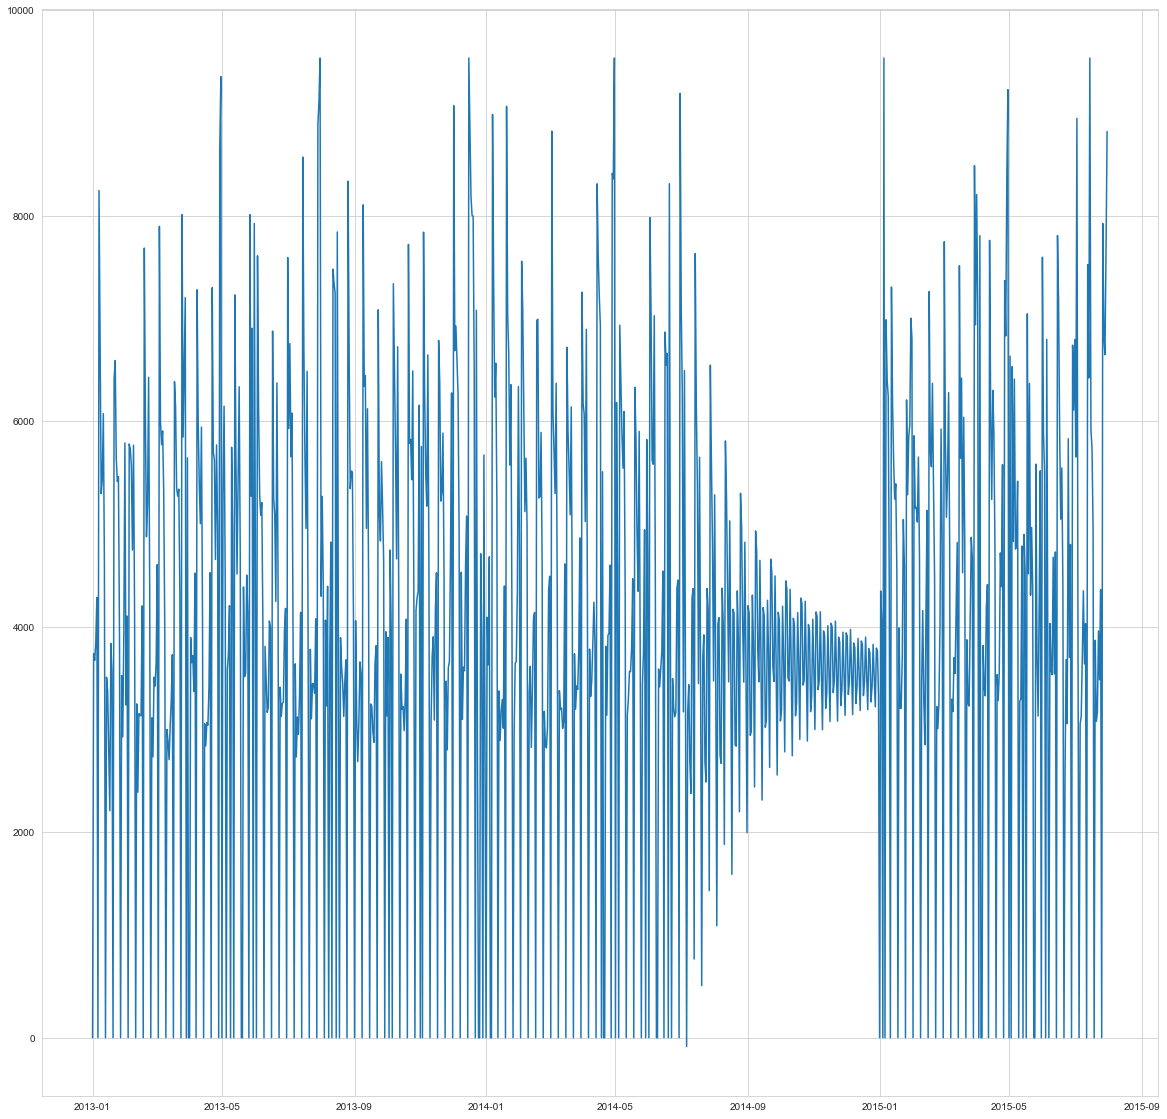

In [234]:
plt.figure(figsize=(20,20)) 
plt.plot(store_13['Sales'])

In [235]:
#doing stationarity test again on complete data
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(store_13['Sales'].dropna())

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -5.465932
Critical Values @ 0.05: -2.86
p-value: 0.000002


In [236]:
#doing stationarity test again on complete data
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(store_13['Customers'].dropna())

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -5.242762
Critical Values @ 0.05: -2.86
p-value: 0.000007


In [237]:
# p-value is  <0.05 the data is sationary

In [238]:
scaler = MinMaxScaler()
store_13[['Sales','Customers']] = scaler.fit_transform(store_13[['Sales','Customers']])

In [239]:
train_13 = store_13.loc['2013-01-01': '2015-05-31']
test_13 = store_13.loc[ '2015-06-01':]

In [240]:
# finding lag order
model = VAR(train_13[['Sales','Customers']])
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -9.51817018520751
BIC :  -9.485579808565653
FPE :  7.350404403458863e-05
HQIC:  -9.5057070181555 

Lag Order = 2
AIC :  -9.588314748757814
BIC :  -9.533948595200531
FPE :  6.852482268676562e-05
HQIC:  -9.567522988410596 

Lag Order = 3
AIC :  -9.603734842922082
BIC :  -9.527553689948402
FPE :  6.747629768201069e-05
HQIC:  -9.574598580866107 

Lag Order = 4
AIC :  -9.610827655662785
BIC :  -9.512792164371223
FPE :  6.699944551117965e-05
HQIC:  -9.5733309350837 

Lag Order = 5
AIC :  -9.718807102778541
BIC :  -9.598877817389727
FPE :  6.014185942995574e-05
HQIC:  -9.672933918260034 

Lag Order = 6
AIC :  -9.853383785929882
BIC :  -9.711521133306684
FPE :  5.256923934028289e-05
HQIC:  -9.799118083251482 

Lag Order = 7
AIC :  -10.366629139256636
BIC :  -10.202793428421778
FPE :  3.146538838132702e-05
HQIC:  -10.303954815190439 

Lag Order = 8
AIC :  -10.421463044487552
BIC :  -10.235614466138701
FPE :  2.9786562271665238e-05
HQIC:  -10.350363946593871 

Lag Order = 9


In [241]:
#Building model
mod = sm.tsa.VARMAX(train_13[['Sales','Customers']], order=(15,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  881
Model:                            VAR(15)   Log Likelihood                2223.166
Date:                    Mon, 12 Apr 2021   AIC                          -4320.331
Time:                            13:11:15   BIC                          -4019.124
Sample:                        01-01-2013   HQIC                         -4205.150
                             - 05-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):                81.44, 72.01   Jarque-Bera (JB):       714.12, 192.38
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.82, 0.97   Skew:                     -0.42, -0.55
Prob(H) (two-sided):            0.09, 0.80   Kurtosis:                   7.33, 5.01


In [242]:
#predicting sales test values
start_index = test_13.index.min()
end_index = test_13.index.max()
#print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index)

In [243]:
#inverse transformation of vales of train test and predictions
train_13[['Sales','Customers']]=scaler.inverse_transform(train_13[['Sales','Customers']])
test_13[['Sales','Customers']] = scaler.inverse_transform(test_13[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

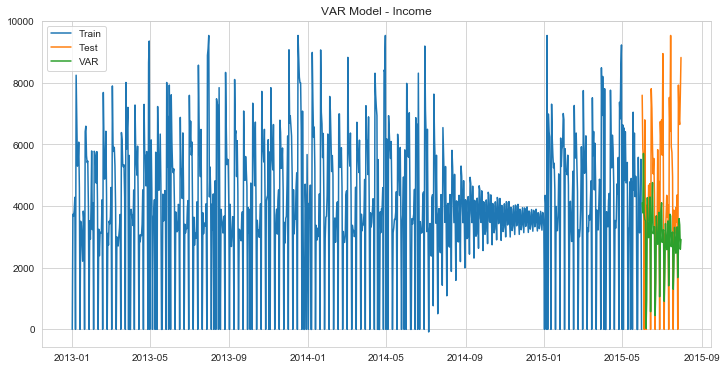

In [244]:
#plotting values
plt.figure(figsize=(12,6)) 
plt.plot( train_13['Sales'], label='Train')
plt.plot(test_13['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Income')
plt.show()

In [245]:
rmse = np.sqrt(mean_squared_error(test_13['Sales'], predictions['Sales'][test_13.index.min():])).round(2)
smape = np.round(np.mean(np.abs( test_13['Sales']-predictions['Sales'][test_13.index.min():])/((np.abs(test_13['Sales'])+ np.abs(predictions['Sales']))/2))*100,2)

tempResults = pd.DataFrame({'Method':['VAR method'], 'RMSE': [rmse],'sMAPE': [smape] })
results = pd.DataFrame({'Method':['Naive method'], 'sMAPE': [smape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'sMAPE']]
results

Method     RMSE  sMAPE
0  Naive method  2556.97  68.73

## prediction of future 6 weeks

In [246]:
#scaling store values
scaler = MinMaxScaler()
store_13[['Sales','Customers']] = scaler.fit_transform(store_13[['Sales','Customers']])

In [247]:
#Building final model with whole data
mod = sm.tsa.VARMAX(store_13[['Sales','Customers']], order=(15,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  942
Model:                            VAR(15)   Log Likelihood                2300.088
Date:                    Mon, 12 Apr 2021   AIC                          -4474.177
Time:                            13:12:03   BIC                          -4168.753
Sample:                        01-01-2013   HQIC                         -4357.758
                             - 07-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):                91.33, 73.46   Jarque-Bera (JB):       708.52, 869.50
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.02, 1.38   Skew:                     -0.47, -0.87
Prob(H) (two-sided):            0.87, 0.00   Kurtosis:                   7.15, 7.37


In [248]:
#predicting future 6 weeks values
start_index = ex_variables.index.min()
end_index = ex_variables.index.max()
#print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index)

In [249]:
# inverse transformation of store and predictions
store_13[['Sales','Customers']]=scaler.inverse_transform(store_13[['Sales','Customers']])
#sorted_test[['Sales','Customers']] = scaler1.inverse_transform(sorted_test[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

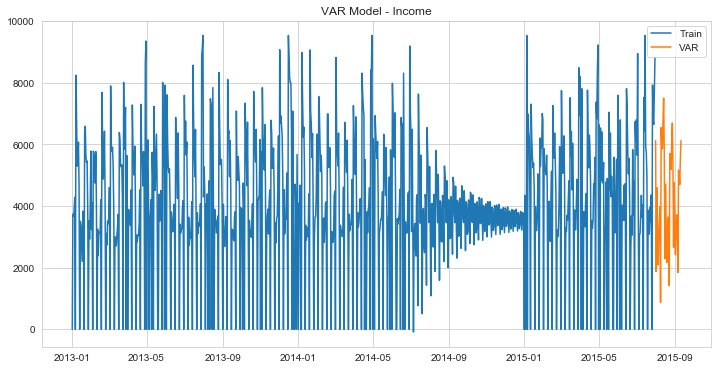

In [250]:
plt.figure(figsize=(12,6)) 
plt.plot( store_13['Sales'], label='Train')
#plt.plot(sorted_test['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Income')
plt.show()

In [251]:
predictions['Sales']

2015-08-01    6130.993638
2015-08-02    1872.543382
2015-08-03    4601.764049
2015-08-04    3128.445660
2015-08-05    2087.026789
2015-08-06    2978.429108
2015-08-07    3556.982847
2015-08-08    3978.500962
2015-08-09     873.046116
2015-08-10    6549.015858
2015-08-11    5923.883067
2015-08-12    5857.543400
2015-08-13    6763.427324
2015-08-14    7504.120645
2015-08-15    5728.688474
2015-08-16    2292.758392
2015-08-17    4707.948674
2015-08-18    3466.862168
2015-08-19    2166.433478
2015-08-20    2967.589344
2015-08-21    3645.066105
2015-08-22    3629.678109
2015-08-23    1416.834972
2015-08-24    5704.731518
2015-08-25    5398.520143
2015-08-26    5186.838434
2015-08-27    6047.742134
2015-08-28    6693.823194
2015-08-29    5388.449699
2015-08-30    2665.093110
2015-08-31    4757.200414
2015-09-01    3730.157206
2015-09-02    2422.501655
2015-09-03    3100.424960
2015-09-04    3716.008555
2015-09-05    3470.246399
2015-09-06    1841.832965
2015-09-07    5164.504125
2015-09-08  

## Store 25


In [252]:
#getting store 25 values
store_25 = data[data.Store.isin([25])]

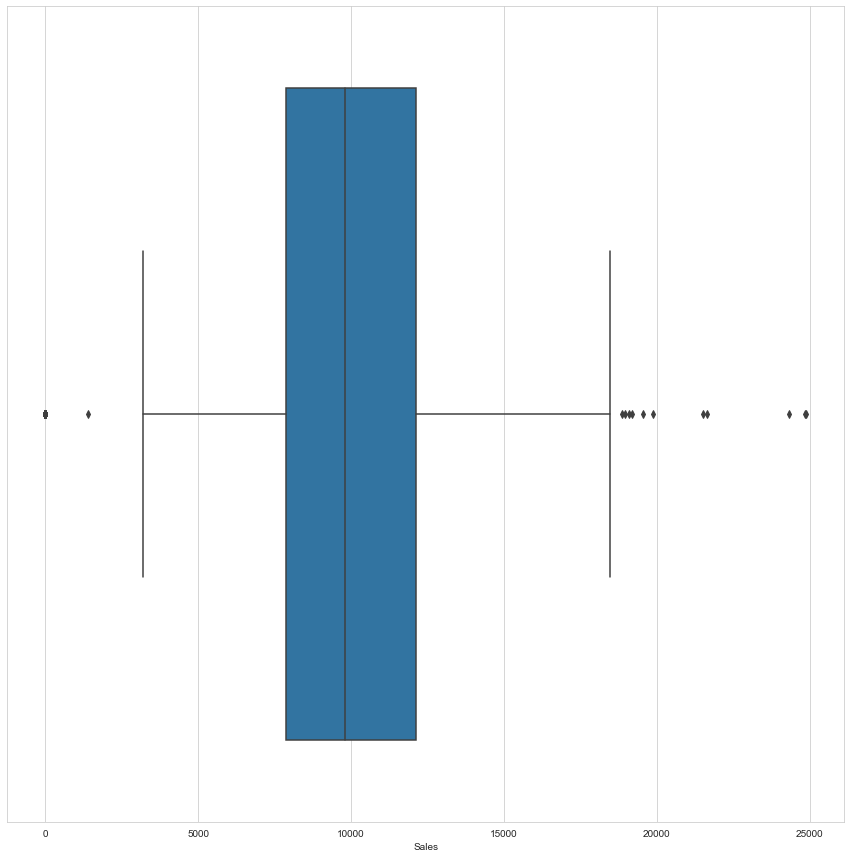

In [253]:
sns.set_style("whitegrid")

plt.figure(figsize=(15, 15))

sns.boxplot( x='Sales', data=store_25)

In [254]:
store_25.Sales.describe(percentiles = [0.01,0.10,0.25,0.50,0.75,0.90,0.95,0.99,0.995])

count      942.000000
mean      8892.311040
std       5151.671996
min          0.000000
1%           0.000000
10%          0.000000
25%       7858.750000
50%       9806.000000
75%      12125.250000
90%      14422.600000
95%      15817.550000
99%      18924.800000
99.5%    20352.080000
max      24882.000000
Name: Sales, dtype: float64

In [255]:
store_25 = store_25[store_25.Sales < 21000]

In [256]:
#scaling store values
scaler = MinMaxScaler()
store_25[['Sales','Customers']] = scaler.fit_transform(store_25[['Sales','Customers']])

In [257]:
store_25_1 = store_25.loc['2013-01-01': '2015-05-31']

In [258]:
store_25_del = store_25_1[store_25_1.Sales > 21000]

In [259]:
store_25_del

Empty DataFrame
Columns: [Store, StoreType, Assortment, CompetitionDistance, Promo2, PromoInterval, Date, Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday]
Index: []

In [260]:
store_25.Customers.describe(percentiles = [0.01,0.10,0.25,0.50,0.75,0.90,0.95,0.99,0.995])

count    937.000000
mean       0.483017
std        0.265105
min        0.000000
1%         0.000000
10%        0.000000
25%        0.456522
50%        0.564829
75%        0.655280
90%        0.739907
95%        0.791227
99%        0.878789
99.5%      0.899379
max        1.000000
Name: Customers, dtype: float64

In [261]:
store_25=store_25.append({'Store': 25,'StoreType' : 'c','Assortment':'a',
                  'CompetitionDistance' : 430,'Date' : '2013-04-30',
                   'Sales':1.000000000000,'Customers':1.00000000000,
                  'Open':1,'Promo':1,
                  'StateHoliday':0,'SchoolHoliday':0,
                  'Promo2':0,'PromoInterval':0},
                  ignore_index=True)

In [262]:
store_25=store_25.append({'Store': 25,'StoreType' : 'c','Assortment':'a',
                  'CompetitionDistance' : 430,'Date' : '2014-01-06',
                   'Sales':1.000000000000,'Customers':1.00000000000,
                  'Open':1,'Promo':1,
                  'StateHoliday':0,'SchoolHoliday':1,
                  'Promo2':0,'PromoInterval':0},
                  ignore_index=True)

In [263]:
store_25=store_25.append({'Store': 25,'StoreType' : 'c','Assortment':'a',
                  'CompetitionDistance' : 430,'Date' : '2014-01-07',
                   'Sales':1.000000000000,'Customers':1.00000000000,
                  'Open':1,'Promo':1,
                  'StateHoliday':0,'SchoolHoliday':1,
                  'Promo2':0,'PromoInterval':0},
                  ignore_index=True)

In [264]:
store_25=store_25.append({'Store': 25,'StoreType' : 'c','Assortment':'a',
                  'CompetitionDistance' : 430,'Date' : '2014-02-14',
                   'Sales':1.000000000000,'Customers':1.00000000000,
                  'Open':1,'Promo':0,
                  'StateHoliday':0,'SchoolHoliday':0,
                  'Promo2':0,'PromoInterval':0},
                  ignore_index=True)

In [265]:
store_25=store_25.append({'Store': 25,'StoreType' : 'c','Assortment':'a',
                  'CompetitionDistance' : 430,'Date' : '2014-02-17',
                   'Sales':1.000000000000,'Customers':1.00000000000,
                  'Open':1,'Promo':1,
                  'StateHoliday':0,'SchoolHoliday':0,
                  'Promo2':0,'PromoInterval':0},
                  ignore_index=True)

In [266]:
store_25['Date'] = pd.to_datetime(store_25['Date'], format='%Y-%m')

In [267]:
#setting date as index
store_25.index = store_25.Date
store_25=store_25.sort_index()
store_25.index.freq = store_25.index.inferred_freq

In [268]:
#dividing to train and test
train_25 = store_25.loc['2013-01-01': '2015-05-31']
test_25 = store_25.loc[ '2015-06-01':]

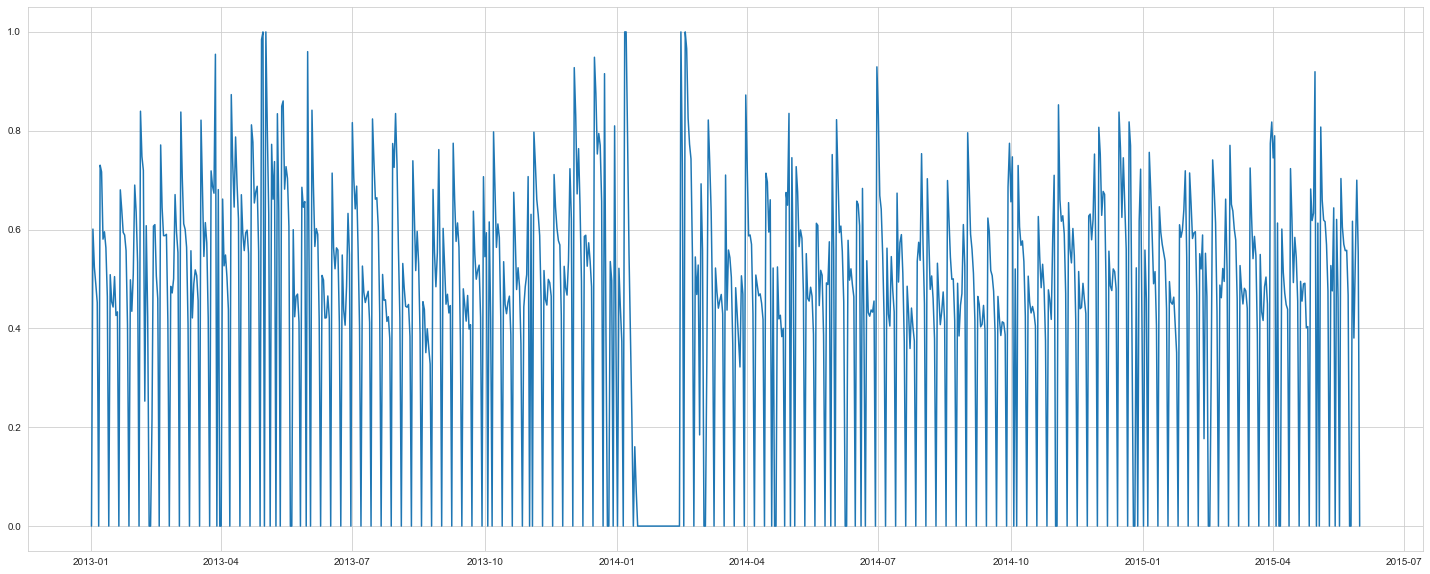

In [269]:
plt.figure(figsize=(25,10))
plt.plot(train_25['Sales'], label='Sales')

plt.show()

In [270]:
# stationarity test
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train_25['Customers'].dropna())

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.959489
Critical Values @ 0.05: -2.86
p-value: 0.001638


In [271]:
# stationarity test for customers
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train_25['Sales'].dropna())

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -4.392561
Critical Values @ 0.05: -2.86
p-value: 0.000306


In [272]:
# finding lag order
model = VAR(train_25[['Sales','Customers']])
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -9.478079395523908
BIC :  -9.445489018882052
FPE :  7.651074704910771e-05
HQIC:  -9.465616228471898 

Lag Order = 2
AIC :  -9.496568976025348
BIC :  -9.442202822468065
FPE :  7.510910782243371e-05
HQIC:  -9.47577721567813 

Lag Order = 3
AIC :  -9.495061419218146
BIC :  -9.418880266244466
FPE :  7.522245683232471e-05
HQIC:  -9.465925157162172 

Lag Order = 4
AIC :  -9.499157724069905
BIC :  -9.401122232778343
FPE :  7.491501030095931e-05
HQIC:  -9.46166100349082 

Lag Order = 5
AIC :  -9.532300192621545
BIC :  -9.41237090723273
FPE :  7.247292222865379e-05
HQIC:  -9.486427008103037 

Lag Order = 6
AIC :  -9.564127512738668
BIC :  -9.42226486011547
FPE :  7.020274539472238e-05
HQIC:  -9.509861810060269 

Lag Order = 7
AIC :  -10.240817254709528
BIC :  -10.07698154387467
FPE :  3.568391563166859e-05
HQIC:  -10.17814293064333 

Lag Order = 8
AIC :  -10.25248621785498
BIC :  -10.066637639506128
FPE :  3.5270050919872397e-05
HQIC:  -10.181387119961299 

Lag Order = 9
AI

In [273]:
train_25

Store StoreType Assortment  CompetitionDistance  Promo2  \
Date                                                                  
2013-01-01     25         c          0                430.0       0   
2013-01-02     25         c          0                430.0       0   
2013-01-03     25         c          0                430.0       0   
2013-01-04     25         c          0                430.0       0   
2013-01-05     25         c          0                430.0       0   
...           ...       ...        ...                  ...     ...   
2015-05-27     25         c          0                430.0       0   
2015-05-28     25         c          0                430.0       0   
2015-05-29     25         c          0                430.0       0   
2015-05-30     25         c          0                430.0       0   
2015-05-31     25         c          0                430.0       0   

            PromoInterval       Date     Sales  Customers  Open  Promo  \
Date                                                                     
2013-01-01            0.0 2013-01-01  0.000000   0.000000     0      0   
2013-01-02            0.0 2013-01-02  0.601016   0.659161     1      0   
2013-01-03            0.0 2013-01-03  0.523776   0.616071     1      0   
2013-01-04            0.0 2013-01-04  0.489559   0.590062     1      0   
2013-01-05            0.0 2013-01-05  0.452222   0.536102     1      0   
...                   ...        ...       ...        ...   ...    ...   
2015-05-27            0.0 2015-05-27  0.380516   0.435559     1      0   
2015-05-28            0.0 2015-05-28  0.534897   0.585404     1      0   
2015-05-29            0.0 2015-05-29  0.699995   0.669255     1      0   
2015-05-30            0.0 2015-05-30  0.552810   0.538043     1      0   
2015-05-31            0.0 2015-05-31  0.000000   0.000000     0      0   

            StateHoliday  SchoolHoliday  
Date                                     
2013-01-01             1              1  
2013-01-02             0              1  
2013-01-03             0              1  
2013-01-04             0              1  
2013-01-05             0              0  
...                  ...            ...  
2015-05-27             0              0  
2015-05-28             0              0  
2015-05-29             0              0  
2015-05-30             0              0  
2015-05-31             0              0  

[881 rows x 13 columns]

In [274]:
# Building model
mod = sm.tsa.VARMAX(train_25[['Sales','Customers']], order=(15,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  881
Model:                            VAR(15)   Log Likelihood                2125.241
Date:                    Mon, 12 Apr 2021   AIC                          -4124.483
Time:                            13:13:18   BIC                          -3823.276
Sample:                        01-01-2013   HQIC                         -4009.302
                             - 05-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):                80.83, 56.37   Jarque-Bera (JB):      1320.41, 199.62
Prob(Q):                        0.00, 0.04   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.90, 1.03   Skew:                     -0.63, -0.57
Prob(H) (two-sided):            0.36, 0.81   Kurtosis:                   8.86, 5.03


In [275]:
#predicting sales values
start_index = test_25.index.min()
end_index = test_25.index.max()
print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index)

2015-06-01 00:00:00 2015-07-31 00:00:00


In [276]:
train_25[['Sales','Customers']]=scaler.inverse_transform(train_25[['Sales','Customers']])

test_25[['Sales','Customers']] = scaler.inverse_transform(test_25[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

In [277]:
predictions[['Sales','Customers']]

Sales    Customers
2015-06-01   7154.753321   889.356121
2015-06-02  11828.997310  1640.271059
2015-06-03   8583.401490  1176.549479
2015-06-04  10226.457307  1453.567097
2015-06-05   8723.443943  1260.810079
...                  ...          ...
2015-07-27   5438.826359   755.095735
2015-07-28   8684.001880  1221.807944
2015-07-29   6786.018661   961.674889
2015-07-30   7509.645048  1063.387130
2015-07-31   7660.616641  1084.772059

[61 rows x 2 columns]

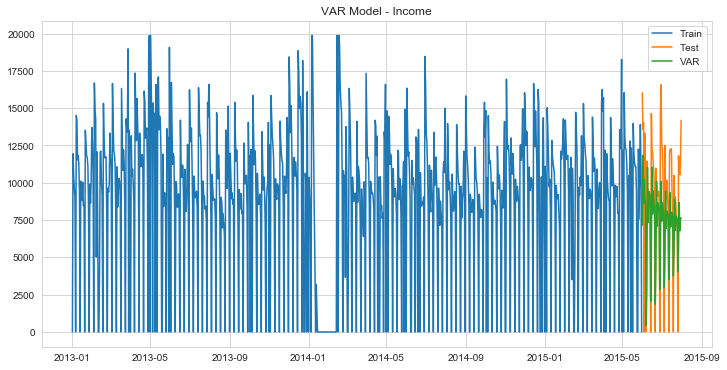

In [278]:
plt.figure(figsize=(12,6)) 
plt.plot( train_25['Sales'], label='Train')
plt.plot(test_25['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Income')
plt.show()

In [279]:
#calculation of error using SMAPE
rmse = np.sqrt(mean_squared_error(test_25['Sales'], predictions['Sales'][test_25.index.min():])).round(2)
mape = np.round(np.mean(np.abs( test_25['Sales']-predictions['Sales'][test_25.index.min():])/((np.abs(test_25['Sales'])+ np.abs(predictions['Sales']))/2))*100,2)

tempResults = pd.DataFrame({'Method':['VAR method'], 'RMSE': [rmse],'SMAPE': [mape] })
results = pd.DataFrame({'Method':['Naive method'], 'SMAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'SMAPE']]
results

Method     RMSE  SMAPE
0  Naive method  4118.81  56.84

#### predicting future sales using VAR

In [280]:
store_25 = train_25.append(test_25)

In [281]:
store_25

Store StoreType Assortment  CompetitionDistance  Promo2  \
Date                                                                  
2013-01-01     25         c          0                430.0       0   
2013-01-02     25         c          0                430.0       0   
2013-01-03     25         c          0                430.0       0   
2013-01-04     25         c          0                430.0       0   
2013-01-05     25         c          0                430.0       0   
...           ...       ...        ...                  ...     ...   
2015-07-27     25         c          0                430.0       0   
2015-07-28     25         c          0                430.0       0   
2015-07-29     25         c          0                430.0       0   
2015-07-30     25         c          0                430.0       0   
2015-07-31     25         c          0                430.0       0   

            PromoInterval       Date    Sales  Customers  Open  Promo  \
Date                                                                    
2013-01-01            0.0 2013-01-01      0.0        0.0     0      0   
2013-01-02            0.0 2013-01-02  11944.0     1698.0     1      0   
2013-01-03            0.0 2013-01-03  10409.0     1587.0     1      0   
2013-01-04            0.0 2013-01-04   9729.0     1520.0     1      0   
2013-01-05            0.0 2013-01-05   8987.0     1381.0     1      0   
...                   ...        ...      ...        ...   ...    ...   
2015-07-27            0.0 2015-07-27  11806.0     1536.0     1      1   
2015-07-28            0.0 2015-07-28  10865.0     1363.0     1      1   
2015-07-29            0.0 2015-07-29  10527.0     1254.0     1      1   
2015-07-30            0.0 2015-07-30  11272.0     1422.0     1      1   
2015-07-31            0.0 2015-07-31  14180.0     1586.0     1      1   

            StateHoliday  SchoolHoliday  
Date                                     
2013-01-01             1              1  
2013-01-02             0              1  
2013-01-03             0              1  
2013-01-04             0              1  
2013-01-05             0              0  
...                  ...            ...  
2015-07-27             0              1  
2015-07-28             0              1  
2015-07-29             0              1  
2015-07-30             0              1  
2015-07-31             0              1  

[942 rows x 13 columns]

In [282]:
store_25.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2015-07-22', '2015-07-23', '2015-07-24', '2015-07-25',
               '2015-07-26', '2015-07-27', '2015-07-28', '2015-07-29',
               '2015-07-30', '2015-07-31'],
              dtype='datetime64[ns]', name='Date', length=942, freq='D')

In [283]:
# Scaling the values
scaler = MinMaxScaler()
store_25[['Sales','Customers']] = scaler.fit_transform(store_25[['Sales','Customers']])

In [284]:
#Building model
#exog = train['Promo2']
mod = sm.tsa.VARMAX(store_25[['Sales','Customers']], order=(15,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  942
Model:                            VAR(15)   Log Likelihood                2280.709
Date:                    Mon, 12 Apr 2021   AIC                          -4435.418
Time:                            13:14:40   BIC                          -4129.993
Sample:                        01-01-2013   HQIC                         -4318.999
                             - 07-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):                92.38, 71.40   Jarque-Bera (JB):      1527.78, 199.40
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.96, 1.08   Skew:                     -0.67, -0.56
Prob(H) (two-sided):            0.72, 0.50   Kurtosis:                   9.09, 4.96


In [285]:
#prediction of future sales
start_index = ex_variables.index.min()
end_index = ex_variables.index.max()
#print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index)

In [286]:
# inverse transformation of values
store_25[['Sales','Customers']]=scaler.inverse_transform(store_25[['Sales','Customers']])
#sorted_test[['Sales','Customers']] = scaler1.inverse_transform(sorted_test[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

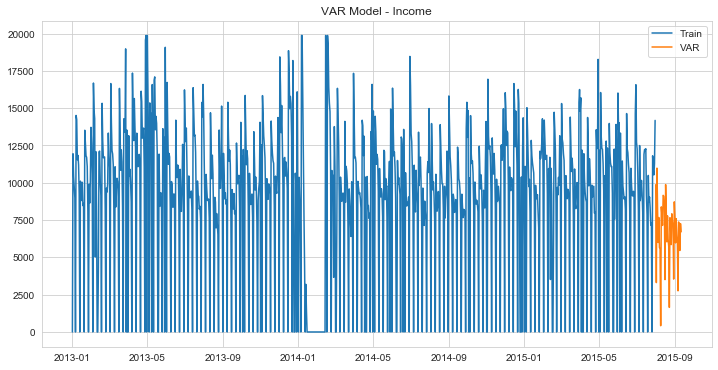

In [287]:

plt.figure(figsize=(12,6)) 
plt.plot( store_25['Sales'], label='Train')
#plt.plot(sorted_test['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Income')
plt.show()

## VARMAX for store 25  

In [288]:
scaler = MinMaxScaler()
store_25[['Sales','Customers']] = scaler.fit_transform(store_25[['Sales','Customers']])

In [289]:
# Johnsen test to find cointegration and as trace_Stat
#is greater than critical values for 95% and 99% confidence interval they are stationary but not co integrated
joh_model1 = coint_johansen(train_25[['Sales','Customers']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model1)

   max_eig_stat  trace_stat
0    150.576806  188.318846
1     37.742041   37.742041 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



In [290]:
train_25 = store_25.loc['2013-01-01': '2015-05-31']
test_25 = store_25.loc[ '2015-06-01':]

In [291]:
exog = train_25[['Promo','Open']]
mod = sm.tsa.VARMAX(train_25[['Sales','Customers']], order=(15,0), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  881
Model:                           VARX(15)   Log Likelihood                2820.628
Date:                    Mon, 12 Apr 2021   AIC                          -5507.256
Time:                            13:19:39   BIC                          -5186.926
Sample:                        01-01-2013   HQIC                         -5384.763
                             - 05-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):              333.02, 175.55   Jarque-Bera (JB):      1133.11, 571.06
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.65, 0.84   Skew:                     -0.13, -0.99
Prob(H) (two-sided):            0.00, 0.15   Kurtosis:                   8.55, 6.42


In [292]:
#predicting future sales for 6 weeks
start_index = test_25.index.min()
end_index = test_25.index.max()
#print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index,exog=test_25[['Promo','Open']])

In [293]:
# inverse transformation to actual values
train_25[['Sales','Customers']]=scaler.inverse_transform(train_25[['Sales','Customers']])
test_25[['Sales','Customers']] = scaler.inverse_transform(test_25[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

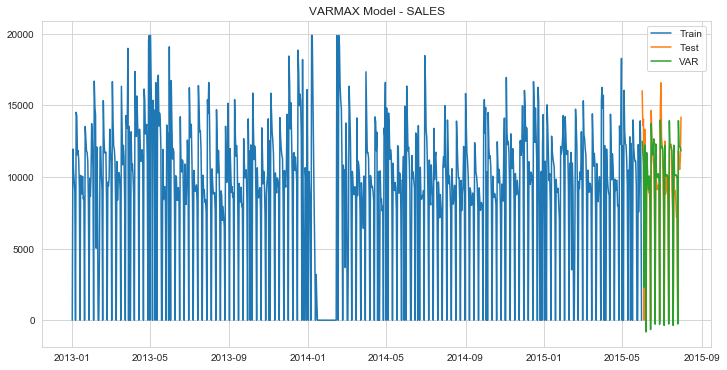

In [294]:
#plotting the final values
plt.figure(figsize=(12,6)) 
plt.plot( train_25['Sales'], label='Train')
plt.plot(test_25['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VARMAX Model - SALES')
plt.show()

In [295]:
rmse = np.sqrt(mean_squared_error(test_25['Sales'], predictions['Sales'][test_25.index.min():])).round(2)
mape = np.round(np.mean(np.abs( test_25['Sales']-predictions['Sales'][test_25.index.min():])/((np.abs(test_25['Sales'])+ np.abs(predictions['Sales']))/2))*100,2)

tempResults = pd.DataFrame({'Method':['VAR method'], 'RMSE': [rmse],'SMAPE': [mape] })
results = pd.DataFrame({'Method':['Naive method'], 'SMAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'SMAPE']]
results

Method     RMSE  SMAPE
0  Naive method  1515.54  39.63

## VARMAX for future sales

In [296]:
scaler = MinMaxScaler()
store_25[['Sales','Customers']] = scaler.fit_transform(store_25[['Sales','Customers']])

In [297]:
exog = store_25[['Promo','Open']]
mod = sm.tsa.VARMAX(store_25[['Sales','Customers']], order=(15,0), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  942
Model:                           VARX(15)   Log Likelihood                3000.825
Date:                    Mon, 12 Apr 2021   AIC                          -5867.649
Time:                            13:25:35   BIC                          -5542.833
Sample:                        01-01-2013   HQIC                         -5743.839
                             - 07-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):              348.04, 174.76   Jarque-Bera (JB):      1160.59, 439.72
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.67, 0.96   Skew:                      0.02, -0.86
Prob(H) (two-sided):            0.00, 0.69   Kurtosis:                   8.44, 5.88


In [298]:
#prediction of future sales
start_index = ex_variables.index.min()
end_index = ex_variables.index.max()
print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index,exog=ex_variables[['Promo','Open']])

2015-08-01 00:00:00 2015-09-11 00:00:00


In [299]:
#inverse transformation to actual values
store_25[['Sales','Customers']]=scaler.inverse_transform(store_25[['Sales','Customers']])
#test_3[['Sales','Customers']] = scaler.inverse_transform(test_3[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

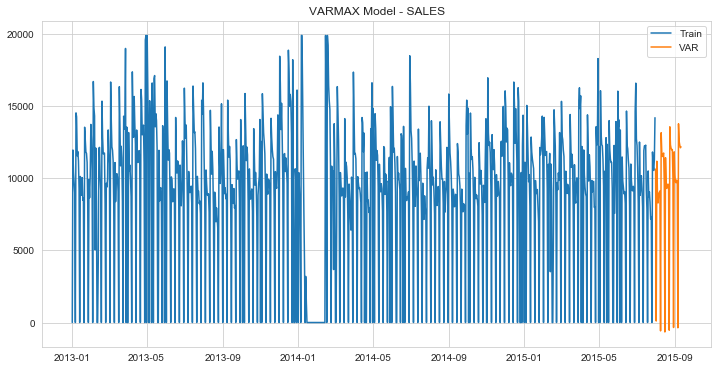

In [300]:
#plotting the results
plt.figure(figsize=(12,6)) 
plt.plot( store_25['Sales'], label='Train')
#plt.plot(test_3['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VARMAX Model - SALES')
plt.show()

## Store 29


In [301]:
store_29 = data[data.Store.isin([29])]

In [302]:
store_29.Sales.describe(percentiles = [0.01,0.10,0.25,0.50,0.75,0.90,0.95,0.99,0.995])

count      942.000000
mean      6090.403397
std       3433.366553
min          0.000000
1%           0.000000
10%          0.000000
25%       4972.500000
50%       6361.500000
75%       8072.000000
90%      10014.400000
95%      11549.850000
99%      13808.260000
99.5%    14795.505000
max      15758.000000
Name: Sales, dtype: float64

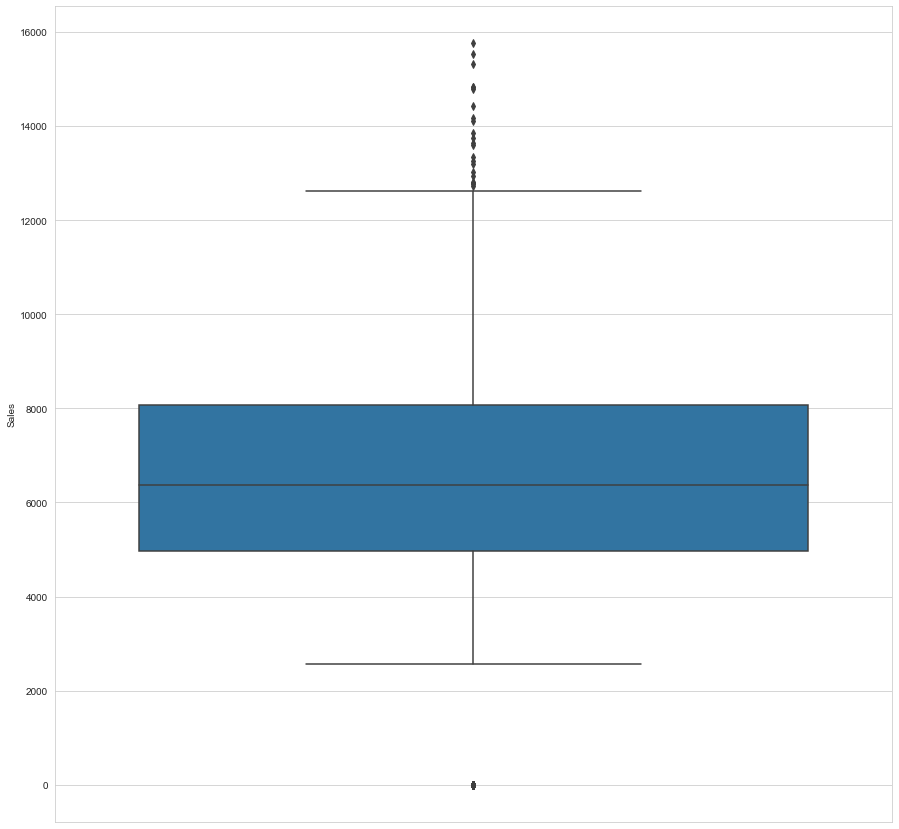

In [303]:

sns.set_style("whitegrid")

plt.figure(figsize=(15, 15))

sns.boxplot( y='Sales', data=store_29)

In [304]:
store_29_test = data[data.Store.isin([29])]

In [305]:
store_29_test= store_29_test[store_29_test.Sales > 14795]

In [306]:
store_29_test

Store StoreType  Assortment  CompetitionDistance  Promo2  \
25870     29         d           2               2170.0       0   
25884     29         d           2               2170.0       0   
25947     29         d           2               2170.0       0   
26052     29         d           2               2170.0       0   
26416     29         d           2               2170.0       0   

       PromoInterval       Date  Sales  Customers  Open  Promo  StateHoliday  \
25870            0.0 2015-06-15  14823       1059     1      1             0   
25884            0.0 2015-06-01  15316       1111     1      1             0   
25947            0.0 2015-03-30  14829        996     1      1             0   
26052            0.0 2014-12-15  15530       1092     1      1             0   
26416            0.0 2013-12-16  15758       1091     1      1             0   

       SchoolHoliday  
25870              0  
25884              0  
25947              1  
26052              0  
26416              0

In [307]:
store_29= store_29[store_29.Sales < 14795]

In [308]:
scaler = MinMaxScaler()
store_29[['Sales','Customers']] = scaler.fit_transform(store_29[['Sales','Customers']])

In [309]:
store_29=store_29.append({'Store': 29,'StoreType' : 'd','Assortment':2,
                  'CompetitionDistance' : 2170,'Date' : '2013-12-16',
                   'Sales':0.794771330135783,'Customers':0.409090909090909,
                  'Open':1,'Promo':1,
                  'StateHoliday':0,'SchoolHoliday':0,
                  'Promo2':0,'PromoInterval':0},
                  ignore_index=True)

In [310]:
store_29=store_29.append({'Store': 29,'StoreType' : 'd','Assortment':2,
                  'CompetitionDistance' : 2170,'Date' : '2014-12-15',
                   'Sales':0.836046747280956,'Customers':0.433926897844423,
                  'Open':1,'Promo':1,
                  'StateHoliday':0,'SchoolHoliday':0,
                  'Promo2':0,'PromoInterval':0},
                  ignore_index=True)

In [311]:
store_29=store_29.append({'Store': 29,'StoreType' : 'd','Assortment':2,
                  'CompetitionDistance' : 2170,'Date' : '2015-03-30',
                   'Sales':0.78031480105384,'Customers':0.385660731021555,
                  'Open':1,'Promo':1,
                  'StateHoliday':0,'SchoolHoliday':0,
                  'Promo2':0,'PromoInterval':0},
                  ignore_index=True)

In [312]:
store_29=store_29.append({'Store': 29,'StoreType' : 'd','Assortment':2,
                  'CompetitionDistance' : 2170,'Date' : '2015-06-15',
                   'Sales':1,'Customers':1,
                  'Open':1,'Promo':1,
                  'StateHoliday':0,'SchoolHoliday':0,
                  'Promo2':0,'PromoInterval':0},
                  ignore_index=True)

In [313]:
store_29=store_29.append({'Store': 29,'StoreType' : 'd','Assortment':2,
                  'CompetitionDistance' : 2170,'Date' : '2015-06-01',
                   'Sales':1,'Customers':1,
                  'Open':1,'Promo':1,
                  'StateHoliday':0,'SchoolHoliday':0,
                  'Promo2':0,'PromoInterval':0},
                  ignore_index=True)

In [314]:
store_29['Date'] = pd.to_datetime(store_29['Date'], format='%Y-%m')

In [315]:
store_29.index=store_29.Date
store_29=store_29.sort_index()
store_29.index.freq = store_29.index.inferred_freq
store_29.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2015-07-22', '2015-07-23', '2015-07-24', '2015-07-25',
               '2015-07-26', '2015-07-27', '2015-07-28', '2015-07-29',
               '2015-07-30', '2015-07-31'],
              dtype='datetime64[ns]', name='Date', length=942, freq='D')

In [316]:
train_29 = store_29.loc['2013-01-01': '2015-05-31']
test_29 = store_29.loc[ '2015-06-01':]

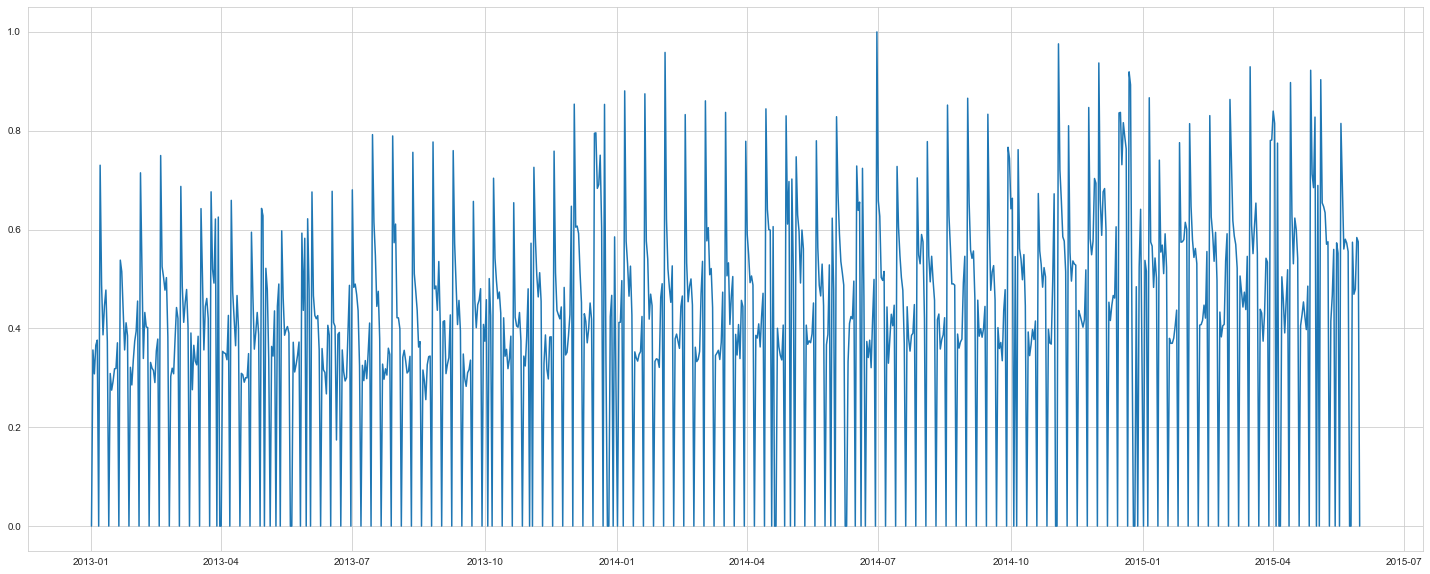

In [317]:
plt.figure(figsize=(25,10))
plt.plot(train_29['Sales'], label='Sales')

plt.show()

## dickey Fuller Test to find stationarity

In [318]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train_29['Sales'].dropna())

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.356284
Critical Values @ 0.05: -2.86
p-value: 0.012543


In [319]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train_29['Customers'].dropna())

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -3.364605
Critical Values @ 0.05: -2.86
p-value: 0.012226


In [320]:
# find lag order
model = VAR(train_29[['Sales','Customers']])
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -9.27421230645311
BIC :  -9.241621929811254
FPE :  9.381251828824894e-05
HQIC:  -9.2617491394011 

Lag Order = 2
AIC :  -9.351831573417574
BIC :  -9.297465419860291
FPE :  8.680630262833173e-05
HQIC:  -9.331039813070356 

Lag Order = 3
AIC :  -9.36272106950045
BIC :  -9.28653991652677
FPE :  8.586619084818426e-05
HQIC:  -9.333584807444476 

Lag Order = 4
AIC :  -9.364608922350463
BIC :  -9.266573431058902
FPE :  8.570430662856952e-05
HQIC:  -9.327112201771378 

Lag Order = 5
AIC :  -9.399856664553887
BIC :  -9.279927379165073
FPE :  8.273614214136763e-05
HQIC:  -9.35398348003538 

Lag Order = 6
AIC :  -9.608933339924981
BIC :  -9.467070687301783
FPE :  6.71266807262355e-05
HQIC:  -9.554667637246581 

Lag Order = 7
AIC :  -10.104884894172411
BIC :  -9.941049183337553
FPE :  4.0879650860626014e-05
HQIC:  -10.042210570106214 

Lag Order = 8
AIC :  -10.154996907320704
BIC :  -9.969148328971853
FPE :  3.888169205185252e-05
HQIC:  -10.083897809427024 

Lag Order = 9
AIC 

In [321]:
#Build a model
mod = sm.tsa.VARMAX(train_29[['Sales','Customers']], order=(15,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  881
Model:                            VAR(15)   Log Likelihood                2153.704
Date:                    Mon, 12 Apr 2021   AIC                          -4181.407
Time:                            13:27:17   BIC                          -3880.200
Sample:                        01-01-2013   HQIC                         -4066.226
                             - 05-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):               100.40, 47.48   Jarque-Bera (JB):    1109.08, 42627.75
Prob(Q):                        0.00, 0.19   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.89, 3.19   Skew:                     -0.50, -3.53
Prob(H) (two-sided):            0.00, 0.00   Kurtosis:                  8.41, 36.34


In [322]:
#predict slaes for test
start_index = test_29.index.min()
end_index = test_29.index.max()
#print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index)

In [323]:
# Inverse transformation of sales and custmers
train_29[['Sales','Customers']]=scaler.inverse_transform(train_29[['Sales','Customers']])
test_29[['Sales','Customers']] = scaler.inverse_transform(test_29[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

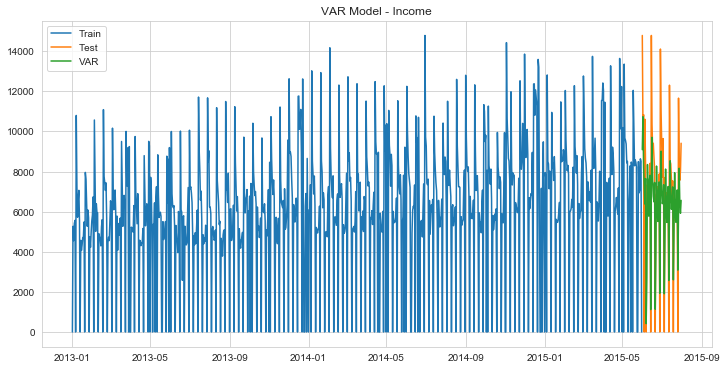

In [324]:
#plotting all the values
plt.figure(figsize=(12,6)) 
plt.plot( train_29['Sales'], label='Train')
plt.plot(test_29['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Income')
plt.show()

In [325]:
#Finding the error
rmse = np.sqrt(mean_squared_error(test_29['Sales'], predictions['Sales'][test_29.index.min():])).round(2)
smape = np.round(np.mean(np.abs( test_29['Sales']-predictions['Sales'][test_29.index.min():])/((np.abs(test_29['Sales'])+ np.abs(predictions['Sales']))/2))*100,2)

tempResults = pd.DataFrame({'Method':['VAR method'], 'RMSE': [rmse],'sMAPE': [smape] })
results = pd.DataFrame({'Method':['Naive method'], 'sMAPE': [smape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'sMAPE']]
results

Method     RMSE  sMAPE
0  Naive method  2689.11  49.46

## predict future 6 weeks sales

In [326]:
#Scaling the values
scaler = MinMaxScaler()
store_29[['Sales','Customers']] = scaler.fit_transform(store_29[['Sales','Customers']])

In [327]:
#Building the model
mod = sm.tsa.VARMAX(store_29[['Sales','Customers']], order=(15,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  942
Model:                            VAR(15)   Log Likelihood                2313.517
Date:                    Mon, 12 Apr 2021   AIC                          -4501.034
Time:                            13:28:36   BIC                          -4195.609
Sample:                        01-01-2013   HQIC                         -4384.615
                             - 07-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):               115.88, 46.92   Jarque-Bera (JB):    1100.86, 43662.91
Prob(Q):                        0.00, 0.21   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.96, 2.93   Skew:                     -0.53, -3.41
Prob(H) (two-sided):            0.00, 0.00   Kurtosis:                  8.19, 35.65


In [328]:
#prediction of future sales
start_index = ex_variables.index.min()
end_index = ex_variables.index.max()
#print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index)

In [329]:
#inverse transformation of values
store_29[['Sales','Customers']]=scaler.inverse_transform(store_29[['Sales','Customers']])
#sorted_test[['Sales','Customers']] = scaler.inverse_transform(sorted_test[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

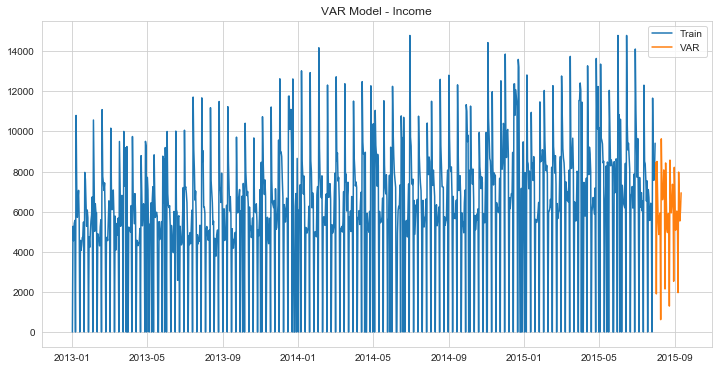

In [330]:
#plotting the values
plt.figure(figsize=(12,6)) 
plt.plot( store_29['Sales'], label='Train')
#plt.plot(sorted_test['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Income')
plt.show()

#### Johansen test for Cointegration

In [331]:
joh_model1 = coint_johansen(train_29[['Sales','Customers']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model1)

   max_eig_stat  trace_stat
0    164.544053  197.206153
1     32.662099   32.662099 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



In [332]:
# As we can see the Tracr_sta values are greater than critical values at all confidence levels

## VARMAX for store 29

In [333]:
#scaling the values
scaler = MinMaxScaler()
store_29[['Sales','Customers']] = scaler.fit_transform(store_29[['Sales','Customers']])

In [334]:
# Dividing tehm into train and test
train_29 = store_29.loc['2013-01-01': '2015-05-31']
test_29 = store_29.loc[ '2015-06-01':]

In [335]:
# training the model
exog = train_29[['Promo','Open']]
mod = sm.tsa.VARMAX(train_29[['Sales','Customers']], order=(15,0), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  881
Model:                           VARX(15)   Log Likelihood                2781.205
Date:                    Mon, 12 Apr 2021   AIC                          -5428.411
Time:                            13:33:41   BIC                          -5108.080
Sample:                        01-01-2013   HQIC                         -5305.917
                             - 05-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):              378.73, 109.70   Jarque-Bera (JB):    211.73, 185360.44
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.37, 2.92   Skew:                      0.54, -5.94
Prob(H) (two-sided):            0.01, 0.00   Kurtosis:                  5.15, 73.06


In [336]:
#predicting future sales
start_index = test_29.index.min()
end_index = test_29.index.max()
#print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index,exog=test_29[['Promo','Open']])

In [337]:
#Inverse transformation of sales and customers
train_29[['Sales','Customers']]=scaler.inverse_transform(train_29[['Sales','Customers']])
test_29[['Sales','Customers']] = scaler.inverse_transform(test_29[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

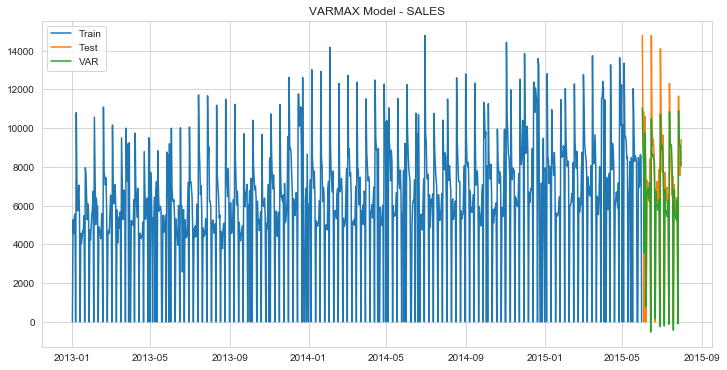

In [338]:
# Plot the values
plt.figure(figsize=(12,6)) 
plt.plot( train_29['Sales'], label='Train')
plt.plot(test_29['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VARMAX Model - SALES')
plt.show()

In [339]:
#Finding the error
rmse = np.sqrt(mean_squared_error(test_29['Sales'], predictions['Sales'][test_29.index.min():])).round(2)
smape = np.round(np.mean(np.abs( test_29['Sales']-predictions['Sales'][test_29.index.min():])/((np.abs(test_29['Sales'])+ np.abs(predictions['Sales']))/2))*100,2)

tempResults = pd.DataFrame({'Method':['VAR method'], 'RMSE': [rmse],'sMAPE': [smape] })
results = pd.DataFrame({'Method':['Naive method'], 'sMAPE': [smape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'sMAPE']]
results

Method     RMSE  sMAPE
0  Naive method  1380.89  40.42

#### VARMAX for prediction of future 6 weeks

In [340]:
#Scaling uthe sales values
scaler = MinMaxScaler()
store_29[['Sales','Customers']] = scaler.fit_transform(store_29[['Sales','Customers']])

In [341]:
# training the model
exog = store_29[['Promo','Open']]
mod = sm.tsa.VARMAX(store_29[['Sales','Customers']], order=(15,0), trend='n', exog=exog)
res = mod.fit(maxiter=3000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  942
Model:                           VARX(15)   Log Likelihood                2980.916
Date:                    Mon, 12 Apr 2021   AIC                          -5827.832
Time:                            13:39:33   BIC                          -5503.015
Sample:                        01-01-2013   HQIC                         -5704.021
                             - 07-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):              390.31, 121.06   Jarque-Bera (JB):    203.09, 193150.69
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.43, 2.95   Skew:                      0.54, -5.78
Prob(H) (two-sided):            0.00, 0.00   Kurtosis:                  5.01, 72.19


In [342]:
#prediction of future sales
start_index = ex_variables.index.min()
end_index = ex_variables.index.max()
#print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index,exog = ex_variables[['Promo','Open']])

In [343]:
#inverse transformation of sales and customers
store_29[['Sales','Customers']]=scaler.inverse_transform(store_29[['Sales','Customers']])
#sorted_test[['Sales','Customers']] = scaler1.inverse_transform(sorted_test[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

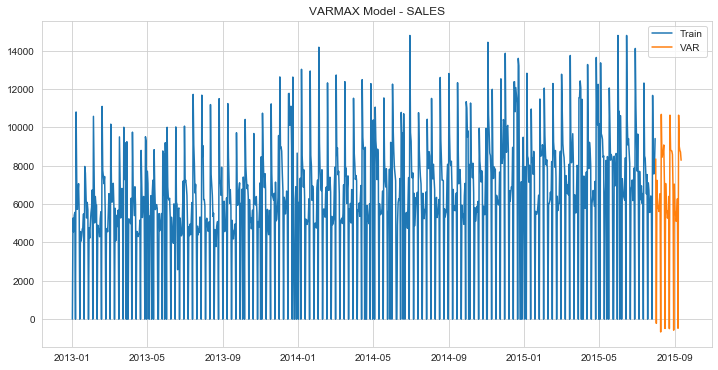

In [344]:
#Plotting final values
plt.figure(figsize=(12,6)) 
plt.plot( store_29['Sales'], label='Train')
#plt.plot(test_3['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VARMAX Model - SALES')
plt.show()

In [345]:
predictions['Sales']

2015-08-01     8343.736323
2015-08-02     -221.236973
2015-08-03     7233.943045
2015-08-04     5809.178063
2015-08-05     5906.561304
2015-08-06     5609.894409
2015-08-07     6146.846317
2015-08-08     6536.534591
2015-08-09     -669.511723
2015-08-10    10671.650068
2015-08-11     8436.242013
2015-08-12     8573.124536
2015-08-13     8692.371938
2015-08-14     9076.511073
2015-08-15     7166.071302
2015-08-16     -485.947844
2015-08-17     7069.383591
2015-08-18     5674.672499
2015-08-19     5637.600252
2015-08-20     5263.121063
2015-08-21     5595.927891
2015-08-22     6396.893664
2015-08-23     -496.025221
2015-08-24    10630.471408
2015-08-25     8810.047120
2015-08-26     8784.093243
2015-08-27     8764.848066
2015-08-28     8573.894429
2015-08-29     6651.263937
2015-08-30     -574.467710
2015-08-31     7035.996973
2015-09-01     5685.777136
2015-09-02     5507.438332
2015-09-03     5096.040222
2015-09-04     5304.000060
2015-09-05     6272.378406
2015-09-06     -475.473287
2

## Store 31

In [346]:
#Getting vales for store 31
store_31 = data[data.Store.isin([31])]

In [347]:
store_31.Sales.describe(percentiles = [0.01,0.10,0.25,0.50,0.75,0.90,0.95,0.99,0.995])

count      942.000000
mean      4879.132696
std       2506.671454
min          0.000000
1%           0.000000
10%          0.000000
25%       4370.250000
50%       5403.000000
75%       6316.000000
90%       7277.800000
95%       8153.350000
99%      10030.550000
99.5%    10643.925000
max      13252.000000
Name: Sales, dtype: float64

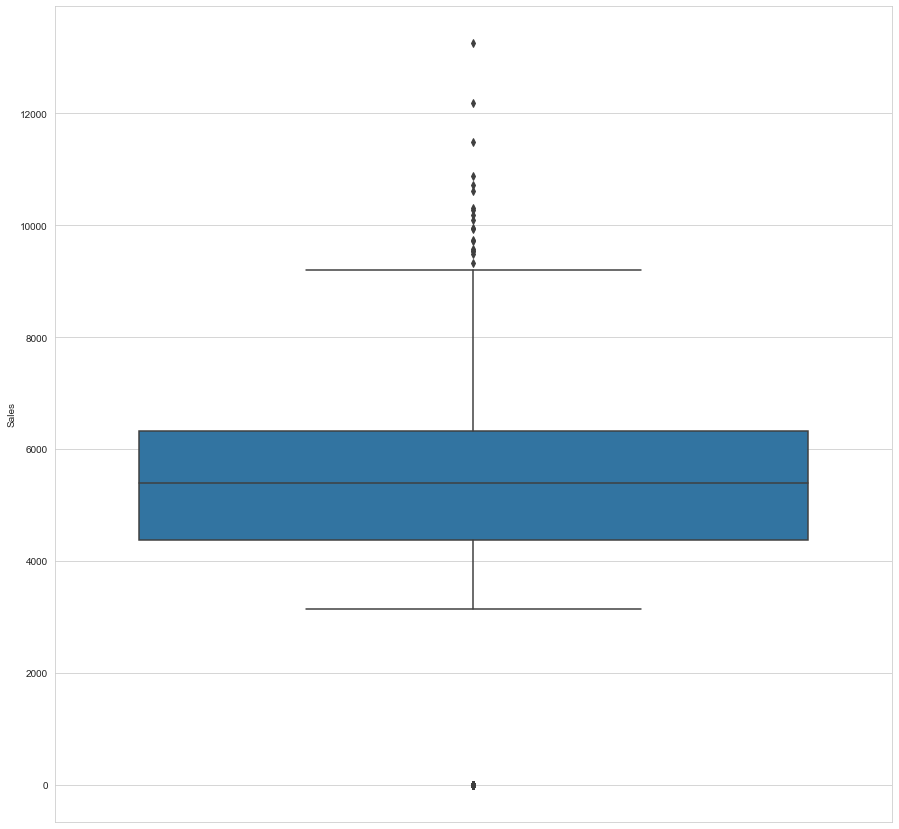

In [348]:

sns.set_style("whitegrid")

plt.figure(figsize=(15, 15))

sns.boxplot( y='Sales', data=store_31)

In [349]:
store_31_test= store_31[store_31.Sales > 11000]

In [350]:
store_31_test

Store StoreType  Assortment  CompetitionDistance  Promo2  \
27928     31         d           2               9800.0       0   
28293     31         d           2               9800.0       0   
28300     31         d           2               9800.0       0   

       PromoInterval       Date  Sales  Customers  Open  Promo  StateHoliday  \
27928            0.0 2014-12-23  11487       1045     1      0             0   
28293            0.0 2013-12-23  13252       1310     1      0             0   
28300            0.0 2013-12-16  12192        915     1      1             0   

       SchoolHoliday  
27928              1  
28293              1  
28300              0

In [351]:
#Removing outliers which are greater than 11000
store_31= store_31[store_31.Sales < 11000]

In [352]:
#scaling the values
scaler = MinMaxScaler()
store_31[['Sales','Customers']] = scaler.fit_transform(store_31[['Sales','Customers']])

In [353]:
# imputing the values which are deleted to max values as they aare actuallt greater than max currently

In [354]:
store_31=store_31.append({'Store': 31,'StoreType' : 'd','Assortment':2,
                  'CompetitionDistance' : 9800.0,'Date' : '2013-12-23',
                   'Sales':1,'Customers':1,
                  'Open':1,'Promo':0,
                  'StateHoliday':0,'SchoolHoliday':1,
                  'Promo2':0,'PromoInterval':0},
                  ignore_index=True)

In [355]:
store_31=store_31.append({'Store': 31,'StoreType' : 'd','Assortment':2,
                  'CompetitionDistance' : 9800.0,'Date' : '2013-12-16',
                   'Sales':1,'Customers':1,
                  'Open':1,'Promo':1,
                  'StateHoliday':0,'SchoolHoliday':0,
                  'Promo2':0,'PromoInterval':0},
                  ignore_index=True)

In [356]:
store_31=store_31.append({'Store': 31,'StoreType' : 'd','Assortment':2,
                  'CompetitionDistance' : 9800.0,'Date' : '2014-12-23',
                   'Sales':1,'Customers':1,
                  'Open':1,'Promo':0,
                  'StateHoliday':0,'SchoolHoliday':1,
                  'Promo2':0,'PromoInterval':0},
                  ignore_index=True)

In [357]:
store_31['Date'] = pd.to_datetime(store_31['Date'], format='%Y-%m')

In [358]:
store_31.index=store_31.Date
store_31=store_31.sort_index()
store_31.index.freq = store_31.index.inferred_freq
store_31.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2015-07-22', '2015-07-23', '2015-07-24', '2015-07-25',
               '2015-07-26', '2015-07-27', '2015-07-28', '2015-07-29',
               '2015-07-30', '2015-07-31'],
              dtype='datetime64[ns]', name='Date', length=942, freq='D')

In [359]:
train_31 = store_31.loc['2013-01-01': '2015-05-31']
test_31 = store_31.loc[ '2015-06-01':]

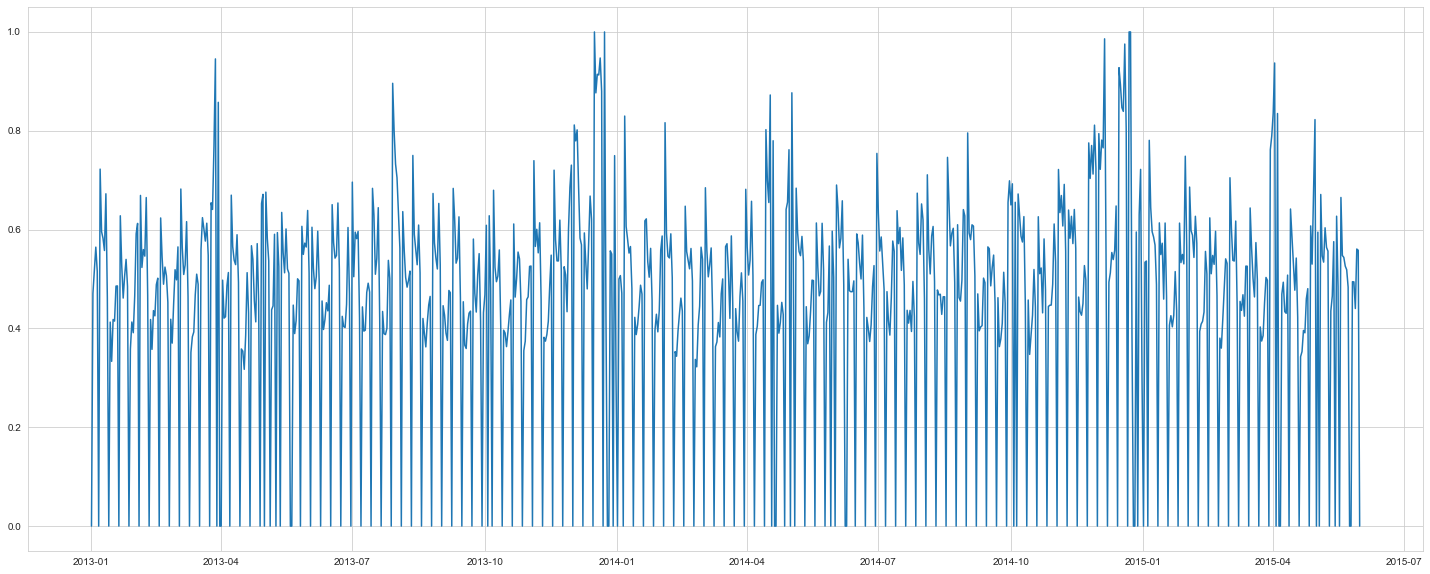

In [360]:
plt.figure(figsize=(25,10))
plt.plot(train_31['Sales'], label='Sales')

plt.show()

In [361]:
# Stationarity Tests
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train_31['Sales'].dropna())

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -4.465296
Critical Values @ 0.05: -2.86
p-value: 0.000227


In [362]:
#Stationarity tests for customers
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train_31['Customers'].dropna())

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -4.924731
Critical Values @ 0.05: -2.86
p-value: 0.000031


In [363]:
#Finding lag order
model = VAR(train_31[['Sales','Customers']])
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -9.50127904116943
BIC :  -9.468688664527575
FPE :  7.475615646551664e-05
HQIC:  -9.488815874117421 

Lag Order = 2
AIC :  -9.569595720242503
BIC :  -9.515229566685221
FPE :  6.981962167813766e-05
HQIC:  -9.548803959895286 

Lag Order = 3
AIC :  -9.593961347069756
BIC :  -9.517780194096076
FPE :  6.813901023146184e-05
HQIC:  -9.564825085013782 

Lag Order = 4
AIC :  -9.62368781772264
BIC :  -9.525652326431079
FPE :  6.614333842076596e-05
HQIC:  -9.586191097143555 

Lag Order = 5
AIC :  -9.723312822381923
BIC :  -9.603383536993109
FPE :  5.987148664433306e-05
HQIC:  -9.677439637863415 

Lag Order = 6
AIC :  -9.95064528969536
BIC :  -9.808782637072163
FPE :  4.769705431082165e-05
HQIC:  -9.89637958701696 

Lag Order = 7
AIC :  -10.560631041371936
BIC :  -10.396795330537078
FPE :  2.591666655462578e-05
HQIC:  -10.497956717305739 

Lag Order = 8
AIC :  -10.62862209837903
BIC :  -10.442773520030178
FPE :  2.4213208921047404e-05
HQIC:  -10.557523000485348 

Lag Order = 9


In [364]:
#Building the model with VAR
#exog = train['Promo2']
mod = sm.tsa.VARMAX(train_31[['Sales','Customers']], order=(15,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  881
Model:                            VAR(15)   Log Likelihood                2290.607
Date:                    Mon, 12 Apr 2021   AIC                          -4455.214
Time:                            13:41:30   BIC                          -4154.007
Sample:                        01-01-2013   HQIC                         -4340.033
                             - 05-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):                93.15, 34.48   Jarque-Bera (JB):       1586.89, 29.08
Prob(Q):                        0.00, 0.72   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.40, 1.15   Skew:                     -0.91, -0.19
Prob(H) (two-sided):            0.00, 0.24   Kurtosis:                   9.32, 3.81


In [365]:
#predicting test data
start_index = test_31.index.min()
end_index = test_31.index.max()
#print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index)

In [366]:
#inverse transforming the dataset values
train_31[['Sales','Customers']]=scaler.inverse_transform(train_31[['Sales','Customers']])
test_31[['Sales','Customers']] = scaler.inverse_transform(test_31[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

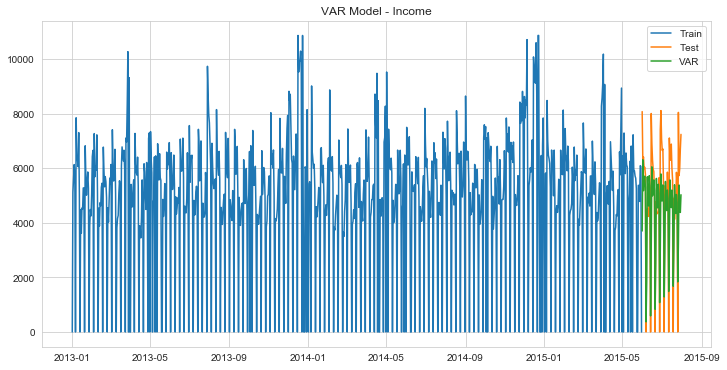

In [367]:
#plotting the values
plt.figure(figsize=(12,6)) 
plt.plot( train_31['Sales'], label='Train')
plt.plot(test_31['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Income')
plt.show()

In [368]:
rmse = np.sqrt(mean_squared_error(test_31['Sales'], predictions['Sales'][test_31.index.min():])).round(2)
smape = np.round(np.mean(np.abs( test_31['Sales']-predictions['Sales'][test_31.index.min():])/((np.abs(test_31['Sales'])+ np.abs(predictions['Sales']))/2))*100,2)

tempResults = pd.DataFrame({'Method':['VAR method'], 'RMSE': [rmse],'sMAPE': [smape] })
results = pd.DataFrame({'Method':['Naive method'], 'sMAPE': [smape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'sMAPE']]
results

Method    RMSE  sMAPE
0  Naive method  1750.3  48.16

## prediction of future sales VAR

In [369]:
#scaling the values 
scaler = MinMaxScaler()
store_31[['Sales','Customers']] = scaler.fit_transform(store_31[['Sales','Customers']])

In [370]:
#Building the model
mod = sm.tsa.VARMAX(store_31[['Sales','Customers']], order=(15,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  942
Model:                            VAR(15)   Log Likelihood                2480.189
Date:                    Mon, 12 Apr 2021   AIC                          -4834.379
Time:                            13:42:39   BIC                          -4528.954
Sample:                        01-01-2013   HQIC                         -4717.960
                             - 07-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):               103.17, 40.41   Jarque-Bera (JB):       1847.04, 31.72
Prob(Q):                        0.00, 0.45   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.40, 1.09   Skew:                     -0.91, -0.15
Prob(H) (two-sided):            0.00, 0.46   Kurtosis:                   9.61, 3.84


In [371]:
#predicting future 6 weeks sales
start_index = ex_variables.index.min()
end_index = ex_variables.index.max()
#print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index)

In [372]:
store_31[['Sales','Customers']]=scaler.inverse_transform(store_31[['Sales','Customers']])
#sorted_test[['Sales','Customers']] = scaler1.inverse_transform(sorted_test[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

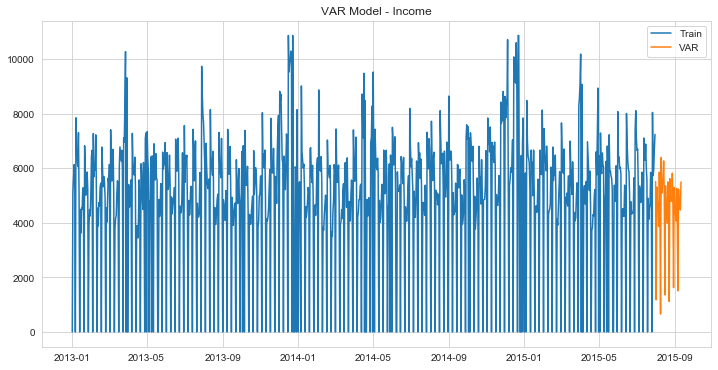

In [373]:
plt.figure(figsize=(12,6)) 
plt.plot( store_31['Sales'], label='Train')
#plt.plot(sorted_test['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Income')
plt.show()

In [374]:
#Johansen test for finding conintegration
joh_model1 = coint_johansen(train_31[['Sales','Customers']],-1,1) # k_ar_diff +1 = K
joh_output(joh_model1)

   max_eig_stat  trace_stat
0    118.041330  149.839696
1     31.798366   31.798366 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



#### trace_stat is greater than critical values for 99% and 95% confidence intervals .r=the series is staionary and not conintegrated.The rank is 2. 

## VARMAX

In [375]:
# Scaling the values
scaler = MinMaxScaler()
store_31[['Sales','Customers']] = scaler.fit_transform(store_31[['Sales','Customers']])

In [376]:
#Dividing the data into train and test split
train_31 = store_31.loc['2013-01-01': '2015-05-31']
test_31 = store_31.loc[ '2015-06-01':]

In [377]:
#Building a model using exog variables
exog = train_31[['Promo','Open']]
mod = sm.tsa.VARMAX(train_31[['Sales','Customers']], order=(15,1), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  881
Model:                       VARMAX(15,1)   Log Likelihood                3063.252
Date:                    Mon, 12 Apr 2021   AIC                          -5984.503
Time:                            13:50:48   BIC                          -5645.048
Sample:                        01-01-2013   HQIC                         -5854.696
                             - 05-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):               102.91, 84.64   Jarque-Bera (JB):      425.00, 1372.67
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.55, 0.74   Skew:                      0.57, -0.50
Prob(H) (two-sided):            0.00, 0.01   Kurtosis:                   6.21, 9.03


In [378]:
#making predictions on test data
start_index = test_31.index.min()
end_index = test_31.index.max()
#print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index,exog=test_31[['Promo','Open']])

In [379]:
# Inverse transforation of variables
train_31[['Sales','Customers']]=scaler.inverse_transform(train_31[['Sales','Customers']])
test_31[['Sales','Customers']] = scaler.inverse_transform(test_31[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

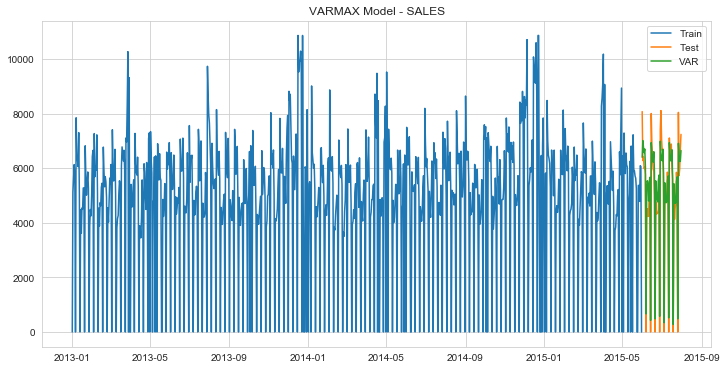

In [380]:
#plotting the values
plt.figure(figsize=(12,6)) 
plt.plot( train_31['Sales'], label='Train')
plt.plot(test_31['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VARMAX Model - SALES')
plt.show()

In [381]:
rmse = np.sqrt(mean_squared_error(test_31['Sales'], predictions['Sales'][test_31.index.min():])).round(2)
smape = np.round(np.mean(np.abs( test_31['Sales']-predictions['Sales'][test_31.index.min():])/((np.abs(test_31['Sales'])+ np.abs(predictions['Sales']))/2))*100,2)

tempResults = pd.DataFrame({'Method':['VAR method'], 'RMSE': [rmse],'sMAPE': [smape] })
results = pd.DataFrame({'Method':['Naive method'], 'sMAPE': [smape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'sMAPE']]
results

Method    RMSE  sMAPE
0  Naive method  628.23  34.03

## predict future sales using VARMAX

In [382]:
#Scaling the values
scaler = MinMaxScaler()
store_31[['Sales','Customers']] = scaler.fit_transform(store_31[['Sales','Customers']])

In [383]:
#Building the model
exog = store_31[['Promo','Open']]
mod = sm.tsa.VARMAX(store_31[['Sales','Customers']], order=(15,1), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  942
Model:                       VARMAX(15,1)   Log Likelihood                3275.064
Date:                    Mon, 12 Apr 2021   AIC                          -6408.128
Time:                            14:01:36   BIC                          -6063.919
Sample:                        01-01-2013   HQIC                         -6276.926
                             - 07-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):              122.38, 105.75   Jarque-Bera (JB):      563.99, 1153.19
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.57, 0.74   Skew:                      0.69, -0.42
Prob(H) (two-sided):            0.00, 0.01   Kurtosis:                   6.53, 8.36


In [384]:
#prediction of future sales using ex_varibles
start_index = ex_variables.index.min()
end_index = ex_variables.index.max()
#print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index,exog=ex_variables[['Promo','Open']])

In [385]:
store_31[['Sales','Customers']]=scaler.inverse_transform(store_31[['Sales','Customers']])
#sorted_test[['Sales','Customers']] = scaler1.inverse_transform(sorted_test[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

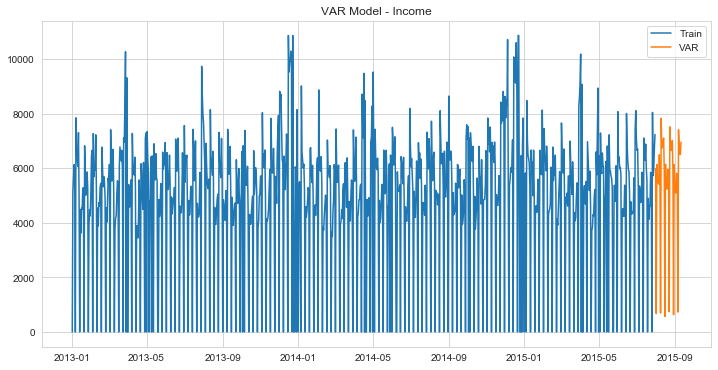

In [386]:
#Ploting values
plt.figure(figsize=(12,6)) 
plt.plot( store_31['Sales'], label='Train')
#plt.plot(sorted_test['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Income')
plt.show()

In [387]:
predictions['Sales']

2015-08-01    5988.694761
2015-08-02     677.561855
2015-08-03    6144.324252
2015-08-04    5598.336180
2015-08-05    5510.292517
2015-08-06    5426.492571
2015-08-07    6499.418757
2015-08-08    5732.943326
2015-08-09     694.979920
2015-08-10    7839.741793
2015-08-11    6744.373877
2015-08-12    6844.378489
2015-08-13    6987.748546
2015-08-14    7115.857158
2015-08-15    5863.107317
2015-08-16     569.098337
2015-08-17    6156.041869
2015-08-18    5545.483298
2015-08-19    5241.735980
2015-08-20    5254.363365
2015-08-21    5962.777616
2015-08-22    5672.633810
2015-08-23     740.118133
2015-08-24    7523.583104
2015-08-25    6862.090418
2015-08-26    6660.997327
2015-08-27    6664.006346
2015-08-28    7025.997074
2015-08-29    5917.161021
2015-08-30     634.110821
2015-08-31    6137.101885
2015-09-01    5464.741963
2015-09-02    5107.904111
2015-09-03    5097.726445
2015-09-04    5823.025620
2015-09-05    5742.362567
2015-09-06     729.950353
2015-09-07    7415.633026
2015-09-08  

## store 46

In [388]:
# Getting values for store 46
store_46 = data[data.Store.isin([46])]

In [389]:
store_46.index = store_46.Date
store_46=store_46.sort_index()
train_46 = store_46.loc['2013-01-01': '2014-07-30']


In [390]:
train_46 = store_46.loc['2013-01-01': '2014-07-30']
train_46

Store StoreType  Assortment  CompetitionDistance  Promo2  \
Date                                                                   
2013-01-01     46         c           0               1200.0       1   
2013-01-02     46         c           0               1200.0       1   
2013-01-03     46         c           0               1200.0       1   
2013-01-04     46         c           0               1200.0       1   
2013-01-05     46         c           0               1200.0       1   
...           ...       ...         ...                  ...     ...   
2014-06-26     46         c           0               1200.0       1   
2014-06-27     46         c           0               1200.0       1   
2014-06-28     46         c           0               1200.0       1   
2014-06-29     46         c           0               1200.0       1   
2014-06-30     46         c           0               1200.0       1   

            PromoInterval       Date  Sales  Customers  Open  Promo  \
Date                                                                  
2013-01-01            1.0 2013-01-01      0          0     0      0   
2013-01-02            1.0 2013-01-02   4016        582     1      0   
2013-01-03            1.0 2013-01-03   4177        553     1      0   
2013-01-04            1.0 2013-01-04   4125        569     1      0   
2013-01-05            1.0 2013-01-05   4848        651     1      0   
...                   ...        ...    ...        ...   ...    ...   
2014-06-26            1.0 2014-06-26   3323        488     1      0   
2014-06-27            1.0 2014-06-27   4918        606     1      0   
2014-06-28            1.0 2014-06-28   5509        712     1      0   
2014-06-29            1.0 2014-06-29      0          0     0      0   
2014-06-30            1.0 2014-06-30  11673       1092     1      1   

            StateHoliday  SchoolHoliday  
Date                                     
2013-01-01             1              1  
2013-01-02             0              1  
2013-01-03             0              1  
2013-01-04             0              1  
2013-01-05             0              0  
...                  ...            ...  
2014-06-26             0              0  
2014-06-27             0              0  
2014-06-28             0              0  
2014-06-29             0              0  
2014-06-30             0              0  

[546 rows x 13 columns]

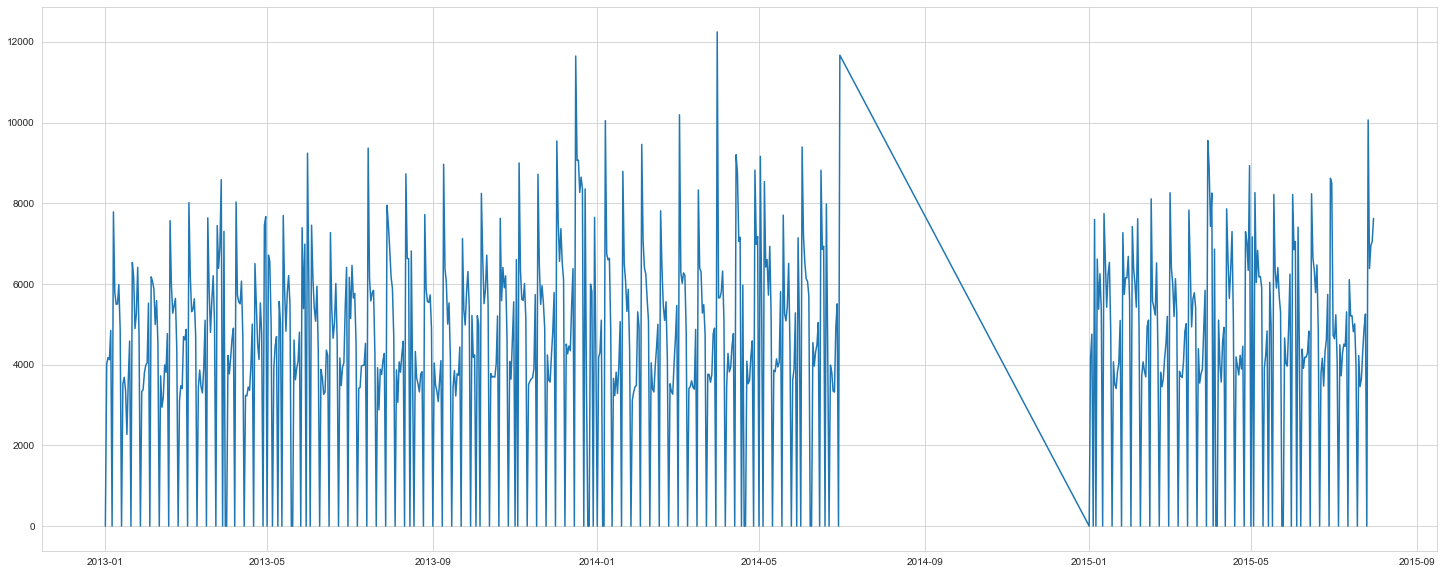

In [391]:
plt.figure(figsize=(25,10))
plt.plot(store_46['Sales'], label='Sales')

plt.show()

In [392]:
# As we can see records are missing from 2014-07-31 to 2014-12-31

In [393]:
store_46.Sales.describe(percentiles = [0.01,0.10,0.25,0.50,0.75,0.90,0.95,0.99,0.995])

count      758.000000
mean      4391.985488
std       2503.576765
min          0.000000
1%           0.000000
10%          0.000000
25%       3525.250000
50%       4657.500000
75%       5996.000000
90%       7282.600000
95%       8248.350000
99%       9498.550000
99.5%    10095.305000
max      12250.000000
Name: Sales, dtype: float64

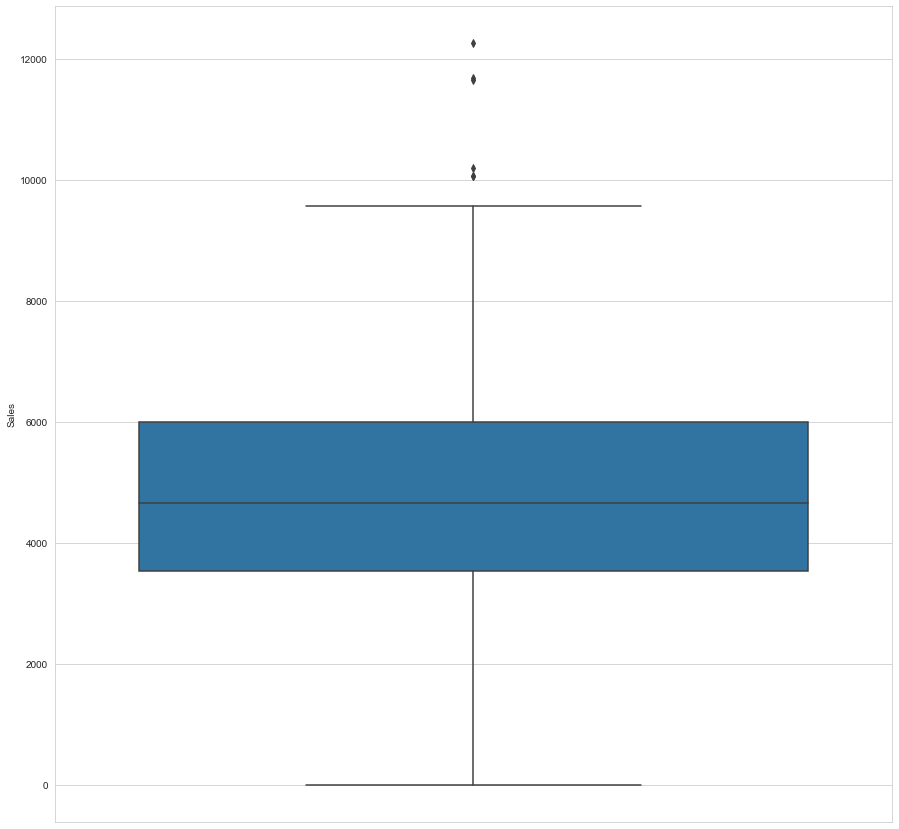

In [394]:
sns.set_style("whitegrid")

plt.figure(figsize=(15, 15))

sns.boxplot(y='Sales', data=store_46)

In [395]:
store_46[store_46.Sales >10200]

Store StoreType  Assortment  CompetitionDistance  Promo2  \
Date                                                                   
2013-12-16     46         c           0               1200.0       1   
2014-03-31     46         c           0               1200.0       1   
2014-06-30     46         c           0               1200.0       1   

            PromoInterval       Date  Sales  Customers  Open  Promo  \
Date                                                                  
2013-12-16            1.0 2013-12-16  11652       1076     1      1   
2014-03-31            1.0 2014-03-31  12250       1029     1      1   
2014-06-30            1.0 2014-06-30  11673       1092     1      1   

            StateHoliday  SchoolHoliday  
Date                                     
2013-12-16             0              0  
2014-03-31             0              0  
2014-06-30             0              0

In [396]:
# Removing outliers

In [397]:
store_46 =store_46[store_46.Sales <10200]

In [398]:
store_46

Store StoreType  Assortment  CompetitionDistance  Promo2  \
Date                                                                   
2013-01-01     46         c           0               1200.0       1   
2013-01-02     46         c           0               1200.0       1   
2013-01-03     46         c           0               1200.0       1   
2013-01-04     46         c           0               1200.0       1   
2013-01-05     46         c           0               1200.0       1   
...           ...       ...         ...                  ...     ...   
2015-07-27     46         c           0               1200.0       1   
2015-07-28     46         c           0               1200.0       1   
2015-07-29     46         c           0               1200.0       1   
2015-07-30     46         c           0               1200.0       1   
2015-07-31     46         c           0               1200.0       1   

            PromoInterval       Date  Sales  Customers  Open  Promo  \
Date                                                                  
2013-01-01            1.0 2013-01-01      0          0     0      0   
2013-01-02            1.0 2013-01-02   4016        582     1      0   
2013-01-03            1.0 2013-01-03   4177        553     1      0   
2013-01-04            1.0 2013-01-04   4125        569     1      0   
2013-01-05            1.0 2013-01-05   4848        651     1      0   
...                   ...        ...    ...        ...   ...    ...   
2015-07-27            1.0 2015-07-27  10068        896     1      1   
2015-07-28            1.0 2015-07-28   6385        714     1      1   
2015-07-29            1.0 2015-07-29   6955        716     1      1   
2015-07-30            1.0 2015-07-30   7057        760     1      1   
2015-07-31            1.0 2015-07-31   7628        775     1      1   

            StateHoliday  SchoolHoliday  
Date                                     
2013-01-01             1              1  
2013-01-02             0              1  
2013-01-03             0              1  
2013-01-04             0              1  
2013-01-05             0              0  
...                  ...            ...  
2015-07-27             0              0  
2015-07-28             0              0  
2015-07-29             0              0  
2015-07-30             0              0  
2015-07-31             0              0  

[755 rows x 13 columns]

In [399]:
#Scaling values
scaler = MinMaxScaler()
store_46[['Sales','Customers']] = scaler.fit_transform(store_46[['Sales','Customers']])

In [400]:
store_46=store_46.append({'Store': 46,'StoreType' : 'c','Assortment':0,
                  'CompetitionDistance' : 1200,'Date' : '2013-12-16',
                   'Sales':1,'Customers':1,
                  'Open':1,'Promo':1,
                  'StateHoliday':0,'SchoolHoliday':0,
                  'Promo2':1,'PromoInterval':1.0},
                  ignore_index=True)

In [401]:
store_46=store_46.append({'Store': 46,'StoreType' : 'c','Assortment':0,
                  'CompetitionDistance' : 1200,'Date' : '2014-03-31',
                   'Sales':1,'Customers':1,
                  'Open':1,'Promo':1,
                  'StateHoliday':0,'SchoolHoliday':0,
                  'Promo2':1,'PromoInterval':1.0},
                  ignore_index=True)

In [402]:
store_46=store_46.append({'Store': 46,'StoreType' : 'c','Assortment':0,
                  'CompetitionDistance' : 1200,'Date' : '2014-06-30',
                   'Sales':1,'Customers':1,
                  'Open':1,'Promo':1,
                  'StateHoliday':0,'SchoolHoliday':0,
                  'Promo2':1,'PromoInterval':1.0},
                  ignore_index=True)

In [403]:
store_46['Date'] = pd.to_datetime(store_46['Date'], format='%Y-%m')

In [404]:
store_46.index = store_46.Date
store_46=store_46.sort_index()

In [405]:
store_46

Store StoreType  Assortment  CompetitionDistance  Promo2  \
Date                                                                   
2013-01-01     46         c           0               1200.0       1   
2013-01-02     46         c           0               1200.0       1   
2013-01-03     46         c           0               1200.0       1   
2013-01-04     46         c           0               1200.0       1   
2013-01-05     46         c           0               1200.0       1   
...           ...       ...         ...                  ...     ...   
2015-07-27     46         c           0               1200.0       1   
2015-07-28     46         c           0               1200.0       1   
2015-07-29     46         c           0               1200.0       1   
2015-07-30     46         c           0               1200.0       1   
2015-07-31     46         c           0               1200.0       1   

            PromoInterval       Date     Sales  Customers  Open  Promo  \
Date                                                                     
2013-01-01            1.0 2013-01-01  0.000000   0.000000     0      0   
2013-01-02            1.0 2013-01-02  0.393919   0.537893     1      0   
2013-01-03            1.0 2013-01-03  0.409711   0.511091     1      0   
2013-01-04            1.0 2013-01-04  0.404610   0.525878     1      0   
2013-01-05            1.0 2013-01-05  0.475527   0.601664     1      0   
...                   ...        ...       ...        ...   ...    ...   
2015-07-27            1.0 2015-07-27  0.987543   0.828096     1      1   
2015-07-28            1.0 2015-07-28  0.626287   0.659889     1      1   
2015-07-29            1.0 2015-07-29  0.682197   0.661738     1      1   
2015-07-30            1.0 2015-07-30  0.692202   0.702403     1      1   
2015-07-31            1.0 2015-07-31  0.748210   0.716266     1      1   

            StateHoliday  SchoolHoliday  
Date                                     
2013-01-01             1              1  
2013-01-02             0              1  
2013-01-03             0              1  
2013-01-04             0              1  
2013-01-05             0              0  
...                  ...            ...  
2015-07-27             0              0  
2015-07-28             0              0  
2015-07-29             0              0  
2015-07-30             0              0  
2015-07-31             0              0  

[758 rows x 13 columns]

In [406]:
train_46 = store_46.loc['2013-01-01': '2014-06-30']
#test_46 = store_46.loc[ '2015-01-01':]

In [407]:
test_46 = store_46.loc[ '2015-01-01':]

In [408]:

train_46=train_46.sort_index()
train_46.index.freq = train_46.index.inferred_freq
train_46.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2014-06-21', '2014-06-22', '2014-06-23', '2014-06-24',
               '2014-06-25', '2014-06-26', '2014-06-27', '2014-06-28',
               '2014-06-29', '2014-06-30'],
              dtype='datetime64[ns]', name='Date', length=546, freq='D')

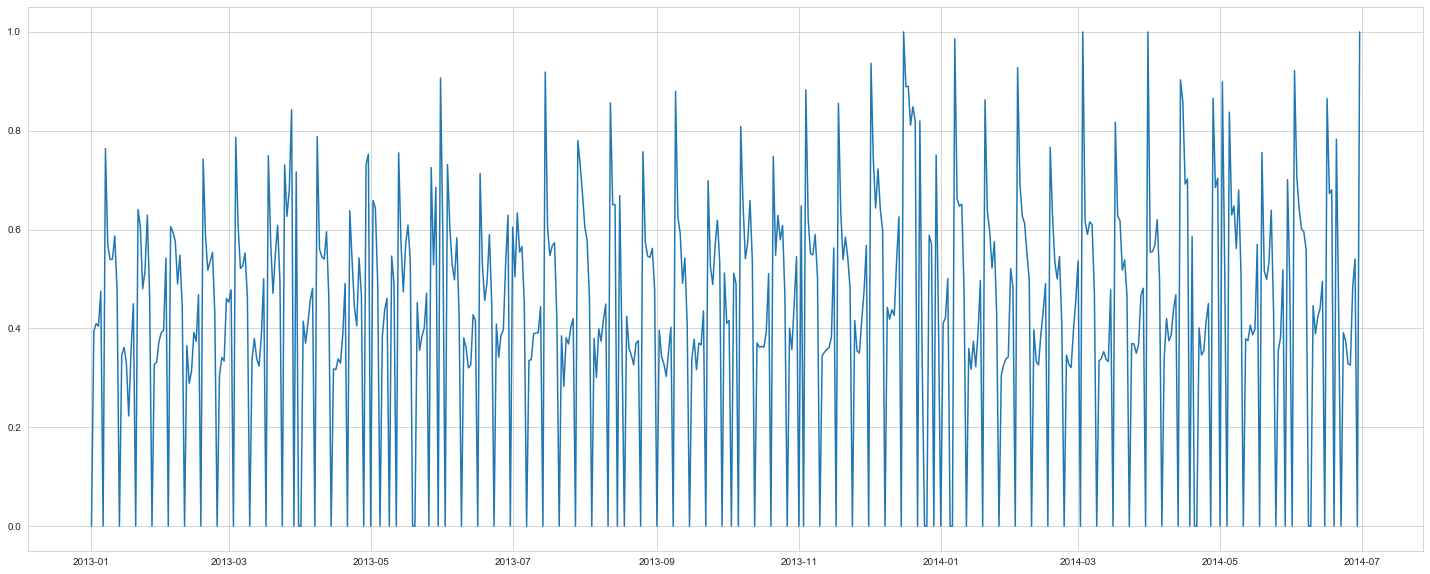

In [409]:
plt.figure(figsize=(25,10))
plt.plot(train_46['Sales'], label='Sales')

plt.show()

In [410]:
# Stationarity test by using dickey fuller for sales
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train_46['Sales'].dropna())

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -6.030750
Critical Values @ 0.05: -2.87
p-value: 0.000000


In [411]:
#Augmented Dickey Fuller for Customers
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train_46['Customers'].dropna())

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -6.123654
Critical Values @ 0.05: -2.87
p-value: 0.000000


In [412]:
#finding lag order
model = VAR(train_46[['Sales','Customers']])
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -8.931281547650988
BIC :  -8.883933447159281
FPE :  0.00013218853945594258
HQIC:  -8.912771286624983 

Lag Order = 2
AIC :  -8.999379509129549
BIC :  -8.920354706797639
FPE :  0.00012348653035314128
HQIC:  -8.96848308143566 

Lag Order = 3
AIC :  -9.023114698903871
BIC :  -8.912323666714045
FPE :  0.00012059028383592363
HQIC:  -8.979795105313054 

Lag Order = 4
AIC :  -9.032470681369361
BIC :  -8.889823470989446
FPE :  0.00011946769288134774
HQIC:  -8.976690745551522 

Lag Order = 5
AIC :  -9.199248354566725
BIC :  -9.024654594613633
FPE :  0.00010111650977190887
HQIC:  -9.130970721930304 

Lag Order = 6
AIC :  -9.525010834782803
BIC :  -9.318379728063329
FPE :  7.300429922060014e-05
HQIC:  -9.444197971304705 

Lag Order = 7
AIC :  -10.049630668357286
BIC :  -9.810870989085913
FPE :  4.320294396581959e-05
HQIC:  -9.956244859403085 

Lag Order = 8
AIC :  -10.110887503370725
BIC :  -9.839907594364218
FPE :  4.0636437786411725e-05
HQIC:  -10.004890852505026 

Lag Orde

In [413]:
#Building Model
mod = sm.tsa.VARMAX(train_46[['Sales','Customers']], order=(15,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  546
Model:                            VAR(15)   Log Likelihood                1298.138
Date:                    Mon, 12 Apr 2021   AIC                          -2470.276
Time:                            14:04:30   BIC                          -2199.211
Sample:                        01-01-2013   HQIC                         -2364.314
                             - 06-30-2014                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):                54.50, 45.57   Jarque-Bera (JB):        397.23, 64.82
Prob(Q):                        0.06, 0.25   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.16, 1.72   Skew:                     -0.73, -0.49
Prob(H) (two-sided):            0.31, 0.00   Kurtosis:                   6.91, 4.37


In [414]:
#predicting values from 2014-07-31 to 2014-12-31
start_index = pd.to_datetime('2014-07-01', format='%Y-%m')
end_index = pd.to_datetime('2014-12-31', format='%Y-%m')
#print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index)

In [415]:
#inverse scaling the values
train_46[['Sales','Customers']]=scaler.inverse_transform(train_46[['Sales','Customers']])
#sorted_test[['Sales','Customers']] = scaler.inverse_transform(sorted_test[['Sales','Customers']])
test_46[['Sales','Customers']]=scaler.inverse_transform(test_46[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

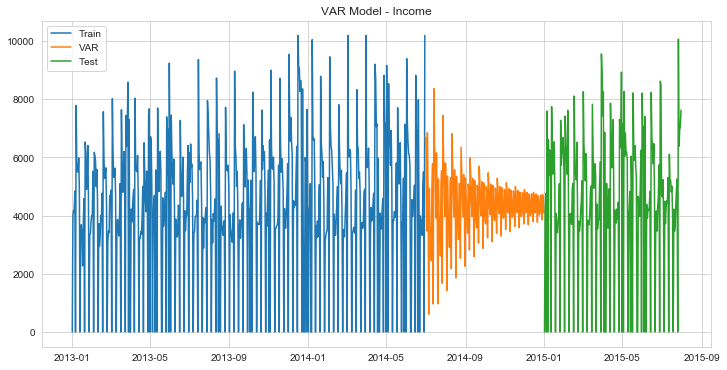

In [416]:
plt.figure(figsize=(12,6)) 
plt.plot( train_46['Sales'], label='Train')
plt.plot(predictions['Sales'], label='VAR')
plt.plot(test_46['Sales'], label='Test')
plt.legend(loc='best')
plt.title('VAR Model - Income')
plt.show()

In [417]:
#appending predicted values to train data
intermediate = train_46[['Sales','Customers']].append(predictions)

In [418]:
#Building complete store data
store_46 = intermediate.append(test_46[['Sales','Customers']])

In [419]:
#Doing stationarity test again
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(store_46['Sales'].dropna())

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -6.338085
Critical Values @ 0.05: -2.86
p-value: 0.000000


In [420]:
#Dicket fuller test 
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(store_46['Customers'].dropna())

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -6.131095
Critical Values @ 0.05: -2.86
p-value: 0.000000


In [421]:
# Scling the values again
scaler = MinMaxScaler()
store_46[['Sales','Customers']] = scaler.fit_transform(store_46[['Sales','Customers']])

In [422]:
#Dividing vlues to train and test
train_46 = store_46.loc['2013-01-01': '2015-05-31']
test_46 = store_46.loc[ '2015-06-01':]

In [423]:
#finding lag order
model = VAR(train_46[['Sales','Customers']])
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -9.300265982049014
BIC :  -9.267675605407158
FPE :  9.13999223358394e-05
HQIC:  -9.287802814997004 

Lag Order = 2
AIC :  -9.38036119783521
BIC :  -9.325995044277928
FPE :  8.436474537734869e-05
HQIC:  -9.359569437487993 

Lag Order = 3
AIC :  -9.406416162957832
BIC :  -9.330235009984152
FPE :  8.2195049133191e-05
HQIC:  -9.377279900901858 

Lag Order = 4
AIC :  -9.417847624842475
BIC :  -9.319812133550913
FPE :  8.126085190707591e-05
HQIC:  -9.38035090426339 

Lag Order = 5
AIC :  -9.570609880367838
BIC :  -9.450680594979024
FPE :  6.974901633301479e-05
HQIC:  -9.524736695849331 

Lag Order = 6
AIC :  -9.879994087460103
BIC :  -9.738131434836905
FPE :  5.118880438259907e-05
HQIC:  -9.825728384781703 

Lag Order = 7
AIC :  -10.418836295769081
BIC :  -10.255000584934223
FPE :  2.9864814165218432e-05
HQIC:  -10.356161971702884 

Lag Order = 8
AIC :  -10.496307999247708
BIC :  -10.310459420898857
FPE :  2.7638574024810834e-05
HQIC:  -10.425208901354027 

Lag Order = 9

In [424]:
#Building model
mod = sm.tsa.VARMAX(train_46[['Sales','Customers']], order=(15,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  881
Model:                            VAR(15)   Log Likelihood                2247.445
Date:                    Mon, 12 Apr 2021   AIC                          -4368.891
Time:                            14:05:10   BIC                          -4067.684
Sample:                        01-01-2013   HQIC                         -4253.710
                             - 05-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):                83.56, 56.34   Jarque-Bera (JB):      1515.08, 287.66
Prob(Q):                        0.00, 0.04   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.81, 0.79   Skew:                     -0.92, -0.58
Prob(H) (two-sided):            0.07, 0.05   Kurtosis:                   9.15, 5.54


In [425]:
# predicting values
start_index = test_46.index.min()
end_index = test_46.index.max()
#print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index)

In [426]:
# inverse scaling the values
train_46[['Sales','Customers']]=scaler.inverse_transform(train_46[['Sales','Customers']])
test_46[['Sales','Customers']] = scaler.inverse_transform(test_46[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

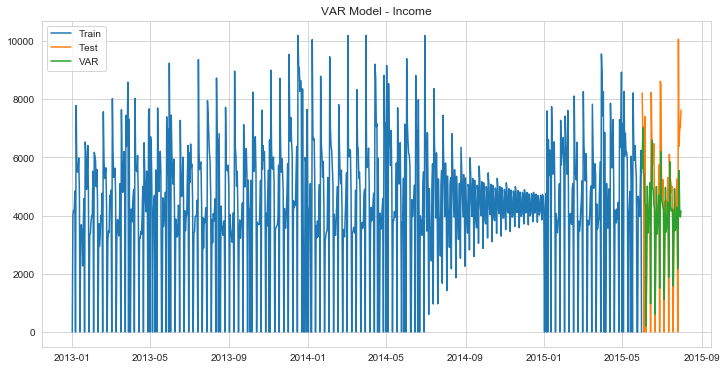

In [427]:
#plotting sales
plt.figure(figsize=(12,6)) 
plt.plot( train_46['Sales'], label='Train')
plt.plot(test_46['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Income')
plt.show()

In [428]:
#Finding the error
rmse = np.sqrt(mean_squared_error(test_46['Sales'], predictions['Sales'][test_46.index.min():])).round(2)
smape = np.round(np.mean(np.abs( test_46['Sales']-predictions['Sales'][test_46.index.min():])/((np.abs(test_46['Sales'])+ np.abs(predictions['Sales']))/2))*100,2)

tempResults = pd.DataFrame({'Method':['VAR method'], 'RMSE': [rmse],'sMAPE': [smape] })
results = pd.DataFrame({'Method':['Naive method'], 'sMAPE': [smape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'sMAPE']]
results

Method     RMSE  sMAPE
0  Naive method  1837.64  50.41

### Predicting future sales

In [429]:
#scaling values
scaler = MinMaxScaler()
store_46[['Sales','Customers']] = scaler.fit_transform(store_46[['Sales','Customers']])

In [430]:
# building model
mod = sm.tsa.VARMAX(store_46[['Sales','Customers']], order=(15,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())
#Note the AIC value - lower AIC => better model

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  942
Model:                            VAR(15)   Log Likelihood                2378.640
Date:                    Mon, 12 Apr 2021   AIC                          -4631.281
Time:                            14:06:41   BIC                          -4325.856
Sample:                        01-01-2013   HQIC                         -4514.862
                             - 07-31-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):                93.60, 61.03   Jarque-Bera (JB):      1584.49, 436.78
Prob(Q):                        0.00, 0.02   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.95, 1.09   Skew:                     -0.97, -0.70
Prob(H) (two-sided):            0.64, 0.46   Kurtosis:                   9.05, 6.03


In [431]:
#predicting future values
start_index = ex_variables.index.min()
end_index = ex_variables.index.max()
#print(start_index,end_index)
predictions = mod.fit().predict(start_index, end_index)

In [432]:
#inverse scaling
store_46[['Sales','Customers']]=scaler.inverse_transform(store_46[['Sales','Customers']])
#sorted_test[['Sales','Customers']] = scaler1.inverse_transform(sorted_test[['Sales','Customers']])
predictions[['Sales','Customers']] = scaler.inverse_transform(predictions[['Sales','Customers']])

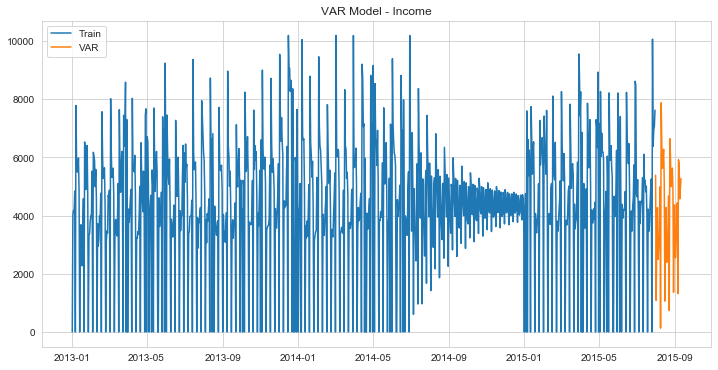

In [433]:
# predicting future values
plt.figure(figsize=(12,6)) 
plt.plot( store_46['Sales'], label='Train')
#plt.plot(sorted_test['Sales'], label='Test')
plt.plot(predictions['Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Income')
plt.show()

In [434]:
predictions['Sales']

2015-08-01    5389.303175
2015-08-02    1082.826018
2015-08-03    3697.891375
2015-08-04    4274.718371
2015-08-05    2498.602211
2015-08-06    2925.377763
2015-08-07    3222.271161
2015-08-08    4988.571781
2015-08-09     132.250881
2015-08-10    7881.004565
2015-08-11    6456.898865
2015-08-12    5628.017325
2015-08-13    5963.625917
2015-08-14    6282.338514
2015-08-15    5131.607966
2015-08-16    1060.888218
2015-08-17    4040.416881
2015-08-18    4276.858654
2015-08-19    2393.986719
2015-08-20    3018.566078
2015-08-21    3359.742427
2015-08-22    4675.467388
2015-08-23     738.550039
2015-08-24    6645.518039
2015-08-25    6075.524120
2015-08-26    4999.365335
2015-08-27    5345.374764
2015-08-28    5638.359273
2015-08-29    4907.759603
2015-08-30    1366.233135
2015-08-31    4360.118511
2015-09-01    4363.751256
2015-09-02    2551.158792
2015-09-03    3192.288895
2015-09-04    3623.230324
2015-09-05    4433.950945
2015-09-06    1321.615096
2015-09-07    5920.552172
2015-09-08  

# Conclusion:

 ## Steps followed:
 
 Merged the 2 data sets.
 
 Removed columns with empty values.
 
 There are columns like storeId,Assortment,Storetype are not useful as we are doing stores invidually. They are same for all the values.
 Found coorelation of the values.Found that Open,Promo and StateHoliday had highes correlation with sales.
 Sales and Customers are linearly related
 Divided the data into stores
 Found outliers,removed them for each store
 Scaled the data.
 Added the removed values back as the dates would me missing .Imputed them with max values as the removed rows had highest values.
 Checked for stationarity.The data is stationary.
 Used VAR to find lag order.
 USed VAR to build model gave lag order 15 as higher lag order is not yielding better results.
 Once Model is Built used it to predict values of test.
 Plotted train test and predictions 
 Used it to find error.
 Once that is done predicted future values by building model again with complete store data and predicting data from 2015-08-01 to 2015-09-11.
 plotted final store and predicted sales values
 
 Used VARX,VARMAX models depending on which give better results and built models with 2 exog variables as they can be supplied to predict future values.
 Once model is built it is used it to build test dates values.The predictions from VARMAX are looking better than VAR models with less error.
 once we have that done the models are built again with complete data to predict final future sales values.
 
  ##### Store 13 and 46
  
  For these 2 stores the data is missing from 2014-07-01 to 2014-12-31.
  So the approach is forecasting values for these dates using VAR .The train data would be 2013-01-01 to 2014-06-30.
  Once the sales values are forecasted for 2014-07-01 to 2014-12-31 the data is appended to actual data file.
  Once the data is built then divide it to train and test data then build the model predict the test data values.
  calculate the error.
  Use the model to predict future values.
  
 #### Calculation of Error
 As MAPE fives inf values because sales is zero on holidays.rather than changing it to some minute postive value it is better to change the error evaluation technique hence using SMAPE to find the error.
 #### EXOG VAriables
 As exog variables have to be provided to VARMAX and i have analysed the data so imputing EXOG variables for future six weeks based on their values of the past.Constructing Exog variables dataframe and providing it to VARMAX to build the model.
 
 
 
 

